# Suo

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Suo_age.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype(float)
adata.obs["age_categorical"] = adata.obs["age"].astype(str)
print(adata_file_path, flush=True)
print(adata, flush=True)

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/dataset_complete_Suo_age.h5ad


AnnData object with n_obs × n_vars = 73697 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_categorical'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'


In [6]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|age_categorical",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 0.25,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 512,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [7]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "age_categorical",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [8]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['age_categorical']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "suo_age-continuous_1"
)

vae.save(
    dir_path,
    overwrite=True,
)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_figures
ID: jkpx3zv2
Name: polar-mountain-151
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_figures/runs/jkpx3zv2
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240503_171649-jkpx3zv2/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_categorical` for `training` set. Number of elements in each group: 4837,7577,5841,6620,15213,18870
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_categorical` for `validation` set. Number of elements in each group: 1176,1867,1478,1724,3752,4742
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:21<3:33:18, 21.37s/it]

Epoch 1/600:   0%|          | 1/600 [00:21<3:33:18, 21.37s/it, v_num=v2_1, total_loss_train=585, kl_local_train=43.1]

Epoch 2/600:   0%|          | 1/600 [00:21<3:33:18, 21.37s/it, v_num=v2_1, total_loss_train=585, kl_local_train=43.1]

Epoch 2/600:   0%|          | 2/600 [00:34<2:43:59, 16.45s/it, v_num=v2_1, total_loss_train=585, kl_local_train=43.1]

Epoch 2/600:   0%|          | 2/600 [00:34<2:43:59, 16.45s/it, v_num=v2_1, total_loss_train=453, kl_local_train=64.9]

Epoch 3/600:   0%|          | 2/600 [00:34<2:43:59, 16.45s/it, v_num=v2_1, total_loss_train=453, kl_local_train=64.9]

Epoch 3/600:   0%|          | 3/600 [00:47<2:28:05, 14.88s/it, v_num=v2_1, total_loss_train=453, kl_local_train=64.9]

Epoch 3/600:   0%|          | 3/600 [00:47<2:28:05, 14.88s/it, v_num=v2_1, total_loss_train=437, kl_local_train=71.3]

Epoch 4/600:   0%|          | 3/600 [00:47<2:28:05, 14.88s/it, v_num=v2_1, total_loss_train=437, kl_local_train=71.3]

Epoch 4/600:   1%|          | 4/600 [01:00<2:20:12, 14.11s/it, v_num=v2_1, total_loss_train=437, kl_local_train=71.3]

Epoch 4/600:   1%|          | 4/600 [01:00<2:20:12, 14.11s/it, v_num=v2_1, total_loss_train=430, kl_local_train=73.5]

Epoch 5/600:   1%|          | 4/600 [01:00<2:20:12, 14.11s/it, v_num=v2_1, total_loss_train=430, kl_local_train=73.5]

Epoch 5/600:   1%|          | 5/600 [01:13<2:17:32, 13.87s/it, v_num=v2_1, total_loss_train=430, kl_local_train=73.5]

Epoch 5/600:   1%|          | 5/600 [01:13<2:17:32, 13.87s/it, v_num=v2_1, total_loss_train=426, kl_local_train=74.1]

Epoch 6/600:   1%|          | 5/600 [01:14<2:17:32, 13.87s/it, v_num=v2_1, total_loss_train=426, kl_local_train=74.1]

Epoch 6/600:   1%|          | 6/600 [01:27<2:17:35, 13.90s/it, v_num=v2_1, total_loss_train=426, kl_local_train=74.1]

Epoch 6/600:   1%|          | 6/600 [01:27<2:17:35, 13.90s/it, v_num=v2_1, total_loss_train=423, kl_local_train=73.5, metric_mi|age_categorical_train=0.0763]

Epoch 7/600:   1%|          | 6/600 [01:27<2:17:35, 13.90s/it, v_num=v2_1, total_loss_train=423, kl_local_train=73.5, metric_mi|age_categorical_train=0.0763]

Epoch 7/600:   1%|          | 7/600 [01:40<2:14:42, 13.63s/it, v_num=v2_1, total_loss_train=423, kl_local_train=73.5, metric_mi|age_categorical_train=0.0763]

Epoch 7/600:   1%|          | 7/600 [01:40<2:14:42, 13.63s/it, v_num=v2_1, total_loss_train=420, kl_local_train=72.3, metric_mi|age_categorical_train=0.0763]

Epoch 8/600:   1%|          | 7/600 [01:40<2:14:42, 13.63s/it, v_num=v2_1, total_loss_train=420, kl_local_train=72.3, metric_mi|age_categorical_train=0.0763]

Epoch 8/600:   1%|▏         | 8/600 [01:53<2:12:44, 13.45s/it, v_num=v2_1, total_loss_train=420, kl_local_train=72.3, metric_mi|age_categorical_train=0.0763]

Epoch 8/600:   1%|▏         | 8/600 [01:53<2:12:44, 13.45s/it, v_num=v2_1, total_loss_train=429, kl_local_train=88, metric_mi|age_categorical_train=0.0763]  

Epoch 9/600:   1%|▏         | 8/600 [01:53<2:12:44, 13.45s/it, v_num=v2_1, total_loss_train=429, kl_local_train=88, metric_mi|age_categorical_train=0.0763]

Epoch 9/600:   2%|▏         | 9/600 [02:06<2:11:11, 13.32s/it, v_num=v2_1, total_loss_train=429, kl_local_train=88, metric_mi|age_categorical_train=0.0763]

Epoch 9/600:   2%|▏         | 9/600 [02:06<2:11:11, 13.32s/it, v_num=v2_1, total_loss_train=437, kl_local_train=85.6, metric_mi|age_categorical_train=0.0763]

Epoch 10/600:   2%|▏         | 9/600 [02:06<2:11:11, 13.32s/it, v_num=v2_1, total_loss_train=437, kl_local_train=85.6, metric_mi|age_categorical_train=0.0763]

Epoch 10/600:   2%|▏         | 10/600 [02:20<2:10:58, 13.32s/it, v_num=v2_1, total_loss_train=437, kl_local_train=85.6, metric_mi|age_categorical_train=0.0763]

Epoch 10/600:   2%|▏         | 10/600 [02:20<2:10:58, 13.32s/it, v_num=v2_1, total_loss_train=435, kl_local_train=151, metric_mi|age_categorical_train=0.0763] 

Epoch 11/600:   2%|▏         | 10/600 [02:21<2:10:58, 13.32s/it, v_num=v2_1, total_loss_train=435, kl_local_train=151, metric_mi|age_categorical_train=0.0763]

Epoch 11/600:   2%|▏         | 11/600 [02:34<2:12:58, 13.55s/it, v_num=v2_1, total_loss_train=435, kl_local_train=151, metric_mi|age_categorical_train=0.0763]

Epoch 11/600:   2%|▏         | 11/600 [02:34<2:12:58, 13.55s/it, v_num=v2_1, total_loss_train=430, kl_local_train=239, metric_mi|age_categorical_train=0.115] 

Epoch 12/600:   2%|▏         | 11/600 [02:34<2:12:58, 13.55s/it, v_num=v2_1, total_loss_train=430, kl_local_train=239, metric_mi|age_categorical_train=0.115]

Epoch 12/600:   2%|▏         | 12/600 [02:47<2:11:12, 13.39s/it, v_num=v2_1, total_loss_train=430, kl_local_train=239, metric_mi|age_categorical_train=0.115]

Epoch 12/600:   2%|▏         | 12/600 [02:47<2:11:12, 13.39s/it, v_num=v2_1, total_loss_train=431, kl_local_train=259, metric_mi|age_categorical_train=0.115]

Epoch 13/600:   2%|▏         | 12/600 [02:47<2:11:12, 13.39s/it, v_num=v2_1, total_loss_train=431, kl_local_train=259, metric_mi|age_categorical_train=0.115]

Epoch 13/600:   2%|▏         | 13/600 [03:00<2:09:59, 13.29s/it, v_num=v2_1, total_loss_train=431, kl_local_train=259, metric_mi|age_categorical_train=0.115]

Epoch 13/600:   2%|▏         | 13/600 [03:00<2:09:59, 13.29s/it, v_num=v2_1, total_loss_train=432, kl_local_train=247, metric_mi|age_categorical_train=0.115]

Epoch 14/600:   2%|▏         | 13/600 [03:00<2:09:59, 13.29s/it, v_num=v2_1, total_loss_train=432, kl_local_train=247, metric_mi|age_categorical_train=0.115]

Epoch 14/600:   2%|▏         | 14/600 [03:13<2:09:00, 13.21s/it, v_num=v2_1, total_loss_train=432, kl_local_train=247, metric_mi|age_categorical_train=0.115]

Epoch 14/600:   2%|▏         | 14/600 [03:13<2:09:00, 13.21s/it, v_num=v2_1, total_loss_train=433, kl_local_train=234, metric_mi|age_categorical_train=0.115]

Epoch 15/600:   2%|▏         | 14/600 [03:13<2:09:00, 13.21s/it, v_num=v2_1, total_loss_train=433, kl_local_train=234, metric_mi|age_categorical_train=0.115]

Epoch 15/600:   2%|▎         | 15/600 [03:26<2:09:12, 13.25s/it, v_num=v2_1, total_loss_train=433, kl_local_train=234, metric_mi|age_categorical_train=0.115]

Epoch 15/600:   2%|▎         | 15/600 [03:26<2:09:12, 13.25s/it, v_num=v2_1, total_loss_train=434, kl_local_train=254, metric_mi|age_categorical_train=0.115]

Epoch 16/600:   2%|▎         | 15/600 [03:27<2:09:12, 13.25s/it, v_num=v2_1, total_loss_train=434, kl_local_train=254, metric_mi|age_categorical_train=0.115]

Epoch 16/600:   3%|▎         | 16/600 [03:40<2:11:23, 13.50s/it, v_num=v2_1, total_loss_train=434, kl_local_train=254, metric_mi|age_categorical_train=0.115]

Epoch 16/600:   3%|▎         | 16/600 [03:40<2:11:23, 13.50s/it, v_num=v2_1, total_loss_train=435, kl_local_train=279, metric_mi|age_categorical_train=0.199]

Epoch 17/600:   3%|▎         | 16/600 [03:40<2:11:23, 13.50s/it, v_num=v2_1, total_loss_train=435, kl_local_train=279, metric_mi|age_categorical_train=0.199]

Epoch 17/600:   3%|▎         | 17/600 [03:53<2:10:07, 13.39s/it, v_num=v2_1, total_loss_train=435, kl_local_train=279, metric_mi|age_categorical_train=0.199]

Epoch 17/600:   3%|▎         | 17/600 [03:53<2:10:07, 13.39s/it, v_num=v2_1, total_loss_train=436, kl_local_train=293, metric_mi|age_categorical_train=0.199]

Epoch 18/600:   3%|▎         | 17/600 [03:53<2:10:07, 13.39s/it, v_num=v2_1, total_loss_train=436, kl_local_train=293, metric_mi|age_categorical_train=0.199]

Epoch 18/600:   3%|▎         | 18/600 [04:07<2:09:03, 13.30s/it, v_num=v2_1, total_loss_train=436, kl_local_train=293, metric_mi|age_categorical_train=0.199]

Epoch 18/600:   3%|▎         | 18/600 [04:07<2:09:03, 13.30s/it, v_num=v2_1, total_loss_train=437, kl_local_train=304, metric_mi|age_categorical_train=0.199]

Epoch 19/600:   3%|▎         | 18/600 [04:07<2:09:03, 13.30s/it, v_num=v2_1, total_loss_train=437, kl_local_train=304, metric_mi|age_categorical_train=0.199]

Epoch 19/600:   3%|▎         | 19/600 [04:20<2:08:11, 13.24s/it, v_num=v2_1, total_loss_train=437, kl_local_train=304, metric_mi|age_categorical_train=0.199]

Epoch 19/600:   3%|▎         | 19/600 [04:20<2:08:11, 13.24s/it, v_num=v2_1, total_loss_train=438, kl_local_train=305, metric_mi|age_categorical_train=0.199]

Epoch 20/600:   3%|▎         | 19/600 [04:20<2:08:11, 13.24s/it, v_num=v2_1, total_loss_train=438, kl_local_train=305, metric_mi|age_categorical_train=0.199]

Epoch 20/600:   3%|▎         | 20/600 [04:33<2:08:22, 13.28s/it, v_num=v2_1, total_loss_train=438, kl_local_train=305, metric_mi|age_categorical_train=0.199]

Epoch 20/600:   3%|▎         | 20/600 [04:33<2:08:22, 13.28s/it, v_num=v2_1, total_loss_train=439, kl_local_train=298, metric_mi|age_categorical_train=0.199]

Epoch 21/600:   3%|▎         | 20/600 [04:34<2:08:22, 13.28s/it, v_num=v2_1, total_loss_train=439, kl_local_train=298, metric_mi|age_categorical_train=0.199]

Epoch 21/600:   4%|▎         | 21/600 [04:47<2:10:52, 13.56s/it, v_num=v2_1, total_loss_train=439, kl_local_train=298, metric_mi|age_categorical_train=0.199]

Epoch 21/600:   4%|▎         | 21/600 [04:47<2:10:52, 13.56s/it, v_num=v2_1, total_loss_train=441, kl_local_train=300, metric_mi|age_categorical_train=0.253]

Epoch 22/600:   4%|▎         | 21/600 [04:47<2:10:52, 13.56s/it, v_num=v2_1, total_loss_train=441, kl_local_train=300, metric_mi|age_categorical_train=0.253]

Epoch 22/600:   4%|▎         | 22/600 [05:00<2:09:29, 13.44s/it, v_num=v2_1, total_loss_train=441, kl_local_train=300, metric_mi|age_categorical_train=0.253]

Epoch 22/600:   4%|▎         | 22/600 [05:00<2:09:29, 13.44s/it, v_num=v2_1, total_loss_train=442, kl_local_train=306, metric_mi|age_categorical_train=0.253]

Epoch 23/600:   4%|▎         | 22/600 [05:00<2:09:29, 13.44s/it, v_num=v2_1, total_loss_train=442, kl_local_train=306, metric_mi|age_categorical_train=0.253]

Epoch 23/600:   4%|▍         | 23/600 [05:14<2:08:34, 13.37s/it, v_num=v2_1, total_loss_train=442, kl_local_train=306, metric_mi|age_categorical_train=0.253]

Epoch 23/600:   4%|▍         | 23/600 [05:14<2:08:34, 13.37s/it, v_num=v2_1, total_loss_train=444, kl_local_train=301, metric_mi|age_categorical_train=0.253]

Epoch 24/600:   4%|▍         | 23/600 [05:14<2:08:34, 13.37s/it, v_num=v2_1, total_loss_train=444, kl_local_train=301, metric_mi|age_categorical_train=0.253]

Epoch 24/600:   4%|▍         | 24/600 [05:27<2:07:28, 13.28s/it, v_num=v2_1, total_loss_train=444, kl_local_train=301, metric_mi|age_categorical_train=0.253]

Epoch 24/600:   4%|▍         | 24/600 [05:27<2:07:28, 13.28s/it, v_num=v2_1, total_loss_train=445, kl_local_train=294, metric_mi|age_categorical_train=0.253]

Epoch 25/600:   4%|▍         | 24/600 [05:27<2:07:28, 13.28s/it, v_num=v2_1, total_loss_train=445, kl_local_train=294, metric_mi|age_categorical_train=0.253]

Epoch 25/600:   4%|▍         | 25/600 [05:40<2:07:04, 13.26s/it, v_num=v2_1, total_loss_train=445, kl_local_train=294, metric_mi|age_categorical_train=0.253]

Epoch 25/600:   4%|▍         | 25/600 [05:40<2:07:04, 13.26s/it, v_num=v2_1, total_loss_train=446, kl_local_train=297, metric_mi|age_categorical_train=0.253]

Epoch 26/600:   4%|▍         | 25/600 [05:41<2:07:04, 13.26s/it, v_num=v2_1, total_loss_train=446, kl_local_train=297, metric_mi|age_categorical_train=0.253]

Epoch 26/600:   4%|▍         | 26/600 [05:54<2:09:09, 13.50s/it, v_num=v2_1, total_loss_train=446, kl_local_train=297, metric_mi|age_categorical_train=0.253]

Epoch 26/600:   4%|▍         | 26/600 [05:54<2:09:09, 13.50s/it, v_num=v2_1, total_loss_train=448, kl_local_train=296, metric_mi|age_categorical_train=0.25] 

Epoch 27/600:   4%|▍         | 26/600 [05:54<2:09:09, 13.50s/it, v_num=v2_1, total_loss_train=448, kl_local_train=296, metric_mi|age_categorical_train=0.25]

Epoch 27/600:   4%|▍         | 27/600 [06:07<2:07:43, 13.37s/it, v_num=v2_1, total_loss_train=448, kl_local_train=296, metric_mi|age_categorical_train=0.25]

Epoch 27/600:   4%|▍         | 27/600 [06:07<2:07:43, 13.37s/it, v_num=v2_1, total_loss_train=449, kl_local_train=290, metric_mi|age_categorical_train=0.25]

Epoch 28/600:   4%|▍         | 27/600 [06:07<2:07:43, 13.37s/it, v_num=v2_1, total_loss_train=449, kl_local_train=290, metric_mi|age_categorical_train=0.25]

Epoch 28/600:   5%|▍         | 28/600 [06:20<2:06:43, 13.29s/it, v_num=v2_1, total_loss_train=449, kl_local_train=290, metric_mi|age_categorical_train=0.25]

Epoch 28/600:   5%|▍         | 28/600 [06:20<2:06:43, 13.29s/it, v_num=v2_1, total_loss_train=451, kl_local_train=295, metric_mi|age_categorical_train=0.25]

Epoch 29/600:   5%|▍         | 28/600 [06:20<2:06:43, 13.29s/it, v_num=v2_1, total_loss_train=451, kl_local_train=295, metric_mi|age_categorical_train=0.25]

Epoch 29/600:   5%|▍         | 29/600 [06:33<2:05:58, 13.24s/it, v_num=v2_1, total_loss_train=451, kl_local_train=295, metric_mi|age_categorical_train=0.25]

Epoch 29/600:   5%|▍         | 29/600 [06:33<2:05:58, 13.24s/it, v_num=v2_1, total_loss_train=452, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 30/600:   5%|▍         | 29/600 [06:33<2:05:58, 13.24s/it, v_num=v2_1, total_loss_train=452, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 30/600:   5%|▌         | 30/600 [06:47<2:05:49, 13.25s/it, v_num=v2_1, total_loss_train=452, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 30/600:   5%|▌         | 30/600 [06:47<2:05:49, 13.25s/it, v_num=v2_1, total_loss_train=454, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 31/600:   5%|▌         | 30/600 [06:48<2:05:49, 13.25s/it, v_num=v2_1, total_loss_train=454, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 31/600:   5%|▌         | 31/600 [07:01<2:08:06, 13.51s/it, v_num=v2_1, total_loss_train=454, kl_local_train=292, metric_mi|age_categorical_train=0.25]

Epoch 31/600:   5%|▌         | 31/600 [07:01<2:08:06, 13.51s/it, v_num=v2_1, total_loss_train=455, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 32/600:   5%|▌         | 31/600 [07:01<2:08:06, 13.51s/it, v_num=v2_1, total_loss_train=455, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 32/600:   5%|▌         | 32/600 [07:14<2:06:35, 13.37s/it, v_num=v2_1, total_loss_train=455, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 32/600:   5%|▌         | 32/600 [07:14<2:06:35, 13.37s/it, v_num=v2_1, total_loss_train=457, kl_local_train=294, metric_mi|age_categorical_train=0.243]

Epoch 33/600:   5%|▌         | 32/600 [07:14<2:06:35, 13.37s/it, v_num=v2_1, total_loss_train=457, kl_local_train=294, metric_mi|age_categorical_train=0.243]

Epoch 33/600:   6%|▌         | 33/600 [07:27<2:05:25, 13.27s/it, v_num=v2_1, total_loss_train=457, kl_local_train=294, metric_mi|age_categorical_train=0.243]

Epoch 33/600:   6%|▌         | 33/600 [07:27<2:05:25, 13.27s/it, v_num=v2_1, total_loss_train=459, kl_local_train=292, metric_mi|age_categorical_train=0.243]

Epoch 34/600:   6%|▌         | 33/600 [07:27<2:05:25, 13.27s/it, v_num=v2_1, total_loss_train=459, kl_local_train=292, metric_mi|age_categorical_train=0.243]

Epoch 34/600:   6%|▌         | 34/600 [07:40<2:04:44, 13.22s/it, v_num=v2_1, total_loss_train=459, kl_local_train=292, metric_mi|age_categorical_train=0.243]

Epoch 34/600:   6%|▌         | 34/600 [07:40<2:04:44, 13.22s/it, v_num=v2_1, total_loss_train=460, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 35/600:   6%|▌         | 34/600 [07:40<2:04:44, 13.22s/it, v_num=v2_1, total_loss_train=460, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 35/600:   6%|▌         | 35/600 [07:53<2:04:19, 13.20s/it, v_num=v2_1, total_loss_train=460, kl_local_train=287, metric_mi|age_categorical_train=0.243]

Epoch 35/600:   6%|▌         | 35/600 [07:53<2:04:19, 13.20s/it, v_num=v2_1, total_loss_train=462, kl_local_train=286, metric_mi|age_categorical_train=0.243]

Epoch 36/600:   6%|▌         | 35/600 [07:54<2:04:19, 13.20s/it, v_num=v2_1, total_loss_train=462, kl_local_train=286, metric_mi|age_categorical_train=0.243]

Epoch 36/600:   6%|▌         | 36/600 [08:07<2:06:35, 13.47s/it, v_num=v2_1, total_loss_train=462, kl_local_train=286, metric_mi|age_categorical_train=0.243]

Epoch 36/600:   6%|▌         | 36/600 [08:07<2:06:35, 13.47s/it, v_num=v2_1, total_loss_train=463, kl_local_train=281, metric_mi|age_categorical_train=0.257]

Epoch 37/600:   6%|▌         | 36/600 [08:07<2:06:35, 13.47s/it, v_num=v2_1, total_loss_train=463, kl_local_train=281, metric_mi|age_categorical_train=0.257]

Epoch 37/600:   6%|▌         | 37/600 [08:20<2:05:13, 13.35s/it, v_num=v2_1, total_loss_train=463, kl_local_train=281, metric_mi|age_categorical_train=0.257]

Epoch 37/600:   6%|▌         | 37/600 [08:20<2:05:13, 13.35s/it, v_num=v2_1, total_loss_train=465, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 38/600:   6%|▌         | 37/600 [08:20<2:05:13, 13.35s/it, v_num=v2_1, total_loss_train=465, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 38/600:   6%|▋         | 38/600 [08:33<2:04:59, 13.34s/it, v_num=v2_1, total_loss_train=465, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 38/600:   6%|▋         | 38/600 [08:33<2:04:59, 13.34s/it, v_num=v2_1, total_loss_train=467, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 39/600:   6%|▋         | 38/600 [08:33<2:04:59, 13.34s/it, v_num=v2_1, total_loss_train=467, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 39/600:   6%|▋         | 39/600 [08:47<2:04:02, 13.27s/it, v_num=v2_1, total_loss_train=467, kl_local_train=285, metric_mi|age_categorical_train=0.257]

Epoch 39/600:   6%|▋         | 39/600 [08:47<2:04:02, 13.27s/it, v_num=v2_1, total_loss_train=469, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 40/600:   6%|▋         | 39/600 [08:47<2:04:02, 13.27s/it, v_num=v2_1, total_loss_train=469, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 40/600:   7%|▋         | 40/600 [09:00<2:03:57, 13.28s/it, v_num=v2_1, total_loss_train=469, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 40/600:   7%|▋         | 40/600 [09:00<2:03:57, 13.28s/it, v_num=v2_1, total_loss_train=471, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 41/600:   7%|▋         | 40/600 [09:01<2:03:57, 13.28s/it, v_num=v2_1, total_loss_train=471, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 41/600:   7%|▋         | 41/600 [09:14<2:05:45, 13.50s/it, v_num=v2_1, total_loss_train=471, kl_local_train=280, metric_mi|age_categorical_train=0.257]

Epoch 41/600:   7%|▋         | 41/600 [09:14<2:05:45, 13.50s/it, v_num=v2_1, total_loss_train=473, kl_local_train=281, metric_mi|age_categorical_train=0.241]

Epoch 42/600:   7%|▋         | 41/600 [09:14<2:05:45, 13.50s/it, v_num=v2_1, total_loss_train=473, kl_local_train=281, metric_mi|age_categorical_train=0.241]

Epoch 42/600:   7%|▋         | 42/600 [09:27<2:04:15, 13.36s/it, v_num=v2_1, total_loss_train=473, kl_local_train=281, metric_mi|age_categorical_train=0.241]

Epoch 42/600:   7%|▋         | 42/600 [09:27<2:04:15, 13.36s/it, v_num=v2_1, total_loss_train=474, kl_local_train=278, metric_mi|age_categorical_train=0.241]

Epoch 43/600:   7%|▋         | 42/600 [09:27<2:04:15, 13.36s/it, v_num=v2_1, total_loss_train=474, kl_local_train=278, metric_mi|age_categorical_train=0.241]

Epoch 43/600:   7%|▋         | 43/600 [09:40<2:03:18, 13.28s/it, v_num=v2_1, total_loss_train=474, kl_local_train=278, metric_mi|age_categorical_train=0.241]

Epoch 43/600:   7%|▋         | 43/600 [09:40<2:03:18, 13.28s/it, v_num=v2_1, total_loss_train=476, kl_local_train=270, metric_mi|age_categorical_train=0.241]

Epoch 44/600:   7%|▋         | 43/600 [09:40<2:03:18, 13.28s/it, v_num=v2_1, total_loss_train=476, kl_local_train=270, metric_mi|age_categorical_train=0.241]

Epoch 44/600:   7%|▋         | 44/600 [09:53<2:02:22, 13.21s/it, v_num=v2_1, total_loss_train=476, kl_local_train=270, metric_mi|age_categorical_train=0.241]

Epoch 44/600:   7%|▋         | 44/600 [09:53<2:02:22, 13.21s/it, v_num=v2_1, total_loss_train=477, kl_local_train=267, metric_mi|age_categorical_train=0.241]

Epoch 45/600:   7%|▋         | 44/600 [09:53<2:02:22, 13.21s/it, v_num=v2_1, total_loss_train=477, kl_local_train=267, metric_mi|age_categorical_train=0.241]

Epoch 45/600:   8%|▊         | 45/600 [10:06<2:02:03, 13.20s/it, v_num=v2_1, total_loss_train=477, kl_local_train=267, metric_mi|age_categorical_train=0.241]

Epoch 45/600:   8%|▊         | 45/600 [10:06<2:02:03, 13.20s/it, v_num=v2_1, total_loss_train=479, kl_local_train=271, metric_mi|age_categorical_train=0.241]

Epoch 46/600:   8%|▊         | 45/600 [10:07<2:02:03, 13.20s/it, v_num=v2_1, total_loss_train=479, kl_local_train=271, metric_mi|age_categorical_train=0.241]

Epoch 46/600:   8%|▊         | 46/600 [10:20<2:04:19, 13.46s/it, v_num=v2_1, total_loss_train=479, kl_local_train=271, metric_mi|age_categorical_train=0.241]

Epoch 46/600:   8%|▊         | 46/600 [10:20<2:04:19, 13.46s/it, v_num=v2_1, total_loss_train=481, kl_local_train=270, metric_mi|age_categorical_train=0.262]

Epoch 47/600:   8%|▊         | 46/600 [10:20<2:04:19, 13.46s/it, v_num=v2_1, total_loss_train=481, kl_local_train=270, metric_mi|age_categorical_train=0.262]

Epoch 47/600:   8%|▊         | 47/600 [10:34<2:03:36, 13.41s/it, v_num=v2_1, total_loss_train=481, kl_local_train=270, metric_mi|age_categorical_train=0.262]

Epoch 47/600:   8%|▊         | 47/600 [10:34<2:03:36, 13.41s/it, v_num=v2_1, total_loss_train=483, kl_local_train=266, metric_mi|age_categorical_train=0.262]

Epoch 48/600:   8%|▊         | 47/600 [10:34<2:03:36, 13.41s/it, v_num=v2_1, total_loss_train=483, kl_local_train=266, metric_mi|age_categorical_train=0.262]

Epoch 48/600:   8%|▊         | 48/600 [10:47<2:02:25, 13.31s/it, v_num=v2_1, total_loss_train=483, kl_local_train=266, metric_mi|age_categorical_train=0.262]

Epoch 48/600:   8%|▊         | 48/600 [10:47<2:02:25, 13.31s/it, v_num=v2_1, total_loss_train=485, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 49/600:   8%|▊         | 48/600 [10:47<2:02:25, 13.31s/it, v_num=v2_1, total_loss_train=485, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 49/600:   8%|▊         | 49/600 [11:00<2:01:34, 13.24s/it, v_num=v2_1, total_loss_train=485, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 49/600:   8%|▊         | 49/600 [11:00<2:01:34, 13.24s/it, v_num=v2_1, total_loss_train=487, kl_local_train=257, metric_mi|age_categorical_train=0.262]

Epoch 50/600:   8%|▊         | 49/600 [11:00<2:01:34, 13.24s/it, v_num=v2_1, total_loss_train=487, kl_local_train=257, metric_mi|age_categorical_train=0.262]

Epoch 50/600:   8%|▊         | 50/600 [11:13<2:01:15, 13.23s/it, v_num=v2_1, total_loss_train=487, kl_local_train=257, metric_mi|age_categorical_train=0.262]

Epoch 50/600:   8%|▊         | 50/600 [11:13<2:01:15, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 51/600:   8%|▊         | 50/600 [11:14<2:01:15, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 51/600:   8%|▊         | 51/600 [11:27<2:03:00, 13.44s/it, v_num=v2_1, total_loss_train=488, kl_local_train=260, metric_mi|age_categorical_train=0.262]

Epoch 51/600:   8%|▊         | 51/600 [11:27<2:03:00, 13.44s/it, v_num=v2_1, total_loss_train=488, kl_local_train=258, metric_mi|age_categorical_train=0.245]

Epoch 52/600:   8%|▊         | 51/600 [11:27<2:03:00, 13.44s/it, v_num=v2_1, total_loss_train=488, kl_local_train=258, metric_mi|age_categorical_train=0.245]

Epoch 52/600:   9%|▊         | 52/600 [11:40<2:01:42, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=258, metric_mi|age_categorical_train=0.245]

Epoch 52/600:   9%|▊         | 52/600 [11:40<2:01:42, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 53/600:   9%|▊         | 52/600 [11:40<2:01:42, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 53/600:   9%|▉         | 53/600 [11:53<2:00:40, 13.24s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 53/600:   9%|▉         | 53/600 [11:53<2:00:40, 13.24s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 54/600:   9%|▉         | 53/600 [11:53<2:00:40, 13.24s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 54/600:   9%|▉         | 54/600 [12:06<1:59:53, 13.17s/it, v_num=v2_1, total_loss_train=488, kl_local_train=254, metric_mi|age_categorical_train=0.245]

Epoch 54/600:   9%|▉         | 54/600 [12:06<1:59:53, 13.17s/it, v_num=v2_1, total_loss_train=488, kl_local_train=247, metric_mi|age_categorical_train=0.245]

Epoch 55/600:   9%|▉         | 54/600 [12:06<1:59:53, 13.17s/it, v_num=v2_1, total_loss_train=488, kl_local_train=247, metric_mi|age_categorical_train=0.245]

Epoch 55/600:   9%|▉         | 55/600 [12:19<1:59:58, 13.21s/it, v_num=v2_1, total_loss_train=488, kl_local_train=247, metric_mi|age_categorical_train=0.245]

Epoch 55/600:   9%|▉         | 55/600 [12:19<1:59:58, 13.21s/it, v_num=v2_1, total_loss_train=489, kl_local_train=249, metric_mi|age_categorical_train=0.245]

Epoch 56/600:   9%|▉         | 55/600 [12:20<1:59:58, 13.21s/it, v_num=v2_1, total_loss_train=489, kl_local_train=249, metric_mi|age_categorical_train=0.245]

Epoch 56/600:   9%|▉         | 56/600 [12:33<2:01:52, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=249, metric_mi|age_categorical_train=0.245]

Epoch 56/600:   9%|▉         | 56/600 [12:33<2:01:52, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=248, metric_mi|age_categorical_train=0.256]

Epoch 57/600:   9%|▉         | 56/600 [12:33<2:01:52, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=248, metric_mi|age_categorical_train=0.256]

Epoch 57/600:  10%|▉         | 57/600 [12:46<2:00:09, 13.28s/it, v_num=v2_1, total_loss_train=489, kl_local_train=248, metric_mi|age_categorical_train=0.256]

Epoch 57/600:  10%|▉         | 57/600 [12:46<2:00:09, 13.28s/it, v_num=v2_1, total_loss_train=488, kl_local_train=246, metric_mi|age_categorical_train=0.256]

Epoch 58/600:  10%|▉         | 57/600 [12:46<2:00:09, 13.28s/it, v_num=v2_1, total_loss_train=488, kl_local_train=246, metric_mi|age_categorical_train=0.256]

Epoch 58/600:  10%|▉         | 58/600 [12:59<1:59:17, 13.20s/it, v_num=v2_1, total_loss_train=488, kl_local_train=246, metric_mi|age_categorical_train=0.256]

Epoch 58/600:  10%|▉         | 58/600 [12:59<1:59:17, 13.20s/it, v_num=v2_1, total_loss_train=489, kl_local_train=243, metric_mi|age_categorical_train=0.256]

Epoch 59/600:  10%|▉         | 58/600 [12:59<1:59:17, 13.20s/it, v_num=v2_1, total_loss_train=489, kl_local_train=243, metric_mi|age_categorical_train=0.256]

Epoch 59/600:  10%|▉         | 59/600 [13:12<1:58:44, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=243, metric_mi|age_categorical_train=0.256]

Epoch 59/600:  10%|▉         | 59/600 [13:12<1:58:44, 13.17s/it, v_num=v2_1, total_loss_train=488, kl_local_train=235, metric_mi|age_categorical_train=0.256]

Epoch 60/600:  10%|▉         | 59/600 [13:12<1:58:44, 13.17s/it, v_num=v2_1, total_loss_train=488, kl_local_train=235, metric_mi|age_categorical_train=0.256]

Epoch 60/600:  10%|█         | 60/600 [13:25<1:58:34, 13.18s/it, v_num=v2_1, total_loss_train=488, kl_local_train=235, metric_mi|age_categorical_train=0.256]

Epoch 60/600:  10%|█         | 60/600 [13:25<1:58:34, 13.18s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.256]

Epoch 61/600:  10%|█         | 60/600 [13:26<1:58:34, 13.18s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.256]

wandb: Network error (ConnectTimeout), entering retry loop.


Epoch 61/600:  10%|█         | 61/600 [13:39<2:00:33, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.256]

Epoch 61/600:  10%|█         | 61/600 [13:39<2:00:33, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.248]

Epoch 62/600:  10%|█         | 61/600 [13:39<2:00:33, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.248]

Epoch 62/600:  10%|█         | 62/600 [13:53<1:59:19, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=233, metric_mi|age_categorical_train=0.248]

Epoch 62/600:  10%|█         | 62/600 [13:53<1:59:19, 13.31s/it, v_num=v2_1, total_loss_train=488, kl_local_train=234, metric_mi|age_categorical_train=0.248]

Epoch 63/600:  10%|█         | 62/600 [13:53<1:59:19, 13.31s/it, v_num=v2_1, total_loss_train=488, kl_local_train=234, metric_mi|age_categorical_train=0.248]

Epoch 63/600:  10%|█         | 63/600 [14:06<1:58:18, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=234, metric_mi|age_categorical_train=0.248]

Epoch 63/600:  10%|█         | 63/600 [14:06<1:58:18, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=229, metric_mi|age_categorical_train=0.248]

Epoch 64/600:  10%|█         | 63/600 [14:06<1:58:18, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=229, metric_mi|age_categorical_train=0.248]

Epoch 64/600:  11%|█         | 64/600 [14:19<1:57:35, 13.16s/it, v_num=v2_1, total_loss_train=489, kl_local_train=229, metric_mi|age_categorical_train=0.248]

Epoch 64/600:  11%|█         | 64/600 [14:19<1:57:35, 13.16s/it, v_num=v2_1, total_loss_train=488, kl_local_train=226, metric_mi|age_categorical_train=0.248]

Epoch 65/600:  11%|█         | 64/600 [14:19<1:57:35, 13.16s/it, v_num=v2_1, total_loss_train=488, kl_local_train=226, metric_mi|age_categorical_train=0.248]

Epoch 65/600:  11%|█         | 65/600 [14:32<1:57:38, 13.19s/it, v_num=v2_1, total_loss_train=488, kl_local_train=226, metric_mi|age_categorical_train=0.248]

Epoch 65/600:  11%|█         | 65/600 [14:32<1:57:38, 13.19s/it, v_num=v2_1, total_loss_train=488, kl_local_train=225, metric_mi|age_categorical_train=0.248]

Epoch 66/600:  11%|█         | 65/600 [14:33<1:57:38, 13.19s/it, v_num=v2_1, total_loss_train=488, kl_local_train=225, metric_mi|age_categorical_train=0.248]

Epoch 66/600:  11%|█         | 66/600 [14:46<1:59:27, 13.42s/it, v_num=v2_1, total_loss_train=488, kl_local_train=225, metric_mi|age_categorical_train=0.248]

Epoch 66/600:  11%|█         | 66/600 [14:46<1:59:27, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=222, metric_mi|age_categorical_train=0.26] 

Epoch 67/600:  11%|█         | 66/600 [14:46<1:59:27, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=222, metric_mi|age_categorical_train=0.26]

Epoch 67/600:  11%|█         | 67/600 [14:59<1:58:07, 13.30s/it, v_num=v2_1, total_loss_train=489, kl_local_train=222, metric_mi|age_categorical_train=0.26]

Epoch 67/600:  11%|█         | 67/600 [14:59<1:58:07, 13.30s/it, v_num=v2_1, total_loss_train=488, kl_local_train=220, metric_mi|age_categorical_train=0.26]

Epoch 68/600:  11%|█         | 67/600 [14:59<1:58:07, 13.30s/it, v_num=v2_1, total_loss_train=488, kl_local_train=220, metric_mi|age_categorical_train=0.26]

Epoch 68/600:  11%|█▏        | 68/600 [15:12<1:57:14, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=220, metric_mi|age_categorical_train=0.26]

Epoch 68/600:  11%|█▏        | 68/600 [15:12<1:57:14, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=217, metric_mi|age_categorical_train=0.26]

Epoch 69/600:  11%|█▏        | 68/600 [15:12<1:57:14, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=217, metric_mi|age_categorical_train=0.26]

Epoch 69/600:  12%|█▏        | 69/600 [15:25<1:56:18, 13.14s/it, v_num=v2_1, total_loss_train=488, kl_local_train=217, metric_mi|age_categorical_train=0.26]

Epoch 69/600:  12%|█▏        | 69/600 [15:25<1:56:18, 13.14s/it, v_num=v2_1, total_loss_train=489, kl_local_train=218, metric_mi|age_categorical_train=0.26]

Epoch 70/600:  12%|█▏        | 69/600 [15:25<1:56:18, 13.14s/it, v_num=v2_1, total_loss_train=489, kl_local_train=218, metric_mi|age_categorical_train=0.26]

Epoch 70/600:  12%|█▏        | 70/600 [15:38<1:56:46, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=218, metric_mi|age_categorical_train=0.26]

Epoch 70/600:  12%|█▏        | 70/600 [15:38<1:56:46, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=213, metric_mi|age_categorical_train=0.26]

Epoch 71/600:  12%|█▏        | 70/600 [15:39<1:56:46, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=213, metric_mi|age_categorical_train=0.26]

Epoch 71/600:  12%|█▏        | 71/600 [15:52<1:58:34, 13.45s/it, v_num=v2_1, total_loss_train=488, kl_local_train=213, metric_mi|age_categorical_train=0.26]

Epoch 71/600:  12%|█▏        | 71/600 [15:52<1:58:34, 13.45s/it, v_num=v2_1, total_loss_train=488, kl_local_train=211, metric_mi|age_categorical_train=0.267]

Epoch 72/600:  12%|█▏        | 71/600 [15:52<1:58:34, 13.45s/it, v_num=v2_1, total_loss_train=488, kl_local_train=211, metric_mi|age_categorical_train=0.267]

Epoch 72/600:  12%|█▏        | 72/600 [16:05<1:57:15, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=211, metric_mi|age_categorical_train=0.267]

Epoch 72/600:  12%|█▏        | 72/600 [16:05<1:57:15, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=209, metric_mi|age_categorical_train=0.267]

Epoch 73/600:  12%|█▏        | 72/600 [16:05<1:57:15, 13.33s/it, v_num=v2_1, total_loss_train=488, kl_local_train=209, metric_mi|age_categorical_train=0.267]

Epoch 73/600:  12%|█▏        | 73/600 [16:18<1:56:34, 13.27s/it, v_num=v2_1, total_loss_train=488, kl_local_train=209, metric_mi|age_categorical_train=0.267]

Epoch 73/600:  12%|█▏        | 73/600 [16:18<1:56:34, 13.27s/it, v_num=v2_1, total_loss_train=488, kl_local_train=208, metric_mi|age_categorical_train=0.267]

Epoch 74/600:  12%|█▏        | 73/600 [16:18<1:56:34, 13.27s/it, v_num=v2_1, total_loss_train=488, kl_local_train=208, metric_mi|age_categorical_train=0.267]

Epoch 74/600:  12%|█▏        | 74/600 [16:31<1:55:55, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=208, metric_mi|age_categorical_train=0.267]

Epoch 74/600:  12%|█▏        | 74/600 [16:31<1:55:55, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=207, metric_mi|age_categorical_train=0.267]

Epoch 75/600:  12%|█▏        | 74/600 [16:31<1:55:55, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=207, metric_mi|age_categorical_train=0.267]

Epoch 75/600:  12%|█▎        | 75/600 [16:45<1:55:54, 13.25s/it, v_num=v2_1, total_loss_train=488, kl_local_train=207, metric_mi|age_categorical_train=0.267]

Epoch 75/600:  12%|█▎        | 75/600 [16:45<1:55:54, 13.25s/it, v_num=v2_1, total_loss_train=488, kl_local_train=204, metric_mi|age_categorical_train=0.267]

Epoch 76/600:  12%|█▎        | 75/600 [16:46<1:55:54, 13.25s/it, v_num=v2_1, total_loss_train=488, kl_local_train=204, metric_mi|age_categorical_train=0.267]

Epoch 76/600:  13%|█▎        | 76/600 [16:59<1:57:37, 13.47s/it, v_num=v2_1, total_loss_train=488, kl_local_train=204, metric_mi|age_categorical_train=0.267]

Epoch 76/600:  13%|█▎        | 76/600 [16:59<1:57:37, 13.47s/it, v_num=v2_1, total_loss_train=488, kl_local_train=203, metric_mi|age_categorical_train=0.257]

Epoch 77/600:  13%|█▎        | 76/600 [16:59<1:57:37, 13.47s/it, v_num=v2_1, total_loss_train=488, kl_local_train=203, metric_mi|age_categorical_train=0.257]

Epoch 77/600:  13%|█▎        | 77/600 [17:12<1:56:16, 13.34s/it, v_num=v2_1, total_loss_train=488, kl_local_train=203, metric_mi|age_categorical_train=0.257]

Epoch 77/600:  13%|█▎        | 77/600 [17:12<1:56:16, 13.34s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 78/600:  13%|█▎        | 77/600 [17:12<1:56:16, 13.34s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 78/600:  13%|█▎        | 78/600 [17:25<1:55:22, 13.26s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 78/600:  13%|█▎        | 78/600 [17:25<1:55:22, 13.26s/it, v_num=v2_1, total_loss_train=488, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 79/600:  13%|█▎        | 78/600 [17:25<1:55:22, 13.26s/it, v_num=v2_1, total_loss_train=488, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 79/600:  13%|█▎        | 79/600 [17:38<1:54:32, 13.19s/it, v_num=v2_1, total_loss_train=488, kl_local_train=199, metric_mi|age_categorical_train=0.257]

Epoch 79/600:  13%|█▎        | 79/600 [17:38<1:54:32, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.257]

Epoch 80/600:  13%|█▎        | 79/600 [17:38<1:54:32, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.257]

Epoch 80/600:  13%|█▎        | 80/600 [17:51<1:54:33, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.257]

Epoch 80/600:  13%|█▎        | 80/600 [17:51<1:54:33, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=197, metric_mi|age_categorical_train=0.257]

Epoch 81/600:  13%|█▎        | 80/600 [17:52<1:54:33, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=197, metric_mi|age_categorical_train=0.257]

Epoch 81/600:  14%|█▎        | 81/600 [18:05<1:56:29, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=197, metric_mi|age_categorical_train=0.257]

Epoch 81/600:  14%|█▎        | 81/600 [18:05<1:56:29, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=195, metric_mi|age_categorical_train=0.254]

Epoch 82/600:  14%|█▎        | 81/600 [18:05<1:56:29, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=195, metric_mi|age_categorical_train=0.254]

Epoch 82/600:  14%|█▎        | 82/600 [18:18<1:55:06, 13.33s/it, v_num=v2_1, total_loss_train=489, kl_local_train=195, metric_mi|age_categorical_train=0.254]

Epoch 82/600:  14%|█▎        | 82/600 [18:18<1:55:06, 13.33s/it, v_num=v2_1, total_loss_train=489, kl_local_train=196, metric_mi|age_categorical_train=0.254]

Epoch 83/600:  14%|█▎        | 82/600 [18:18<1:55:06, 13.33s/it, v_num=v2_1, total_loss_train=489, kl_local_train=196, metric_mi|age_categorical_train=0.254]

Epoch 83/600:  14%|█▍        | 83/600 [18:31<1:54:13, 13.26s/it, v_num=v2_1, total_loss_train=489, kl_local_train=196, metric_mi|age_categorical_train=0.254]

Epoch 83/600:  14%|█▍        | 83/600 [18:31<1:54:13, 13.26s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.254]

Epoch 84/600:  14%|█▍        | 83/600 [18:31<1:54:13, 13.26s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.254]

Epoch 84/600:  14%|█▍        | 84/600 [18:44<1:53:25, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=199, metric_mi|age_categorical_train=0.254]

Epoch 84/600:  14%|█▍        | 84/600 [18:44<1:53:25, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.254]

Epoch 85/600:  14%|█▍        | 84/600 [18:44<1:53:25, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.254]

Epoch 85/600:  14%|█▍        | 85/600 [18:58<1:53:12, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=200, metric_mi|age_categorical_train=0.254]

Epoch 85/600:  14%|█▍        | 85/600 [18:58<1:53:12, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=201, metric_mi|age_categorical_train=0.254]

Epoch 86/600:  14%|█▍        | 85/600 [18:59<1:53:12, 13.19s/it, v_num=v2_1, total_loss_train=489, kl_local_train=201, metric_mi|age_categorical_train=0.254]

Epoch 86/600:  14%|█▍        | 86/600 [19:12<1:55:08, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=201, metric_mi|age_categorical_train=0.254]

Epoch 86/600:  14%|█▍        | 86/600 [19:12<1:55:08, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=202, metric_mi|age_categorical_train=0.26] 

Epoch 87/600:  14%|█▍        | 86/600 [19:12<1:55:08, 13.44s/it, v_num=v2_1, total_loss_train=489, kl_local_train=202, metric_mi|age_categorical_train=0.26]

Epoch 87/600:  14%|█▍        | 87/600 [19:25<1:53:50, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=202, metric_mi|age_categorical_train=0.26]

Epoch 87/600:  14%|█▍        | 87/600 [19:25<1:53:50, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 88/600:  14%|█▍        | 87/600 [19:25<1:53:50, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 88/600:  15%|█▍        | 88/600 [19:38<1:52:55, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 88/600:  15%|█▍        | 88/600 [19:38<1:52:55, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 89/600:  15%|█▍        | 88/600 [19:38<1:52:55, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 89/600:  15%|█▍        | 89/600 [19:51<1:52:03, 13.16s/it, v_num=v2_1, total_loss_train=489, kl_local_train=198, metric_mi|age_categorical_train=0.26]

Epoch 89/600:  15%|█▍        | 89/600 [19:51<1:52:03, 13.16s/it, v_num=v2_1, total_loss_train=488, kl_local_train=196, metric_mi|age_categorical_train=0.26]

Epoch 90/600:  15%|█▍        | 89/600 [19:51<1:52:03, 13.16s/it, v_num=v2_1, total_loss_train=488, kl_local_train=196, metric_mi|age_categorical_train=0.26]

Epoch 90/600:  15%|█▌        | 90/600 [20:04<1:52:20, 13.22s/it, v_num=v2_1, total_loss_train=488, kl_local_train=196, metric_mi|age_categorical_train=0.26]

Epoch 90/600:  15%|█▌        | 90/600 [20:04<1:52:20, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=194, metric_mi|age_categorical_train=0.26]

Epoch 91/600:  15%|█▌        | 90/600 [20:05<1:52:20, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=194, metric_mi|age_categorical_train=0.26]

Epoch 91/600:  15%|█▌        | 91/600 [20:18<1:54:16, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=194, metric_mi|age_categorical_train=0.26]

Epoch 91/600:  15%|█▌        | 91/600 [20:18<1:54:16, 13.47s/it, v_num=v2_1, total_loss_train=488, kl_local_train=193, metric_mi|age_categorical_train=0.264]

Epoch 92/600:  15%|█▌        | 91/600 [20:18<1:54:16, 13.47s/it, v_num=v2_1, total_loss_train=488, kl_local_train=193, metric_mi|age_categorical_train=0.264]

Epoch 92/600:  15%|█▌        | 92/600 [20:31<1:52:44, 13.32s/it, v_num=v2_1, total_loss_train=488, kl_local_train=193, metric_mi|age_categorical_train=0.264]

Epoch 92/600:  15%|█▌        | 92/600 [20:31<1:52:44, 13.32s/it, v_num=v2_1, total_loss_train=488, kl_local_train=192, metric_mi|age_categorical_train=0.264]

Epoch 93/600:  15%|█▌        | 92/600 [20:31<1:52:44, 13.32s/it, v_num=v2_1, total_loss_train=488, kl_local_train=192, metric_mi|age_categorical_train=0.264]

Epoch 93/600:  16%|█▌        | 93/600 [20:44<1:51:49, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=192, metric_mi|age_categorical_train=0.264]

Epoch 93/600:  16%|█▌        | 93/600 [20:44<1:51:49, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 94/600:  16%|█▌        | 93/600 [20:44<1:51:49, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 94/600:  16%|█▌        | 94/600 [20:57<1:50:53, 13.15s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 94/600:  16%|█▌        | 94/600 [20:57<1:50:53, 13.15s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 95/600:  16%|█▌        | 94/600 [20:57<1:50:53, 13.15s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 95/600:  16%|█▌        | 95/600 [21:10<1:50:58, 13.18s/it, v_num=v2_1, total_loss_train=488, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 95/600:  16%|█▌        | 95/600 [21:10<1:50:58, 13.18s/it, v_num=v2_1, total_loss_train=489, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 96/600:  16%|█▌        | 95/600 [21:11<1:50:58, 13.18s/it, v_num=v2_1, total_loss_train=489, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 96/600:  16%|█▌        | 96/600 [21:24<1:52:46, 13.43s/it, v_num=v2_1, total_loss_train=489, kl_local_train=191, metric_mi|age_categorical_train=0.264]

Epoch 96/600:  16%|█▌        | 96/600 [21:24<1:52:46, 13.43s/it, v_num=v2_1, total_loss_train=489, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 97/600:  16%|█▌        | 96/600 [21:24<1:52:46, 13.43s/it, v_num=v2_1, total_loss_train=489, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 97/600:  16%|█▌        | 97/600 [21:37<1:51:34, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 97/600:  16%|█▌        | 97/600 [21:37<1:51:34, 13.31s/it, v_num=v2_1, total_loss_train=488, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 98/600:  16%|█▌        | 97/600 [21:37<1:51:34, 13.31s/it, v_num=v2_1, total_loss_train=488, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 98/600:  16%|█▋        | 98/600 [21:50<1:50:43, 13.23s/it, v_num=v2_1, total_loss_train=488, kl_local_train=188, metric_mi|age_categorical_train=0.261]

Epoch 98/600:  16%|█▋        | 98/600 [21:50<1:50:43, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 99/600:  16%|█▋        | 98/600 [21:50<1:50:43, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 99/600:  16%|█▋        | 99/600 [22:03<1:49:47, 13.15s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 99/600:  16%|█▋        | 99/600 [22:03<1:49:47, 13.15s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 100/600:  16%|█▋        | 99/600 [22:03<1:49:47, 13.15s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 100/600:  17%|█▋        | 100/600 [22:16<1:49:41, 13.16s/it, v_num=v2_1, total_loss_train=489, kl_local_train=187, metric_mi|age_categorical_train=0.261]

Epoch 100/600:  17%|█▋        | 100/600 [22:16<1:49:41, 13.16s/it, v_num=v2_1, total_loss_train=489, kl_local_train=186, metric_mi|age_categorical_train=0.261]

Epoch 101/600:  17%|█▋        | 100/600 [22:17<1:49:41, 13.16s/it, v_num=v2_1, total_loss_train=489, kl_local_train=186, metric_mi|age_categorical_train=0.261]

Epoch 101/600:  17%|█▋        | 101/600 [22:30<1:51:35, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=186, metric_mi|age_categorical_train=0.261]

Epoch 101/600:  17%|█▋        | 101/600 [22:30<1:51:35, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 102/600:  17%|█▋        | 101/600 [22:31<1:51:35, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 102/600:  17%|█▋        | 102/600 [22:44<1:50:27, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 102/600:  17%|█▋        | 102/600 [22:44<1:50:27, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 103/600:  17%|█▋        | 102/600 [22:44<1:50:27, 13.31s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 103/600:  17%|█▋        | 103/600 [22:57<1:49:37, 13.24s/it, v_num=v2_1, total_loss_train=489, kl_local_train=185, metric_mi|age_categorical_train=0.259]

Epoch 103/600:  17%|█▋        | 103/600 [22:57<1:49:37, 13.24s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 104/600:  17%|█▋        | 103/600 [22:57<1:49:37, 13.24s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 104/600:  17%|█▋        | 104/600 [23:10<1:48:50, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 104/600:  17%|█▋        | 104/600 [23:10<1:48:50, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=183, metric_mi|age_categorical_train=0.259]

Epoch 105/600:  17%|█▋        | 104/600 [23:10<1:48:50, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=183, metric_mi|age_categorical_train=0.259]

Epoch 105/600:  18%|█▊        | 105/600 [23:23<1:49:06, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=183, metric_mi|age_categorical_train=0.259]

Epoch 105/600:  18%|█▊        | 105/600 [23:23<1:49:06, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 106/600:  18%|█▊        | 105/600 [23:24<1:49:06, 13.22s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 106/600:  18%|█▊        | 106/600 [23:37<1:50:54, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=184, metric_mi|age_categorical_train=0.259]

Epoch 106/600:  18%|█▊        | 106/600 [23:37<1:50:54, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 107/600:  18%|█▊        | 106/600 [23:37<1:50:54, 13.47s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 107/600:  18%|█▊        | 107/600 [23:50<1:49:37, 13.34s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 107/600:  18%|█▊        | 107/600 [23:50<1:49:37, 13.34s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 108/600:  18%|█▊        | 107/600 [23:50<1:49:37, 13.34s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 108/600:  18%|█▊        | 108/600 [24:03<1:48:31, 13.23s/it, v_num=v2_1, total_loss_train=489, kl_local_train=182, metric_mi|age_categorical_train=0.255]

Epoch 108/600:  18%|█▊        | 108/600 [24:03<1:48:31, 13.23s/it, v_num=v2_1, total_loss_train=490, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 109/600:  18%|█▊        | 108/600 [24:03<1:48:31, 13.23s/it, v_num=v2_1, total_loss_train=490, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 109/600:  18%|█▊        | 109/600 [24:16<1:47:44, 13.17s/it, v_num=v2_1, total_loss_train=490, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 109/600:  18%|█▊        | 109/600 [24:16<1:47:44, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 110/600:  18%|█▊        | 109/600 [24:16<1:47:44, 13.17s/it, v_num=v2_1, total_loss_train=489, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 110/600:  18%|█▊        | 110/600 [24:29<1:47:49, 13.20s/it, v_num=v2_1, total_loss_train=489, kl_local_train=181, metric_mi|age_categorical_train=0.255]

Epoch 110/600:  18%|█▊        | 110/600 [24:29<1:47:49, 13.20s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.255]

Epoch 111/600:  18%|█▊        | 110/600 [24:30<1:47:49, 13.20s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.255]

Epoch 111/600:  18%|█▊        | 111/600 [24:43<1:49:23, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.255]

Epoch 111/600:  18%|█▊        | 111/600 [24:43<1:49:23, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26] 

Epoch 112/600:  18%|█▊        | 111/600 [24:43<1:49:23, 13.42s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26]

Epoch 112/600:  19%|█▊        | 112/600 [24:57<1:50:15, 13.56s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26]

Epoch 112/600:  19%|█▊        | 112/600 [24:57<1:50:15, 13.56s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26]

Epoch 113/600:  19%|█▊        | 112/600 [24:57<1:50:15, 13.56s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26]

Epoch 113/600:  19%|█▉        | 113/600 [25:10<1:48:39, 13.39s/it, v_num=v2_1, total_loss_train=489, kl_local_train=179, metric_mi|age_categorical_train=0.26]

Epoch 113/600:  19%|█▉        | 113/600 [25:10<1:48:39, 13.39s/it, v_num=v2_1, total_loss_train=489, kl_local_train=178, metric_mi|age_categorical_train=0.26]

Epoch 114/600:  19%|█▉        | 113/600 [25:10<1:48:39, 13.39s/it, v_num=v2_1, total_loss_train=489, kl_local_train=178, metric_mi|age_categorical_train=0.26]

Epoch 114/600:  19%|█▉        | 114/600 [25:23<1:47:34, 13.28s/it, v_num=v2_1, total_loss_train=489, kl_local_train=178, metric_mi|age_categorical_train=0.26]

Epoch 114/600:  19%|█▉        | 114/600 [25:23<1:47:34, 13.28s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.26]

Epoch 115/600:  19%|█▉        | 114/600 [25:23<1:47:34, 13.28s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.26]

Epoch 115/600:  19%|█▉        | 115/600 [25:37<1:47:31, 13.30s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.26]

Epoch 115/600:  19%|█▉        | 115/600 [25:37<1:47:31, 13.30s/it, v_num=v2_1, total_loss_train=490, kl_local_train=177, metric_mi|age_categorical_train=0.26]

Epoch 116/600:  19%|█▉        | 115/600 [25:38<1:47:31, 13.30s/it, v_num=v2_1, total_loss_train=490, kl_local_train=177, metric_mi|age_categorical_train=0.26]

Epoch 116/600:  19%|█▉        | 116/600 [25:51<1:49:01, 13.51s/it, v_num=v2_1, total_loss_train=490, kl_local_train=177, metric_mi|age_categorical_train=0.26]

Epoch 116/600:  19%|█▉        | 116/600 [25:51<1:49:01, 13.51s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 117/600:  19%|█▉        | 116/600 [25:51<1:49:01, 13.51s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 117/600:  20%|█▉        | 117/600 [26:04<1:47:38, 13.37s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 117/600:  20%|█▉        | 117/600 [26:04<1:47:38, 13.37s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 118/600:  20%|█▉        | 117/600 [26:04<1:47:38, 13.37s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 118/600:  20%|█▉        | 118/600 [26:17<1:46:42, 13.28s/it, v_num=v2_1, total_loss_train=490, kl_local_train=176, metric_mi|age_categorical_train=0.277]

Epoch 118/600:  20%|█▉        | 118/600 [26:17<1:46:42, 13.28s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 119/600:  20%|█▉        | 118/600 [26:17<1:46:42, 13.28s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 119/600:  20%|█▉        | 119/600 [26:30<1:45:40, 13.18s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 119/600:  20%|█▉        | 119/600 [26:30<1:45:40, 13.18s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 120/600:  20%|█▉        | 119/600 [26:30<1:45:40, 13.18s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 120/600:  20%|██        | 120/600 [26:43<1:45:40, 13.21s/it, v_num=v2_1, total_loss_train=490, kl_local_train=175, metric_mi|age_categorical_train=0.277]

Epoch 120/600:  20%|██        | 120/600 [26:43<1:45:40, 13.21s/it, v_num=v2_1, total_loss_train=490, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 121/600:  20%|██        | 120/600 [26:44<1:45:40, 13.21s/it, v_num=v2_1, total_loss_train=490, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 121/600:  20%|██        | 121/600 [26:57<1:47:11, 13.43s/it, v_num=v2_1, total_loss_train=490, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 121/600:  20%|██        | 121/600 [26:57<1:47:11, 13.43s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 122/600:  20%|██        | 121/600 [26:57<1:47:11, 13.43s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 122/600:  20%|██        | 122/600 [27:10<1:46:23, 13.36s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 122/600:  20%|██        | 122/600 [27:10<1:46:23, 13.36s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 123/600:  20%|██        | 122/600 [27:10<1:46:23, 13.36s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 123/600:  20%|██        | 123/600 [27:23<1:45:15, 13.24s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 123/600:  20%|██        | 123/600 [27:23<1:45:15, 13.24s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 124/600:  20%|██        | 123/600 [27:23<1:45:15, 13.24s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 124/600:  21%|██        | 124/600 [27:36<1:45:20, 13.28s/it, v_num=v2_1, total_loss_train=491, kl_local_train=172, metric_mi|age_categorical_train=0.277]

Epoch 124/600:  21%|██        | 124/600 [27:36<1:45:20, 13.28s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 125/600:  21%|██        | 124/600 [27:36<1:45:20, 13.28s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 125/600:  21%|██        | 125/600 [27:49<1:43:52, 13.12s/it, v_num=v2_1, total_loss_train=491, kl_local_train=173, metric_mi|age_categorical_train=0.277]

Epoch 125/600:  21%|██        | 125/600 [27:49<1:43:52, 13.12s/it, v_num=v2_1, total_loss_train=491, kl_local_train=170, metric_mi|age_categorical_train=0.277]

Epoch 126/600:  21%|██        | 125/600 [27:50<1:43:52, 13.12s/it, v_num=v2_1, total_loss_train=491, kl_local_train=170, metric_mi|age_categorical_train=0.277]

Epoch 126/600:  21%|██        | 126/600 [28:03<1:44:29, 13.23s/it, v_num=v2_1, total_loss_train=491, kl_local_train=170, metric_mi|age_categorical_train=0.277]

Epoch 126/600:  21%|██        | 126/600 [28:03<1:44:29, 13.23s/it, v_num=v2_1, total_loss_train=491, kl_local_train=171, metric_mi|age_categorical_train=0.279]

Epoch 127/600:  21%|██        | 126/600 [28:03<1:44:29, 13.23s/it, v_num=v2_1, total_loss_train=491, kl_local_train=171, metric_mi|age_categorical_train=0.279]

Epoch 127/600:  21%|██        | 127/600 [28:15<1:42:37, 13.02s/it, v_num=v2_1, total_loss_train=491, kl_local_train=171, metric_mi|age_categorical_train=0.279]

Epoch 127/600:  21%|██        | 127/600 [28:15<1:42:37, 13.02s/it, v_num=v2_1, total_loss_train=491, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 128/600:  21%|██        | 127/600 [28:15<1:42:37, 13.02s/it, v_num=v2_1, total_loss_train=491, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 128/600:  21%|██▏       | 128/600 [28:28<1:41:16, 12.87s/it, v_num=v2_1, total_loss_train=491, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 128/600:  21%|██▏       | 128/600 [28:28<1:41:16, 12.87s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 129/600:  21%|██▏       | 128/600 [28:28<1:41:16, 12.87s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 129/600:  22%|██▏       | 129/600 [28:40<1:40:07, 12.75s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 129/600:  22%|██▏       | 129/600 [28:40<1:40:07, 12.75s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.279]

Epoch 130/600:  22%|██▏       | 129/600 [28:40<1:40:07, 12.75s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.279]

Epoch 130/600:  22%|██▏       | 130/600 [28:53<1:40:01, 12.77s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.279]

Epoch 130/600:  22%|██▏       | 130/600 [28:53<1:40:01, 12.77s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 131/600:  22%|██▏       | 130/600 [28:54<1:40:01, 12.77s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 131/600:  22%|██▏       | 131/600 [29:06<1:41:39, 13.00s/it, v_num=v2_1, total_loss_train=492, kl_local_train=169, metric_mi|age_categorical_train=0.279]

Epoch 131/600:  22%|██▏       | 131/600 [29:06<1:41:39, 13.00s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.251]

Epoch 132/600:  22%|██▏       | 131/600 [29:06<1:41:39, 13.00s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.251]

Epoch 132/600:  22%|██▏       | 132/600 [29:19<1:40:22, 12.87s/it, v_num=v2_1, total_loss_train=492, kl_local_train=168, metric_mi|age_categorical_train=0.251]

Epoch 132/600:  22%|██▏       | 132/600 [29:19<1:40:22, 12.87s/it, v_num=v2_1, total_loss_train=492, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 133/600:  22%|██▏       | 132/600 [29:19<1:40:22, 12.87s/it, v_num=v2_1, total_loss_train=492, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 133/600:  22%|██▏       | 133/600 [29:32<1:39:29, 12.78s/it, v_num=v2_1, total_loss_train=492, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 133/600:  22%|██▏       | 133/600 [29:32<1:39:29, 12.78s/it, v_num=v2_1, total_loss_train=492, kl_local_train=167, metric_mi|age_categorical_train=0.251]

Epoch 134/600:  22%|██▏       | 133/600 [29:32<1:39:29, 12.78s/it, v_num=v2_1, total_loss_train=492, kl_local_train=167, metric_mi|age_categorical_train=0.251]

Epoch 134/600:  22%|██▏       | 134/600 [29:44<1:38:31, 12.69s/it, v_num=v2_1, total_loss_train=492, kl_local_train=167, metric_mi|age_categorical_train=0.251]

Epoch 134/600:  22%|██▏       | 134/600 [29:44<1:38:31, 12.69s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 135/600:  22%|██▏       | 134/600 [29:44<1:38:31, 12.69s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 135/600:  22%|██▎       | 135/600 [29:57<1:38:33, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 135/600:  22%|██▎       | 135/600 [29:57<1:38:33, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 136/600:  22%|██▎       | 135/600 [29:58<1:38:33, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 136/600:  23%|██▎       | 136/600 [30:10<1:40:09, 12.95s/it, v_num=v2_1, total_loss_train=493, kl_local_train=166, metric_mi|age_categorical_train=0.251]

Epoch 136/600:  23%|██▎       | 136/600 [30:10<1:40:09, 12.95s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 137/600:  23%|██▎       | 136/600 [30:10<1:40:09, 12.95s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 137/600:  23%|██▎       | 137/600 [30:23<1:38:56, 12.82s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 137/600:  23%|██▎       | 137/600 [30:23<1:38:56, 12.82s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 138/600:  23%|██▎       | 137/600 [30:23<1:38:56, 12.82s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 138/600:  23%|██▎       | 138/600 [30:35<1:37:58, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=165, metric_mi|age_categorical_train=0.266]

Epoch 138/600:  23%|██▎       | 138/600 [30:35<1:37:58, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 139/600:  23%|██▎       | 138/600 [30:35<1:37:58, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 139/600:  23%|██▎       | 139/600 [30:48<1:37:26, 12.68s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 139/600:  23%|██▎       | 139/600 [30:48<1:37:26, 12.68s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 140/600:  23%|██▎       | 139/600 [30:48<1:37:26, 12.68s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 140/600:  23%|██▎       | 140/600 [31:01<1:37:29, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=164, metric_mi|age_categorical_train=0.266]

Epoch 140/600:  23%|██▎       | 140/600 [31:01<1:37:29, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=163, metric_mi|age_categorical_train=0.266]

Epoch 141/600:  23%|██▎       | 140/600 [31:02<1:37:29, 12.72s/it, v_num=v2_1, total_loss_train=493, kl_local_train=163, metric_mi|age_categorical_train=0.266]

Epoch 141/600:  24%|██▎       | 141/600 [31:14<1:38:59, 12.94s/it, v_num=v2_1, total_loss_train=493, kl_local_train=163, metric_mi|age_categorical_train=0.266]

Epoch 141/600:  24%|██▎       | 141/600 [31:14<1:38:59, 12.94s/it, v_num=v2_1, total_loss_train=493, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 142/600:  24%|██▎       | 141/600 [31:14<1:38:59, 12.94s/it, v_num=v2_1, total_loss_train=493, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 142/600:  24%|██▎       | 142/600 [31:27<1:37:40, 12.80s/it, v_num=v2_1, total_loss_train=493, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 142/600:  24%|██▎       | 142/600 [31:27<1:37:40, 12.80s/it, v_num=v2_1, total_loss_train=493, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 143/600:  24%|██▎       | 142/600 [31:27<1:37:40, 12.80s/it, v_num=v2_1, total_loss_train=493, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 143/600:  24%|██▍       | 143/600 [31:39<1:36:50, 12.71s/it, v_num=v2_1, total_loss_train=493, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 143/600:  24%|██▍       | 143/600 [31:39<1:36:50, 12.71s/it, v_num=v2_1, total_loss_train=494, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 144/600:  24%|██▍       | 143/600 [31:39<1:36:50, 12.71s/it, v_num=v2_1, total_loss_train=494, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 144/600:  24%|██▍       | 144/600 [31:52<1:36:11, 12.66s/it, v_num=v2_1, total_loss_train=494, kl_local_train=162, metric_mi|age_categorical_train=0.271]

Epoch 144/600:  24%|██▍       | 144/600 [31:52<1:36:11, 12.66s/it, v_num=v2_1, total_loss_train=494, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 145/600:  24%|██▍       | 144/600 [31:52<1:36:11, 12.66s/it, v_num=v2_1, total_loss_train=494, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 145/600:  24%|██▍       | 145/600 [32:04<1:36:17, 12.70s/it, v_num=v2_1, total_loss_train=494, kl_local_train=161, metric_mi|age_categorical_train=0.271]

Epoch 145/600:  24%|██▍       | 145/600 [32:05<1:36:17, 12.70s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.271]

Epoch 146/600:  24%|██▍       | 145/600 [32:05<1:36:17, 12.70s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.271]

Epoch 146/600:  24%|██▍       | 146/600 [32:18<1:38:00, 12.95s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.271]

Epoch 146/600:  24%|██▍       | 146/600 [32:18<1:38:00, 12.95s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 147/600:  24%|██▍       | 146/600 [32:18<1:38:00, 12.95s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 147/600:  24%|██▍       | 147/600 [32:31<1:37:07, 12.86s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 147/600:  24%|██▍       | 147/600 [32:31<1:37:07, 12.86s/it, v_num=v2_1, total_loss_train=494, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 148/600:  24%|██▍       | 147/600 [32:31<1:37:07, 12.86s/it, v_num=v2_1, total_loss_train=494, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 148/600:  25%|██▍       | 148/600 [32:43<1:36:03, 12.75s/it, v_num=v2_1, total_loss_train=494, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 148/600:  25%|██▍       | 148/600 [32:43<1:36:03, 12.75s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 149/600:  25%|██▍       | 148/600 [32:43<1:36:03, 12.75s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 149/600:  25%|██▍       | 149/600 [32:56<1:35:27, 12.70s/it, v_num=v2_1, total_loss_train=494, kl_local_train=160, metric_mi|age_categorical_train=0.269]

Epoch 149/600:  25%|██▍       | 149/600 [32:56<1:35:27, 12.70s/it, v_num=v2_1, total_loss_train=495, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 150/600:  25%|██▍       | 149/600 [32:56<1:35:27, 12.70s/it, v_num=v2_1, total_loss_train=495, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 150/600:  25%|██▌       | 150/600 [33:08<1:35:15, 12.70s/it, v_num=v2_1, total_loss_train=495, kl_local_train=159, metric_mi|age_categorical_train=0.269]

Epoch 150/600:  25%|██▌       | 150/600 [33:08<1:35:15, 12.70s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.269]

Epoch 151/600:  25%|██▌       | 150/600 [33:09<1:35:15, 12.70s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.269]

Epoch 151/600:  25%|██▌       | 151/600 [33:22<1:36:38, 12.91s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.269]

Epoch 151/600:  25%|██▌       | 151/600 [33:22<1:36:38, 12.91s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 152/600:  25%|██▌       | 151/600 [33:22<1:36:38, 12.91s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 152/600:  25%|██▌       | 152/600 [33:34<1:35:24, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 152/600:  25%|██▌       | 152/600 [33:34<1:35:24, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.264]

Epoch 153/600:  25%|██▌       | 152/600 [33:34<1:35:24, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.264]

Epoch 153/600:  26%|██▌       | 153/600 [33:47<1:34:31, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=158, metric_mi|age_categorical_train=0.264]

Epoch 153/600:  26%|██▌       | 153/600 [33:47<1:34:31, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 154/600:  26%|██▌       | 153/600 [33:47<1:34:31, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 154/600:  26%|██▌       | 154/600 [33:59<1:33:52, 12.63s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 154/600:  26%|██▌       | 154/600 [33:59<1:33:52, 12.63s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.264]

Epoch 155/600:  26%|██▌       | 154/600 [33:59<1:33:52, 12.63s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.264]

Epoch 155/600:  26%|██▌       | 155/600 [34:12<1:33:55, 12.66s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.264]

Epoch 155/600:  26%|██▌       | 155/600 [34:12<1:33:55, 12.66s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 156/600:  26%|██▌       | 155/600 [34:13<1:33:55, 12.66s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 156/600:  26%|██▌       | 156/600 [34:25<1:35:25, 12.89s/it, v_num=v2_1, total_loss_train=495, kl_local_train=157, metric_mi|age_categorical_train=0.264]

Epoch 156/600:  26%|██▌       | 156/600 [34:25<1:35:25, 12.89s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.262]

Epoch 157/600:  26%|██▌       | 156/600 [34:26<1:35:25, 12.89s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.262]

Epoch 157/600:  26%|██▌       | 157/600 [34:38<1:34:19, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=156, metric_mi|age_categorical_train=0.262]

Epoch 157/600:  26%|██▌       | 157/600 [34:38<1:34:19, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=155, metric_mi|age_categorical_train=0.262]

Epoch 158/600:  26%|██▌       | 157/600 [34:38<1:34:19, 12.78s/it, v_num=v2_1, total_loss_train=495, kl_local_train=155, metric_mi|age_categorical_train=0.262]

Epoch 158/600:  26%|██▋       | 158/600 [34:50<1:33:29, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=155, metric_mi|age_categorical_train=0.262]

Epoch 158/600:  26%|██▋       | 158/600 [34:50<1:33:29, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 159/600:  26%|██▋       | 158/600 [34:50<1:33:29, 12.69s/it, v_num=v2_1, total_loss_train=495, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 159/600:  26%|██▋       | 159/600 [35:03<1:32:52, 12.64s/it, v_num=v2_1, total_loss_train=495, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 159/600:  26%|██▋       | 159/600 [35:03<1:32:52, 12.64s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 160/600:  26%|██▋       | 159/600 [35:03<1:32:52, 12.64s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 160/600:  27%|██▋       | 160/600 [35:16<1:32:46, 12.65s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 160/600:  27%|██▋       | 160/600 [35:16<1:32:46, 12.65s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 161/600:  27%|██▋       | 160/600 [35:17<1:32:46, 12.65s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 161/600:  27%|██▋       | 161/600 [35:29<1:34:21, 12.90s/it, v_num=v2_1, total_loss_train=496, kl_local_train=154, metric_mi|age_categorical_train=0.262]

Epoch 161/600:  27%|██▋       | 161/600 [35:29<1:34:21, 12.90s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 162/600:  27%|██▋       | 161/600 [35:29<1:34:21, 12.90s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 162/600:  27%|██▋       | 162/600 [35:42<1:33:20, 12.79s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 162/600:  27%|██▋       | 162/600 [35:42<1:33:20, 12.79s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 163/600:  27%|██▋       | 162/600 [35:42<1:33:20, 12.79s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 163/600:  27%|██▋       | 163/600 [35:54<1:32:29, 12.70s/it, v_num=v2_1, total_loss_train=496, kl_local_train=153, metric_mi|age_categorical_train=0.247]

Epoch 163/600:  27%|██▋       | 163/600 [35:54<1:32:29, 12.70s/it, v_num=v2_1, total_loss_train=496, kl_local_train=151, metric_mi|age_categorical_train=0.247]

Epoch 164/600:  27%|██▋       | 163/600 [35:54<1:32:29, 12.70s/it, v_num=v2_1, total_loss_train=496, kl_local_train=151, metric_mi|age_categorical_train=0.247]

Epoch 164/600:  27%|██▋       | 164/600 [36:07<1:31:51, 12.64s/it, v_num=v2_1, total_loss_train=496, kl_local_train=151, metric_mi|age_categorical_train=0.247]

Epoch 164/600:  27%|██▋       | 164/600 [36:07<1:31:51, 12.64s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 165/600:  27%|██▋       | 164/600 [36:07<1:31:51, 12.64s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 165/600:  28%|██▊       | 165/600 [36:19<1:31:54, 12.68s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 165/600:  28%|██▊       | 165/600 [36:19<1:31:54, 12.68s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 166/600:  28%|██▊       | 165/600 [36:20<1:31:54, 12.68s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 166/600:  28%|██▊       | 166/600 [36:33<1:33:29, 12.92s/it, v_num=v2_1, total_loss_train=497, kl_local_train=152, metric_mi|age_categorical_train=0.247]

Epoch 166/600:  28%|██▊       | 166/600 [36:33<1:33:29, 12.92s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 167/600:  28%|██▊       | 166/600 [36:33<1:33:29, 12.92s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 167/600:  28%|██▊       | 167/600 [36:45<1:32:21, 12.80s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 167/600:  28%|██▊       | 167/600 [36:45<1:32:21, 12.80s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 168/600:  28%|██▊       | 167/600 [36:45<1:32:21, 12.80s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 168/600:  28%|██▊       | 168/600 [36:58<1:31:28, 12.70s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 168/600:  28%|██▊       | 168/600 [36:58<1:31:28, 12.70s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 169/600:  28%|██▊       | 168/600 [36:58<1:31:28, 12.70s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 169/600:  28%|██▊       | 169/600 [37:10<1:30:52, 12.65s/it, v_num=v2_1, total_loss_train=497, kl_local_train=151, metric_mi|age_categorical_train=0.252]

Epoch 169/600:  28%|██▊       | 169/600 [37:10<1:30:52, 12.65s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 170/600:  28%|██▊       | 169/600 [37:10<1:30:52, 12.65s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 170/600:  28%|██▊       | 170/600 [37:23<1:31:04, 12.71s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 170/600:  28%|██▊       | 170/600 [37:23<1:31:04, 12.71s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 171/600:  28%|██▊       | 170/600 [37:24<1:31:04, 12.71s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 171/600:  28%|██▊       | 171/600 [37:37<1:32:32, 12.94s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.252]

Epoch 171/600:  28%|██▊       | 171/600 [37:37<1:32:32, 12.94s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.25] 

Epoch 172/600:  28%|██▊       | 171/600 [37:37<1:32:32, 12.94s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.25]

Epoch 172/600:  29%|██▊       | 172/600 [37:49<1:31:24, 12.81s/it, v_num=v2_1, total_loss_train=497, kl_local_train=150, metric_mi|age_categorical_train=0.25]

Epoch 172/600:  29%|██▊       | 172/600 [37:49<1:31:24, 12.81s/it, v_num=v2_1, total_loss_train=498, kl_local_train=150, metric_mi|age_categorical_train=0.25]

Epoch 173/600:  29%|██▊       | 172/600 [37:49<1:31:24, 12.81s/it, v_num=v2_1, total_loss_train=498, kl_local_train=150, metric_mi|age_categorical_train=0.25]

Epoch 173/600:  29%|██▉       | 173/600 [38:02<1:31:14, 12.82s/it, v_num=v2_1, total_loss_train=498, kl_local_train=150, metric_mi|age_categorical_train=0.25]

Epoch 173/600:  29%|██▉       | 173/600 [38:02<1:31:14, 12.82s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 174/600:  29%|██▉       | 173/600 [38:02<1:31:14, 12.82s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 174/600:  29%|██▉       | 174/600 [38:15<1:30:26, 12.74s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 174/600:  29%|██▉       | 174/600 [38:15<1:30:26, 12.74s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 175/600:  29%|██▉       | 174/600 [38:15<1:30:26, 12.74s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 175/600:  29%|██▉       | 175/600 [38:27<1:30:20, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 175/600:  29%|██▉       | 175/600 [38:27<1:30:20, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 176/600:  29%|██▉       | 175/600 [38:28<1:30:20, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 176/600:  29%|██▉       | 176/600 [38:41<1:31:37, 12.97s/it, v_num=v2_1, total_loss_train=498, kl_local_train=149, metric_mi|age_categorical_train=0.25]

Epoch 176/600:  29%|██▉       | 176/600 [38:41<1:31:37, 12.97s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 177/600:  29%|██▉       | 176/600 [38:41<1:31:37, 12.97s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 177/600:  30%|██▉       | 177/600 [38:53<1:30:33, 12.84s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 177/600:  30%|██▉       | 177/600 [38:54<1:30:33, 12.84s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 178/600:  30%|██▉       | 177/600 [38:54<1:30:33, 12.84s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 178/600:  30%|██▉       | 178/600 [39:06<1:29:41, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=148, metric_mi|age_categorical_train=0.257]

Epoch 178/600:  30%|██▉       | 178/600 [39:06<1:29:41, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 179/600:  30%|██▉       | 178/600 [39:06<1:29:41, 12.75s/it, v_num=v2_1, total_loss_train=498, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 179/600:  30%|██▉       | 179/600 [39:19<1:29:02, 12.69s/it, v_num=v2_1, total_loss_train=498, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 179/600:  30%|██▉       | 179/600 [39:19<1:29:02, 12.69s/it, v_num=v2_1, total_loss_train=498, kl_local_train=146, metric_mi|age_categorical_train=0.257]

Epoch 180/600:  30%|██▉       | 179/600 [39:19<1:29:02, 12.69s/it, v_num=v2_1, total_loss_train=498, kl_local_train=146, metric_mi|age_categorical_train=0.257]

Epoch 180/600:  30%|███       | 180/600 [39:31<1:29:00, 12.72s/it, v_num=v2_1, total_loss_train=498, kl_local_train=146, metric_mi|age_categorical_train=0.257]

Epoch 180/600:  30%|███       | 180/600 [39:31<1:29:00, 12.72s/it, v_num=v2_1, total_loss_train=499, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 181/600:  30%|███       | 180/600 [39:32<1:29:00, 12.72s/it, v_num=v2_1, total_loss_train=499, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 181/600:  30%|███       | 181/600 [39:45<1:30:31, 12.96s/it, v_num=v2_1, total_loss_train=499, kl_local_train=147, metric_mi|age_categorical_train=0.257]

Epoch 181/600:  30%|███       | 181/600 [39:45<1:30:31, 12.96s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 182/600:  30%|███       | 181/600 [39:45<1:30:31, 12.96s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 182/600:  30%|███       | 182/600 [39:57<1:29:21, 12.83s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 182/600:  30%|███       | 182/600 [39:57<1:29:21, 12.83s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 183/600:  30%|███       | 182/600 [39:57<1:29:21, 12.83s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 183/600:  30%|███       | 183/600 [40:10<1:28:31, 12.74s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 183/600:  30%|███       | 183/600 [40:10<1:28:31, 12.74s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 184/600:  30%|███       | 183/600 [40:10<1:28:31, 12.74s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 184/600:  31%|███       | 184/600 [40:22<1:27:50, 12.67s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 184/600:  31%|███       | 184/600 [40:22<1:27:50, 12.67s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 185/600:  31%|███       | 184/600 [40:22<1:27:50, 12.67s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 185/600:  31%|███       | 185/600 [40:35<1:27:49, 12.70s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 185/600:  31%|███       | 185/600 [40:35<1:27:49, 12.70s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 186/600:  31%|███       | 185/600 [40:36<1:27:49, 12.70s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 186/600:  31%|███       | 186/600 [40:49<1:29:19, 12.94s/it, v_num=v2_1, total_loss_train=499, kl_local_train=145, metric_mi|age_categorical_train=0.255]

Epoch 186/600:  31%|███       | 186/600 [40:49<1:29:19, 12.94s/it, v_num=v2_1, total_loss_train=499, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 187/600:  31%|███       | 186/600 [40:49<1:29:19, 12.94s/it, v_num=v2_1, total_loss_train=499, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 187/600:  31%|███       | 187/600 [41:01<1:28:16, 12.82s/it, v_num=v2_1, total_loss_train=499, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 187/600:  31%|███       | 187/600 [41:01<1:28:16, 12.82s/it, v_num=v2_1, total_loss_train=500, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 188/600:  31%|███       | 187/600 [41:01<1:28:16, 12.82s/it, v_num=v2_1, total_loss_train=500, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 188/600:  31%|███▏      | 188/600 [41:14<1:27:26, 12.74s/it, v_num=v2_1, total_loss_train=500, kl_local_train=144, metric_mi|age_categorical_train=0.261]

Epoch 188/600:  31%|███▏      | 188/600 [41:14<1:27:26, 12.74s/it, v_num=v2_1, total_loss_train=499, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 189/600:  31%|███▏      | 188/600 [41:14<1:27:26, 12.74s/it, v_num=v2_1, total_loss_train=499, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 189/600:  32%|███▏      | 189/600 [41:26<1:26:48, 12.67s/it, v_num=v2_1, total_loss_train=499, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 189/600:  32%|███▏      | 189/600 [41:26<1:26:48, 12.67s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 190/600:  32%|███▏      | 189/600 [41:26<1:26:48, 12.67s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 190/600:  32%|███▏      | 190/600 [41:39<1:26:48, 12.70s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 190/600:  32%|███▏      | 190/600 [41:39<1:26:48, 12.70s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 191/600:  32%|███▏      | 190/600 [41:40<1:26:48, 12.70s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 191/600:  32%|███▏      | 191/600 [41:53<1:28:14, 12.95s/it, v_num=v2_1, total_loss_train=500, kl_local_train=143, metric_mi|age_categorical_train=0.261]

Epoch 191/600:  32%|███▏      | 191/600 [41:53<1:28:14, 12.95s/it, v_num=v2_1, total_loss_train=500, kl_local_train=142, metric_mi|age_categorical_train=0.269]

Epoch 192/600:  32%|███▏      | 191/600 [41:53<1:28:14, 12.95s/it, v_num=v2_1, total_loss_train=500, kl_local_train=142, metric_mi|age_categorical_train=0.269]

Epoch 192/600:  32%|███▏      | 192/600 [42:05<1:27:12, 12.82s/it, v_num=v2_1, total_loss_train=500, kl_local_train=142, metric_mi|age_categorical_train=0.269]

Epoch 192/600:  32%|███▏      | 192/600 [42:05<1:27:12, 12.82s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 193/600:  32%|███▏      | 192/600 [42:05<1:27:12, 12.82s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 193/600:  32%|███▏      | 193/600 [42:18<1:26:24, 12.74s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 193/600:  32%|███▏      | 193/600 [42:18<1:26:24, 12.74s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 194/600:  32%|███▏      | 193/600 [42:18<1:26:24, 12.74s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 194/600:  32%|███▏      | 194/600 [42:30<1:25:46, 12.68s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 194/600:  32%|███▏      | 194/600 [42:30<1:25:46, 12.68s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 195/600:  32%|███▏      | 194/600 [42:30<1:25:46, 12.68s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 195/600:  32%|███▎      | 195/600 [42:43<1:25:50, 12.72s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 195/600:  32%|███▎      | 195/600 [42:43<1:25:50, 12.72s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 196/600:  32%|███▎      | 195/600 [42:44<1:25:50, 12.72s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 196/600:  33%|███▎      | 196/600 [42:57<1:27:40, 13.02s/it, v_num=v2_1, total_loss_train=500, kl_local_train=141, metric_mi|age_categorical_train=0.269]

Epoch 196/600:  33%|███▎      | 196/600 [42:57<1:27:40, 13.02s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27] 

Epoch 197/600:  33%|███▎      | 196/600 [42:57<1:27:40, 13.02s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27]

Epoch 197/600:  33%|███▎      | 197/600 [43:09<1:26:37, 12.90s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27]

Epoch 197/600:  33%|███▎      | 197/600 [43:09<1:26:37, 12.90s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27]

Epoch 198/600:  33%|███▎      | 197/600 [43:09<1:26:37, 12.90s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27]

Epoch 198/600:  33%|███▎      | 198/600 [43:22<1:25:39, 12.78s/it, v_num=v2_1, total_loss_train=501, kl_local_train=141, metric_mi|age_categorical_train=0.27]

Epoch 198/600:  33%|███▎      | 198/600 [43:22<1:25:39, 12.78s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 199/600:  33%|███▎      | 198/600 [43:22<1:25:39, 12.78s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 199/600:  33%|███▎      | 199/600 [43:34<1:24:50, 12.69s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 199/600:  33%|███▎      | 199/600 [43:34<1:24:50, 12.69s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 200/600:  33%|███▎      | 199/600 [43:34<1:24:50, 12.69s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 200/600:  33%|███▎      | 200/600 [43:47<1:24:31, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=140, metric_mi|age_categorical_train=0.27]

Epoch 200/600:  33%|███▎      | 200/600 [43:47<1:24:31, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.27]

Epoch 201/600:  33%|███▎      | 200/600 [43:48<1:24:31, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.27]

Epoch 201/600:  34%|███▎      | 201/600 [44:01<1:25:57, 12.93s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.27]

Epoch 201/600:  34%|███▎      | 201/600 [44:01<1:25:57, 12.93s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 202/600:  34%|███▎      | 201/600 [44:01<1:25:57, 12.93s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 202/600:  34%|███▎      | 202/600 [44:13<1:24:56, 12.81s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 202/600:  34%|███▎      | 202/600 [44:13<1:24:56, 12.81s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 203/600:  34%|███▎      | 202/600 [44:13<1:24:56, 12.81s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 203/600:  34%|███▍      | 203/600 [44:26<1:24:07, 12.72s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 203/600:  34%|███▍      | 203/600 [44:26<1:24:07, 12.72s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 204/600:  34%|███▍      | 203/600 [44:26<1:24:07, 12.72s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 204/600:  34%|███▍      | 204/600 [44:38<1:23:31, 12.65s/it, v_num=v2_1, total_loss_train=501, kl_local_train=139, metric_mi|age_categorical_train=0.265]

Epoch 204/600:  34%|███▍      | 204/600 [44:38<1:23:31, 12.65s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 205/600:  34%|███▍      | 204/600 [44:38<1:23:31, 12.65s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 205/600:  34%|███▍      | 205/600 [44:51<1:23:26, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 205/600:  34%|███▍      | 205/600 [44:51<1:23:26, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 206/600:  34%|███▍      | 205/600 [44:52<1:23:26, 12.68s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 206/600:  34%|███▍      | 206/600 [45:04<1:24:45, 12.91s/it, v_num=v2_1, total_loss_train=501, kl_local_train=138, metric_mi|age_categorical_train=0.265]

Epoch 206/600:  34%|███▍      | 206/600 [45:04<1:24:45, 12.91s/it, v_num=v2_1, total_loss_train=501, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 207/600:  34%|███▍      | 206/600 [45:04<1:24:45, 12.91s/it, v_num=v2_1, total_loss_train=501, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 207/600:  34%|███▍      | 207/600 [45:17<1:23:52, 12.80s/it, v_num=v2_1, total_loss_train=501, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 207/600:  34%|███▍      | 207/600 [45:17<1:23:52, 12.80s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 208/600:  34%|███▍      | 207/600 [45:17<1:23:52, 12.80s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 208/600:  35%|███▍      | 208/600 [45:29<1:23:05, 12.72s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 208/600:  35%|███▍      | 208/600 [45:29<1:23:05, 12.72s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 209/600:  35%|███▍      | 208/600 [45:29<1:23:05, 12.72s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 209/600:  35%|███▍      | 209/600 [45:42<1:22:29, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=138, metric_mi|age_categorical_train=0.258]

Epoch 209/600:  35%|███▍      | 209/600 [45:42<1:22:29, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 210/600:  35%|███▍      | 209/600 [45:42<1:22:29, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 210/600:  35%|███▌      | 210/600 [45:55<1:22:17, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 210/600:  35%|███▌      | 210/600 [45:55<1:22:17, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 211/600:  35%|███▌      | 210/600 [45:55<1:22:17, 12.66s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 211/600:  35%|███▌      | 211/600 [46:08<1:23:31, 12.88s/it, v_num=v2_1, total_loss_train=502, kl_local_train=137, metric_mi|age_categorical_train=0.258]

Epoch 211/600:  35%|███▌      | 211/600 [46:08<1:23:31, 12.88s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 212/600:  35%|███▌      | 211/600 [46:08<1:23:31, 12.88s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 212/600:  35%|███▌      | 212/600 [46:20<1:22:34, 12.77s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 212/600:  35%|███▌      | 212/600 [46:20<1:22:34, 12.77s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 213/600:  35%|███▌      | 212/600 [46:20<1:22:34, 12.77s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 213/600:  36%|███▌      | 213/600 [46:33<1:21:42, 12.67s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 213/600:  36%|███▌      | 213/600 [46:33<1:21:42, 12.67s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 214/600:  36%|███▌      | 213/600 [46:33<1:21:42, 12.67s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 214/600:  36%|███▌      | 214/600 [46:45<1:21:04, 12.60s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 214/600:  36%|███▌      | 214/600 [46:45<1:21:04, 12.60s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 215/600:  36%|███▌      | 214/600 [46:45<1:21:04, 12.60s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 215/600:  36%|███▌      | 215/600 [46:58<1:21:11, 12.65s/it, v_num=v2_1, total_loss_train=502, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 215/600:  36%|███▌      | 215/600 [46:58<1:21:11, 12.65s/it, v_num=v2_1, total_loss_train=503, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 216/600:  36%|███▌      | 215/600 [46:59<1:21:11, 12.65s/it, v_num=v2_1, total_loss_train=503, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 216/600:  36%|███▌      | 216/600 [47:12<1:22:46, 12.93s/it, v_num=v2_1, total_loss_train=503, kl_local_train=136, metric_mi|age_categorical_train=0.272]

Epoch 216/600:  36%|███▌      | 216/600 [47:12<1:22:46, 12.93s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 217/600:  36%|███▌      | 216/600 [47:12<1:22:46, 12.93s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 217/600:  36%|███▌      | 217/600 [47:24<1:21:40, 12.80s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 217/600:  36%|███▌      | 217/600 [47:24<1:21:40, 12.80s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 218/600:  36%|███▌      | 217/600 [47:24<1:21:40, 12.80s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 218/600:  36%|███▋      | 218/600 [47:37<1:20:48, 12.69s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 218/600:  36%|███▋      | 218/600 [47:37<1:20:48, 12.69s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 219/600:  36%|███▋      | 218/600 [47:37<1:20:48, 12.69s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 219/600:  36%|███▋      | 219/600 [47:49<1:20:18, 12.65s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 219/600:  36%|███▋      | 219/600 [47:49<1:20:18, 12.65s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 220/600:  36%|███▋      | 219/600 [47:49<1:20:18, 12.65s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 220/600:  37%|███▋      | 220/600 [48:02<1:20:58, 12.79s/it, v_num=v2_1, total_loss_train=503, kl_local_train=134, metric_mi|age_categorical_train=0.276]

Epoch 220/600:  37%|███▋      | 220/600 [48:02<1:20:58, 12.79s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 221/600:  37%|███▋      | 220/600 [48:03<1:20:58, 12.79s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 221/600:  37%|███▋      | 221/600 [48:16<1:22:08, 13.00s/it, v_num=v2_1, total_loss_train=503, kl_local_train=135, metric_mi|age_categorical_train=0.276]

Epoch 221/600:  37%|███▋      | 221/600 [48:16<1:22:08, 13.00s/it, v_num=v2_1, total_loss_train=504, kl_local_train=134, metric_mi|age_categorical_train=0.279]

Epoch 222/600:  37%|███▋      | 221/600 [48:16<1:22:08, 13.00s/it, v_num=v2_1, total_loss_train=504, kl_local_train=134, metric_mi|age_categorical_train=0.279]

Epoch 222/600:  37%|███▋      | 222/600 [48:28<1:20:55, 12.85s/it, v_num=v2_1, total_loss_train=504, kl_local_train=134, metric_mi|age_categorical_train=0.279]

Epoch 222/600:  37%|███▋      | 222/600 [48:28<1:20:55, 12.85s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 223/600:  37%|███▋      | 222/600 [48:28<1:20:55, 12.85s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 223/600:  37%|███▋      | 223/600 [48:41<1:20:01, 12.74s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 223/600:  37%|███▋      | 223/600 [48:41<1:20:01, 12.74s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 224/600:  37%|███▋      | 223/600 [48:41<1:20:01, 12.74s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 224/600:  37%|███▋      | 224/600 [48:53<1:19:25, 12.68s/it, v_num=v2_1, total_loss_train=503, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 224/600:  37%|███▋      | 224/600 [48:53<1:19:25, 12.68s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 225/600:  37%|███▋      | 224/600 [48:53<1:19:25, 12.68s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 225/600:  38%|███▊      | 225/600 [49:06<1:19:25, 12.71s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 225/600:  38%|███▊      | 225/600 [49:06<1:19:25, 12.71s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 226/600:  38%|███▊      | 225/600 [49:07<1:19:25, 12.71s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 226/600:  38%|███▊      | 226/600 [49:20<1:20:47, 12.96s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 226/600:  38%|███▊      | 226/600 [49:20<1:20:47, 12.96s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 227/600:  38%|███▊      | 226/600 [49:20<1:20:47, 12.96s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 227/600:  38%|███▊      | 227/600 [49:32<1:19:28, 12.78s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 227/600:  38%|███▊      | 227/600 [49:32<1:19:28, 12.78s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 228/600:  38%|███▊      | 227/600 [49:32<1:19:28, 12.78s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 228/600:  38%|███▊      | 228/600 [49:44<1:18:38, 12.68s/it, v_num=v2_1, total_loss_train=504, kl_local_train=133, metric_mi|age_categorical_train=0.279]

Epoch 228/600:  38%|███▊      | 228/600 [49:44<1:18:38, 12.68s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 229/600:  38%|███▊      | 228/600 [49:44<1:18:38, 12.68s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 229/600:  38%|███▊      | 229/600 [49:57<1:18:08, 12.64s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 229/600:  38%|███▊      | 229/600 [49:57<1:18:08, 12.64s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 230/600:  38%|███▊      | 229/600 [49:57<1:18:08, 12.64s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 230/600:  38%|███▊      | 230/600 [50:10<1:18:05, 12.66s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 230/600:  38%|███▊      | 230/600 [50:10<1:18:05, 12.66s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 231/600:  38%|███▊      | 230/600 [50:11<1:18:05, 12.66s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 231/600:  38%|███▊      | 231/600 [50:23<1:19:16, 12.89s/it, v_num=v2_1, total_loss_train=504, kl_local_train=132, metric_mi|age_categorical_train=0.279]

Epoch 231/600:  38%|███▊      | 231/600 [50:23<1:19:16, 12.89s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 232/600:  38%|███▊      | 231/600 [50:23<1:19:16, 12.89s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 232/600:  39%|███▊      | 232/600 [50:36<1:18:17, 12.77s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 232/600:  39%|███▊      | 232/600 [50:36<1:18:17, 12.77s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 233/600:  39%|███▊      | 232/600 [50:36<1:18:17, 12.77s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 233/600:  39%|███▉      | 233/600 [50:48<1:17:30, 12.67s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 233/600:  39%|███▉      | 233/600 [50:48<1:17:30, 12.67s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 234/600:  39%|███▉      | 233/600 [50:48<1:17:30, 12.67s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 234/600:  39%|███▉      | 234/600 [51:01<1:17:00, 12.62s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 234/600:  39%|███▉      | 234/600 [51:01<1:17:00, 12.62s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 235/600:  39%|███▉      | 234/600 [51:01<1:17:00, 12.62s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 235/600:  39%|███▉      | 235/600 [51:13<1:16:57, 12.65s/it, v_num=v2_1, total_loss_train=505, kl_local_train=131, metric_mi|age_categorical_train=0.276]

Epoch 235/600:  39%|███▉      | 235/600 [51:13<1:16:57, 12.65s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.276]

Epoch 236/600:  39%|███▉      | 235/600 [51:14<1:16:57, 12.65s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.276]

Epoch 236/600:  39%|███▉      | 236/600 [51:27<1:18:14, 12.90s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.276]

Epoch 236/600:  39%|███▉      | 236/600 [51:27<1:18:14, 12.90s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 237/600:  39%|███▉      | 236/600 [51:27<1:18:14, 12.90s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 237/600:  40%|███▉      | 237/600 [51:39<1:17:09, 12.75s/it, v_num=v2_1, total_loss_train=505, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 237/600:  40%|███▉      | 237/600 [51:39<1:17:09, 12.75s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 238/600:  40%|███▉      | 237/600 [51:39<1:17:09, 12.75s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 238/600:  40%|███▉      | 238/600 [51:52<1:16:24, 12.66s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 238/600:  40%|███▉      | 238/600 [51:52<1:16:24, 12.66s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.273]

Epoch 239/600:  40%|███▉      | 238/600 [51:52<1:16:24, 12.66s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.273]

Epoch 239/600:  40%|███▉      | 239/600 [52:04<1:15:55, 12.62s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.273]

Epoch 239/600:  40%|███▉      | 239/600 [52:04<1:15:55, 12.62s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 240/600:  40%|███▉      | 239/600 [52:04<1:15:55, 12.62s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 240/600:  40%|████      | 240/600 [52:17<1:16:08, 12.69s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 240/600:  40%|████      | 240/600 [52:17<1:16:08, 12.69s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 241/600:  40%|████      | 240/600 [52:18<1:16:08, 12.69s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 241/600:  40%|████      | 241/600 [52:30<1:17:24, 12.94s/it, v_num=v2_1, total_loss_train=506, kl_local_train=130, metric_mi|age_categorical_train=0.273]

Epoch 241/600:  40%|████      | 241/600 [52:30<1:17:24, 12.94s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 242/600:  40%|████      | 241/600 [52:30<1:17:24, 12.94s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 242/600:  40%|████      | 242/600 [52:43<1:16:27, 12.82s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 242/600:  40%|████      | 242/600 [52:43<1:16:27, 12.82s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 243/600:  40%|████      | 242/600 [52:43<1:16:27, 12.82s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 243/600:  40%|████      | 243/600 [52:55<1:15:40, 12.72s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 243/600:  40%|████      | 243/600 [52:55<1:15:40, 12.72s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 244/600:  40%|████      | 243/600 [52:55<1:15:40, 12.72s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 244/600:  41%|████      | 244/600 [53:08<1:15:35, 12.74s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 244/600:  41%|████      | 244/600 [53:08<1:15:35, 12.74s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 245/600:  41%|████      | 244/600 [53:08<1:15:35, 12.74s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 245/600:  41%|████      | 245/600 [53:21<1:15:28, 12.76s/it, v_num=v2_1, total_loss_train=506, kl_local_train=129, metric_mi|age_categorical_train=0.268]

Epoch 245/600:  41%|████      | 245/600 [53:21<1:15:28, 12.76s/it, v_num=v2_1, total_loss_train=506, kl_local_train=128, metric_mi|age_categorical_train=0.268]

Epoch 246/600:  41%|████      | 245/600 [53:22<1:15:28, 12.76s/it, v_num=v2_1, total_loss_train=506, kl_local_train=128, metric_mi|age_categorical_train=0.268]

Epoch 246/600:  41%|████      | 246/600 [53:35<1:16:38, 12.99s/it, v_num=v2_1, total_loss_train=506, kl_local_train=128, metric_mi|age_categorical_train=0.268]

Epoch 246/600:  41%|████      | 246/600 [53:35<1:16:38, 12.99s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 247/600:  41%|████      | 246/600 [53:35<1:16:38, 12.99s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 247/600:  41%|████      | 247/600 [53:47<1:15:30, 12.84s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 247/600:  41%|████      | 247/600 [53:47<1:15:30, 12.84s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 248/600:  41%|████      | 247/600 [53:47<1:15:30, 12.84s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 248/600:  41%|████▏     | 248/600 [54:00<1:14:44, 12.74s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 248/600:  41%|████▏     | 248/600 [54:00<1:14:44, 12.74s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 249/600:  41%|████▏     | 248/600 [54:00<1:14:44, 12.74s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 249/600:  42%|████▏     | 249/600 [54:12<1:14:05, 12.66s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 249/600:  42%|████▏     | 249/600 [54:12<1:14:05, 12.66s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 250/600:  42%|████▏     | 249/600 [54:12<1:14:05, 12.66s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 250/600:  42%|████▏     | 250/600 [54:25<1:13:58, 12.68s/it, v_num=v2_1, total_loss_train=507, kl_local_train=128, metric_mi|age_categorical_train=0.262]

Epoch 250/600:  42%|████▏     | 250/600 [54:25<1:13:58, 12.68s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.262]

Epoch 251/600:  42%|████▏     | 250/600 [54:26<1:13:58, 12.68s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.262]

Epoch 251/600:  42%|████▏     | 251/600 [54:38<1:15:05, 12.91s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.262]

Epoch 251/600:  42%|████▏     | 251/600 [54:38<1:15:05, 12.91s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 252/600:  42%|████▏     | 251/600 [54:38<1:15:05, 12.91s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 252/600:  42%|████▏     | 252/600 [54:51<1:14:12, 12.80s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 252/600:  42%|████▏     | 252/600 [54:51<1:14:12, 12.80s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 253/600:  42%|████▏     | 252/600 [54:51<1:14:12, 12.80s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 253/600:  42%|████▏     | 253/600 [55:03<1:13:30, 12.71s/it, v_num=v2_1, total_loss_train=507, kl_local_train=127, metric_mi|age_categorical_train=0.258]

Epoch 253/600:  42%|████▏     | 253/600 [55:03<1:13:30, 12.71s/it, v_num=v2_1, total_loss_train=507, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 254/600:  42%|████▏     | 253/600 [55:03<1:13:30, 12.71s/it, v_num=v2_1, total_loss_train=507, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 254/600:  42%|████▏     | 254/600 [55:16<1:12:57, 12.65s/it, v_num=v2_1, total_loss_train=507, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 254/600:  42%|████▏     | 254/600 [55:16<1:12:57, 12.65s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 255/600:  42%|████▏     | 254/600 [55:16<1:12:57, 12.65s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 255/600:  42%|████▎     | 255/600 [55:29<1:12:58, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 255/600:  42%|████▎     | 255/600 [55:29<1:12:58, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 256/600:  42%|████▎     | 255/600 [55:30<1:12:58, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 256/600:  43%|████▎     | 256/600 [55:42<1:14:02, 12.92s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.258]

Epoch 256/600:  43%|████▎     | 256/600 [55:42<1:14:02, 12.92s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 257/600:  43%|████▎     | 256/600 [55:42<1:14:02, 12.92s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 257/600:  43%|████▎     | 257/600 [55:54<1:13:04, 12.78s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 257/600:  43%|████▎     | 257/600 [55:54<1:13:04, 12.78s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 258/600:  43%|████▎     | 257/600 [55:54<1:13:04, 12.78s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 258/600:  43%|████▎     | 258/600 [56:07<1:12:25, 12.70s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 258/600:  43%|████▎     | 258/600 [56:07<1:12:25, 12.70s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 259/600:  43%|████▎     | 258/600 [56:07<1:12:25, 12.70s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 259/600:  43%|████▎     | 259/600 [56:20<1:11:55, 12.65s/it, v_num=v2_1, total_loss_train=508, kl_local_train=126, metric_mi|age_categorical_train=0.269]

Epoch 259/600:  43%|████▎     | 259/600 [56:20<1:11:55, 12.65s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 260/600:  43%|████▎     | 259/600 [56:20<1:11:55, 12.65s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 260/600:  43%|████▎     | 260/600 [56:32<1:11:53, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 260/600:  43%|████▎     | 260/600 [56:32<1:11:53, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 261/600:  43%|████▎     | 260/600 [56:33<1:11:53, 12.69s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 261/600:  44%|████▎     | 261/600 [56:46<1:13:04, 12.93s/it, v_num=v2_1, total_loss_train=508, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 261/600:  44%|████▎     | 261/600 [56:46<1:13:04, 12.93s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 262/600:  44%|████▎     | 261/600 [56:46<1:13:04, 12.93s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 262/600:  44%|████▎     | 262/600 [56:58<1:12:11, 12.82s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 262/600:  44%|████▎     | 262/600 [56:58<1:12:11, 12.82s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 263/600:  44%|████▎     | 262/600 [56:58<1:12:11, 12.82s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 263/600:  44%|████▍     | 263/600 [57:11<1:11:34, 12.74s/it, v_num=v2_1, total_loss_train=509, kl_local_train=125, metric_mi|age_categorical_train=0.269]

Epoch 263/600:  44%|████▍     | 263/600 [57:11<1:11:34, 12.74s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 264/600:  44%|████▍     | 263/600 [57:11<1:11:34, 12.74s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 264/600:  44%|████▍     | 264/600 [57:23<1:10:54, 12.66s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 264/600:  44%|████▍     | 264/600 [57:23<1:10:54, 12.66s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 265/600:  44%|████▍     | 264/600 [57:23<1:10:54, 12.66s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 265/600:  44%|████▍     | 265/600 [57:36<1:10:55, 12.70s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 265/600:  44%|████▍     | 265/600 [57:36<1:10:55, 12.70s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 266/600:  44%|████▍     | 265/600 [57:37<1:10:55, 12.70s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 266/600:  44%|████▍     | 266/600 [57:50<1:12:01, 12.94s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.269]

Epoch 266/600:  44%|████▍     | 266/600 [57:50<1:12:01, 12.94s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.271]

Epoch 267/600:  44%|████▍     | 266/600 [57:50<1:12:01, 12.94s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.271]

Epoch 267/600:  44%|████▍     | 267/600 [58:02<1:11:32, 12.89s/it, v_num=v2_1, total_loss_train=509, kl_local_train=124, metric_mi|age_categorical_train=0.271]

Epoch 267/600:  44%|████▍     | 267/600 [58:02<1:11:32, 12.89s/it, v_num=v2_1, total_loss_train=509, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 268/600:  44%|████▍     | 267/600 [58:02<1:11:32, 12.89s/it, v_num=v2_1, total_loss_train=509, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 268/600:  45%|████▍     | 268/600 [58:15<1:10:48, 12.80s/it, v_num=v2_1, total_loss_train=509, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 268/600:  45%|████▍     | 268/600 [58:15<1:10:48, 12.80s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 269/600:  45%|████▍     | 268/600 [58:15<1:10:48, 12.80s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 269/600:  45%|████▍     | 269/600 [58:28<1:10:07, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 269/600:  45%|████▍     | 269/600 [58:28<1:10:07, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 270/600:  45%|████▍     | 269/600 [58:28<1:10:07, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 270/600:  45%|████▌     | 270/600 [58:40<1:09:55, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 270/600:  45%|████▌     | 270/600 [58:40<1:09:55, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 271/600:  45%|████▌     | 270/600 [58:41<1:09:55, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 271/600:  45%|████▌     | 271/600 [58:54<1:10:59, 12.95s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.271]

Epoch 271/600:  45%|████▌     | 271/600 [58:54<1:10:59, 12.95s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.272]

Epoch 272/600:  45%|████▌     | 271/600 [58:54<1:10:59, 12.95s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.272]

Epoch 272/600:  45%|████▌     | 272/600 [59:06<1:10:05, 12.82s/it, v_num=v2_1, total_loss_train=510, kl_local_train=123, metric_mi|age_categorical_train=0.272]

Epoch 272/600:  45%|████▌     | 272/600 [59:06<1:10:05, 12.82s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 273/600:  45%|████▌     | 272/600 [59:06<1:10:05, 12.82s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 273/600:  46%|████▌     | 273/600 [59:19<1:09:16, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 273/600:  46%|████▌     | 273/600 [59:19<1:09:16, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 274/600:  46%|████▌     | 273/600 [59:19<1:09:16, 12.71s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 274/600:  46%|████▌     | 274/600 [59:31<1:08:44, 12.65s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 274/600:  46%|████▌     | 274/600 [59:31<1:08:44, 12.65s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 275/600:  46%|████▌     | 274/600 [59:31<1:08:44, 12.65s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 275/600:  46%|████▌     | 275/600 [59:44<1:08:42, 12.69s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 275/600:  46%|████▌     | 275/600 [59:44<1:08:42, 12.69s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 276/600:  46%|████▌     | 275/600 [59:45<1:08:42, 12.69s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 276/600:  46%|████▌     | 276/600 [59:57<1:09:44, 12.92s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.272]

Epoch 276/600:  46%|████▌     | 276/600 [59:57<1:09:44, 12.92s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 277/600:  46%|████▌     | 276/600 [59:57<1:09:44, 12.92s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:10<1:08:51, 12.79s/it, v_num=v2_1, total_loss_train=510, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:10<1:08:51, 12.79s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 278/600:  46%|████▌     | 277/600 [1:00:10<1:08:51, 12.79s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:23<1:08:12, 12.71s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:23<1:08:12, 12.71s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 279/600:  46%|████▋     | 278/600 [1:00:23<1:08:12, 12.71s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:35<1:07:26, 12.60s/it, v_num=v2_1, total_loss_train=511, kl_local_train=122, metric_mi|age_categorical_train=0.277]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:35<1:07:26, 12.60s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 280/600:  46%|████▋     | 279/600 [1:00:35<1:07:26, 12.60s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:48<1:07:22, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:48<1:07:22, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 281/600:  47%|████▋     | 280/600 [1:00:49<1:07:22, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:01<1:08:33, 12.90s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.277]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:01<1:08:33, 12.90s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27] 

Epoch 282/600:  47%|████▋     | 281/600 [1:01:01<1:08:33, 12.90s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:14<1:07:37, 12.76s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:14<1:07:37, 12.76s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27]

Epoch 283/600:  47%|████▋     | 282/600 [1:01:14<1:07:37, 12.76s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:26<1:07:00, 12.68s/it, v_num=v2_1, total_loss_train=511, kl_local_train=121, metric_mi|age_categorical_train=0.27]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:26<1:07:00, 12.68s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 284/600:  47%|████▋     | 283/600 [1:01:26<1:07:00, 12.68s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:39<1:06:31, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:39<1:06:31, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 285/600:  47%|████▋     | 284/600 [1:01:39<1:06:31, 12.63s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:51<1:06:24, 12.65s/it, v_num=v2_1, total_loss_train=511, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:51<1:06:24, 12.65s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 286/600:  48%|████▊     | 285/600 [1:01:52<1:06:24, 12.65s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:05<1:07:33, 12.91s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.27]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:05<1:07:33, 12.91s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 287/600:  48%|████▊     | 286/600 [1:02:05<1:07:33, 12.91s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:17<1:06:44, 12.80s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:17<1:06:44, 12.80s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 288/600:  48%|████▊     | 287/600 [1:02:17<1:06:44, 12.80s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:30<1:06:05, 12.71s/it, v_num=v2_1, total_loss_train=512, kl_local_train=120, metric_mi|age_categorical_train=0.267]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:30<1:06:05, 12.71s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 289/600:  48%|████▊     | 288/600 [1:02:30<1:06:05, 12.71s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:42<1:05:35, 12.66s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:42<1:05:35, 12.66s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 290/600:  48%|████▊     | 289/600 [1:02:42<1:05:35, 12.66s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 290/600:  48%|████▊     | 290/600 [1:02:55<1:05:37, 12.70s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 290/600:  48%|████▊     | 290/600 [1:02:55<1:05:37, 12.70s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 291/600:  48%|████▊     | 290/600 [1:02:56<1:05:37, 12.70s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:09<1:07:00, 13.01s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.267]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:09<1:07:00, 13.01s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 292/600:  48%|████▊     | 291/600 [1:03:09<1:07:00, 13.01s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:21<1:06:03, 12.87s/it, v_num=v2_1, total_loss_train=512, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:21<1:06:03, 12.87s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 293/600:  49%|████▊     | 292/600 [1:03:21<1:06:03, 12.87s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:34<1:05:18, 12.76s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:34<1:05:18, 12.76s/it, v_num=v2_1, total_loss_train=513, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 294/600:  49%|████▉     | 293/600 [1:03:34<1:05:18, 12.76s/it, v_num=v2_1, total_loss_train=513, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 294/600:  49%|████▉     | 294/600 [1:03:46<1:04:43, 12.69s/it, v_num=v2_1, total_loss_train=513, kl_local_train=119, metric_mi|age_categorical_train=0.266]

Epoch 294/600:  49%|████▉     | 294/600 [1:03:46<1:04:43, 12.69s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 295/600:  49%|████▉     | 294/600 [1:03:46<1:04:43, 12.69s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 295/600:  49%|████▉     | 295/600 [1:03:59<1:04:34, 12.70s/it, v_num=v2_1, total_loss_train=512, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 295/600:  49%|████▉     | 295/600 [1:03:59<1:04:34, 12.70s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 296/600:  49%|████▉     | 295/600 [1:04:00<1:04:34, 12.70s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:13<1:05:55, 13.01s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.266]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:13<1:05:55, 13.01s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 297/600:  49%|████▉     | 296/600 [1:04:13<1:05:55, 13.01s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:25<1:04:58, 12.87s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:25<1:04:58, 12.87s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 298/600:  50%|████▉     | 297/600 [1:04:25<1:04:58, 12.87s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:38<1:04:15, 12.77s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:38<1:04:15, 12.77s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 299/600:  50%|████▉     | 298/600 [1:04:38<1:04:15, 12.77s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 299/600:  50%|████▉     | 299/600 [1:04:50<1:03:35, 12.68s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 299/600:  50%|████▉     | 299/600 [1:04:50<1:03:35, 12.68s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 300/600:  50%|████▉     | 299/600 [1:04:50<1:03:35, 12.68s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 300/600:  50%|█████     | 300/600 [1:05:03<1:03:33, 12.71s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.258]

Epoch 300/600:  50%|█████     | 300/600 [1:05:03<1:03:33, 12.71s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 301/600:  50%|█████     | 300/600 [1:05:04<1:03:33, 12.71s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 301/600:  50%|█████     | 301/600 [1:05:17<1:04:35, 12.96s/it, v_num=v2_1, total_loss_train=513, kl_local_train=118, metric_mi|age_categorical_train=0.258]

Epoch 301/600:  50%|█████     | 301/600 [1:05:17<1:04:35, 12.96s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 302/600:  50%|█████     | 301/600 [1:05:17<1:04:35, 12.96s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 302/600:  50%|█████     | 302/600 [1:05:29<1:03:37, 12.81s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 302/600:  50%|█████     | 302/600 [1:05:29<1:03:37, 12.81s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 303/600:  50%|█████     | 302/600 [1:05:29<1:03:37, 12.81s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 303/600:  50%|█████     | 303/600 [1:05:42<1:02:50, 12.70s/it, v_num=v2_1, total_loss_train=513, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 303/600:  50%|█████     | 303/600 [1:05:42<1:02:50, 12.70s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 304/600:  50%|█████     | 303/600 [1:05:42<1:02:50, 12.70s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 304/600:  51%|█████     | 304/600 [1:05:54<1:02:16, 12.62s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 304/600:  51%|█████     | 304/600 [1:05:54<1:02:16, 12.62s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 305/600:  51%|█████     | 304/600 [1:05:54<1:02:16, 12.62s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 305/600:  51%|█████     | 305/600 [1:06:07<1:02:17, 12.67s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 305/600:  51%|█████     | 305/600 [1:06:07<1:02:17, 12.67s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 306/600:  51%|█████     | 305/600 [1:06:08<1:02:17, 12.67s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 306/600:  51%|█████     | 306/600 [1:06:20<1:03:16, 12.91s/it, v_num=v2_1, total_loss_train=514, kl_local_train=117, metric_mi|age_categorical_train=0.261]

Epoch 306/600:  51%|█████     | 306/600 [1:06:20<1:03:16, 12.91s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26] 

Epoch 307/600:  51%|█████     | 306/600 [1:06:20<1:03:16, 12.91s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 307/600:  51%|█████     | 307/600 [1:06:33<1:02:28, 12.79s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 307/600:  51%|█████     | 307/600 [1:06:33<1:02:28, 12.79s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 308/600:  51%|█████     | 307/600 [1:06:33<1:02:28, 12.79s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 308/600:  51%|█████▏    | 308/600 [1:06:45<1:01:53, 12.72s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 308/600:  51%|█████▏    | 308/600 [1:06:45<1:01:53, 12.72s/it, v_num=v2_1, total_loss_train=515, kl_local_train=117, metric_mi|age_categorical_train=0.26]

Epoch 309/600:  51%|█████▏    | 308/600 [1:06:45<1:01:53, 12.72s/it, v_num=v2_1, total_loss_train=515, kl_local_train=117, metric_mi|age_categorical_train=0.26]

Epoch 309/600:  52%|█████▏    | 309/600 [1:06:58<1:01:23, 12.66s/it, v_num=v2_1, total_loss_train=515, kl_local_train=117, metric_mi|age_categorical_train=0.26]

Epoch 309/600:  52%|█████▏    | 309/600 [1:06:58<1:01:23, 12.66s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 310/600:  52%|█████▏    | 309/600 [1:06:58<1:01:23, 12.66s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:11<1:01:20, 12.69s/it, v_num=v2_1, total_loss_train=514, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:11<1:01:20, 12.69s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 311/600:  52%|█████▏    | 310/600 [1:07:12<1:01:20, 12.69s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:24<1:02:08, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.26]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:24<1:02:08, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.258]

Epoch 312/600:  52%|█████▏    | 311/600 [1:07:24<1:02:08, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.258]

Epoch 312/600:  52%|█████▏    | 312/600 [1:07:37<1:01:17, 12.77s/it, v_num=v2_1, total_loss_train=515, kl_local_train=116, metric_mi|age_categorical_train=0.258]

Epoch 312/600:  52%|█████▏    | 312/600 [1:07:37<1:01:17, 12.77s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 313/600:  52%|█████▏    | 312/600 [1:07:37<1:01:17, 12.77s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 313/600:  52%|█████▏    | 313/600 [1:07:49<1:00:41, 12.69s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 313/600:  52%|█████▏    | 313/600 [1:07:49<1:00:41, 12.69s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 314/600:  52%|█████▏    | 313/600 [1:07:49<1:00:41, 12.69s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:02<1:00:14, 12.64s/it, v_num=v2_1, total_loss_train=514, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:02<1:00:14, 12.64s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 315/600:  52%|█████▏    | 314/600 [1:08:02<1:00:14, 12.64s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:14<1:00:07, 12.66s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:14<1:00:07, 12.66s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 316/600:  52%|█████▎    | 315/600 [1:08:15<1:00:07, 12.66s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:28<1:01:02, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.258]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:28<1:01:02, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 317/600:  53%|█████▎    | 316/600 [1:08:28<1:01:02, 12.90s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 317/600:  53%|█████▎    | 317/600 [1:08:40<1:00:18, 12.79s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 317/600:  53%|█████▎    | 317/600 [1:08:40<1:00:18, 12.79s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 318/600:  53%|█████▎    | 317/600 [1:08:40<1:00:18, 12.79s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 318/600:  53%|█████▎    | 318/600 [1:08:53<59:44, 12.71s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]  

Epoch 318/600:  53%|█████▎    | 318/600 [1:08:53<59:44, 12.71s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 319/600:  53%|█████▎    | 318/600 [1:08:53<59:44, 12.71s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:05<59:14, 12.65s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:05<59:14, 12.65s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 320/600:  53%|█████▎    | 319/600 [1:09:05<59:14, 12.65s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:18<59:30, 12.75s/it, v_num=v2_1, total_loss_train=515, kl_local_train=115, metric_mi|age_categorical_train=0.257]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:18<59:30, 12.75s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 321/600:  53%|█████▎    | 320/600 [1:09:19<59:30, 12.75s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 321/600:  54%|█████▎    | 321/600 [1:09:32<1:00:18, 12.97s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.257]

Epoch 321/600:  54%|█████▎    | 321/600 [1:09:32<1:00:18, 12.97s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 322/600:  54%|█████▎    | 321/600 [1:09:32<1:00:18, 12.97s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 322/600:  54%|█████▎    | 322/600 [1:09:44<59:22, 12.81s/it, v_num=v2_1, total_loss_train=515, kl_local_train=114, metric_mi|age_categorical_train=0.253]  

Epoch 322/600:  54%|█████▎    | 322/600 [1:09:44<59:22, 12.81s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 323/600:  54%|█████▎    | 322/600 [1:09:44<59:22, 12.81s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 323/600:  54%|█████▍    | 323/600 [1:09:57<58:42, 12.72s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 323/600:  54%|█████▍    | 323/600 [1:09:57<58:42, 12.72s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 324/600:  54%|█████▍    | 323/600 [1:09:57<58:42, 12.72s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:09<58:12, 12.65s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:09<58:12, 12.65s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 325/600:  54%|█████▍    | 324/600 [1:10:09<58:12, 12.65s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:22<58:14, 12.71s/it, v_num=v2_1, total_loss_train=516, kl_local_train=114, metric_mi|age_categorical_train=0.253]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:22<58:14, 12.71s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.253]

Epoch 326/600:  54%|█████▍    | 325/600 [1:10:23<58:14, 12.71s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.253]

Epoch 326/600:  54%|█████▍    | 326/600 [1:10:35<59:00, 12.92s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.253]

Epoch 326/600:  54%|█████▍    | 326/600 [1:10:35<59:00, 12.92s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 327/600:  54%|█████▍    | 326/600 [1:10:35<59:00, 12.92s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 327/600:  55%|█████▍    | 327/600 [1:10:48<58:15, 12.80s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 327/600:  55%|█████▍    | 327/600 [1:10:48<58:15, 12.80s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 328/600:  55%|█████▍    | 327/600 [1:10:48<58:15, 12.80s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:01<57:38, 12.72s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:01<57:38, 12.72s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 329/600:  55%|█████▍    | 328/600 [1:11:01<57:38, 12.72s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:13<57:05, 12.64s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:13<57:05, 12.64s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 330/600:  55%|█████▍    | 329/600 [1:11:13<57:05, 12.64s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 330/600:  55%|█████▌    | 330/600 [1:11:26<57:20, 12.74s/it, v_num=v2_1, total_loss_train=516, kl_local_train=113, metric_mi|age_categorical_train=0.259]

Epoch 330/600:  55%|█████▌    | 330/600 [1:11:26<57:20, 12.74s/it, v_num=v2_1, total_loss_train=516, kl_local_train=112, metric_mi|age_categorical_train=0.259]

Epoch 331/600:  55%|█████▌    | 330/600 [1:11:27<57:20, 12.74s/it, v_num=v2_1, total_loss_train=516, kl_local_train=112, metric_mi|age_categorical_train=0.259]

Epoch 331/600:  55%|█████▌    | 331/600 [1:11:39<58:11, 12.98s/it, v_num=v2_1, total_loss_train=516, kl_local_train=112, metric_mi|age_categorical_train=0.259]

Epoch 331/600:  55%|█████▌    | 331/600 [1:11:39<58:11, 12.98s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.267]

Epoch 332/600:  55%|█████▌    | 331/600 [1:11:39<58:11, 12.98s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.267]

Epoch 332/600:  55%|█████▌    | 332/600 [1:11:52<57:11, 12.80s/it, v_num=v2_1, total_loss_train=517, kl_local_train=113, metric_mi|age_categorical_train=0.267]

Epoch 332/600:  55%|█████▌    | 332/600 [1:11:52<57:11, 12.80s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 333/600:  55%|█████▌    | 332/600 [1:11:52<57:11, 12.80s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:04<56:31, 12.70s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:04<56:31, 12.70s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 334/600:  56%|█████▌    | 333/600 [1:12:04<56:31, 12.70s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 334/600:  56%|█████▌    | 334/600 [1:12:17<55:59, 12.63s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 334/600:  56%|█████▌    | 334/600 [1:12:17<55:59, 12.63s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 335/600:  56%|█████▌    | 334/600 [1:12:17<55:59, 12.63s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 335/600:  56%|█████▌    | 335/600 [1:12:30<55:54, 12.66s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 335/600:  56%|█████▌    | 335/600 [1:12:30<55:54, 12.66s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 336/600:  56%|█████▌    | 335/600 [1:12:30<55:54, 12.66s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 336/600:  56%|█████▌    | 336/600 [1:12:43<56:41, 12.88s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.267]

Epoch 336/600:  56%|█████▌    | 336/600 [1:12:43<56:41, 12.88s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 337/600:  56%|█████▌    | 336/600 [1:12:43<56:41, 12.88s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 337/600:  56%|█████▌    | 337/600 [1:12:55<55:56, 12.76s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 337/600:  56%|█████▌    | 337/600 [1:12:55<55:56, 12.76s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 338/600:  56%|█████▌    | 337/600 [1:12:55<55:56, 12.76s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 338/600:  56%|█████▋    | 338/600 [1:13:08<55:20, 12.67s/it, v_num=v2_1, total_loss_train=517, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 338/600:  56%|█████▋    | 338/600 [1:13:08<55:20, 12.67s/it, v_num=v2_1, total_loss_train=518, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 339/600:  56%|█████▋    | 338/600 [1:13:08<55:20, 12.67s/it, v_num=v2_1, total_loss_train=518, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 339/600:  56%|█████▋    | 339/600 [1:13:20<54:51, 12.61s/it, v_num=v2_1, total_loss_train=518, kl_local_train=112, metric_mi|age_categorical_train=0.268]

Epoch 339/600:  56%|█████▋    | 339/600 [1:13:20<54:51, 12.61s/it, v_num=v2_1, total_loss_train=517, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 340/600:  56%|█████▋    | 339/600 [1:13:20<54:51, 12.61s/it, v_num=v2_1, total_loss_train=517, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 340/600:  57%|█████▋    | 340/600 [1:13:33<54:47, 12.65s/it, v_num=v2_1, total_loss_train=517, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 340/600:  57%|█████▋    | 340/600 [1:13:33<54:47, 12.65s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 341/600:  57%|█████▋    | 340/600 [1:13:34<54:47, 12.65s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 341/600:  57%|█████▋    | 341/600 [1:13:47<55:37, 12.88s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.268]

Epoch 341/600:  57%|█████▋    | 341/600 [1:13:47<55:37, 12.88s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 342/600:  57%|█████▋    | 341/600 [1:13:47<55:37, 12.88s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 342/600:  57%|█████▋    | 342/600 [1:13:59<54:56, 12.78s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 342/600:  57%|█████▋    | 342/600 [1:13:59<54:56, 12.78s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 343/600:  57%|█████▋    | 342/600 [1:13:59<54:56, 12.78s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 343/600:  57%|█████▋    | 343/600 [1:14:12<54:32, 12.73s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 343/600:  57%|█████▋    | 343/600 [1:14:12<54:32, 12.73s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 344/600:  57%|█████▋    | 343/600 [1:14:12<54:32, 12.73s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 344/600:  57%|█████▋    | 344/600 [1:14:24<54:03, 12.67s/it, v_num=v2_1, total_loss_train=518, kl_local_train=111, metric_mi|age_categorical_train=0.267]

Epoch 344/600:  57%|█████▋    | 344/600 [1:14:24<54:03, 12.67s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 345/600:  57%|█████▋    | 344/600 [1:14:24<54:03, 12.67s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 345/600:  57%|█████▊    | 345/600 [1:14:37<53:58, 12.70s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 345/600:  57%|█████▊    | 345/600 [1:14:37<53:58, 12.70s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 346/600:  57%|█████▊    | 345/600 [1:14:38<53:58, 12.70s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 346/600:  58%|█████▊    | 346/600 [1:14:50<54:47, 12.94s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.267]

Epoch 346/600:  58%|█████▊    | 346/600 [1:14:50<54:47, 12.94s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 347/600:  58%|█████▊    | 346/600 [1:14:50<54:47, 12.94s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 347/600:  58%|█████▊    | 347/600 [1:15:03<54:02, 12.82s/it, v_num=v2_1, total_loss_train=518, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 347/600:  58%|█████▊    | 347/600 [1:15:03<54:02, 12.82s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 348/600:  58%|█████▊    | 347/600 [1:15:03<54:02, 12.82s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 348/600:  58%|█████▊    | 348/600 [1:15:16<53:28, 12.73s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 348/600:  58%|█████▊    | 348/600 [1:15:16<53:28, 12.73s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 349/600:  58%|█████▊    | 348/600 [1:15:16<53:28, 12.73s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 349/600:  58%|█████▊    | 349/600 [1:15:28<52:57, 12.66s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 349/600:  58%|█████▊    | 349/600 [1:15:28<52:57, 12.66s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 350/600:  58%|█████▊    | 349/600 [1:15:28<52:57, 12.66s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 350/600:  58%|█████▊    | 350/600 [1:15:41<52:42, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 350/600:  58%|█████▊    | 350/600 [1:15:41<52:42, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 351/600:  58%|█████▊    | 350/600 [1:15:42<52:42, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 351/600:  58%|█████▊    | 351/600 [1:15:54<53:31, 12.90s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.262]

Epoch 351/600:  58%|█████▊    | 351/600 [1:15:54<53:31, 12.90s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.253]

Epoch 352/600:  58%|█████▊    | 351/600 [1:15:54<53:31, 12.90s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.253]

Epoch 352/600:  59%|█████▊    | 352/600 [1:16:07<52:40, 12.74s/it, v_num=v2_1, total_loss_train=519, kl_local_train=110, metric_mi|age_categorical_train=0.253]

Epoch 352/600:  59%|█████▊    | 352/600 [1:16:07<52:40, 12.74s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 353/600:  59%|█████▊    | 352/600 [1:16:07<52:40, 12.74s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 353/600:  59%|█████▉    | 353/600 [1:16:19<52:05, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 353/600:  59%|█████▉    | 353/600 [1:16:19<52:05, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 354/600:  59%|█████▉    | 353/600 [1:16:19<52:05, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 354/600:  59%|█████▉    | 354/600 [1:16:32<51:50, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 354/600:  59%|█████▉    | 354/600 [1:16:32<51:50, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 355/600:  59%|█████▉    | 354/600 [1:16:32<51:50, 12.65s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 355/600:  59%|█████▉    | 355/600 [1:16:44<51:49, 12.69s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 355/600:  59%|█████▉    | 355/600 [1:16:44<51:49, 12.69s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 356/600:  59%|█████▉    | 355/600 [1:16:45<51:49, 12.69s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 356/600:  59%|█████▉    | 356/600 [1:16:58<52:35, 12.93s/it, v_num=v2_1, total_loss_train=519, kl_local_train=109, metric_mi|age_categorical_train=0.253]

Epoch 356/600:  59%|█████▉    | 356/600 [1:16:58<52:35, 12.93s/it, v_num=v2_1, total_loss_train=520, kl_local_train=109, metric_mi|age_categorical_train=0.244]

Epoch 357/600:  59%|█████▉    | 356/600 [1:16:58<52:35, 12.93s/it, v_num=v2_1, total_loss_train=520, kl_local_train=109, metric_mi|age_categorical_train=0.244]

Epoch 357/600:  60%|█████▉    | 357/600 [1:17:10<51:48, 12.79s/it, v_num=v2_1, total_loss_train=520, kl_local_train=109, metric_mi|age_categorical_train=0.244]

Epoch 357/600:  60%|█████▉    | 357/600 [1:17:10<51:48, 12.79s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 358/600:  60%|█████▉    | 357/600 [1:17:10<51:48, 12.79s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 358/600:  60%|█████▉    | 358/600 [1:17:23<51:18, 12.72s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 358/600:  60%|█████▉    | 358/600 [1:17:23<51:18, 12.72s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 359/600:  60%|█████▉    | 358/600 [1:17:23<51:18, 12.72s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 359/600:  60%|█████▉    | 359/600 [1:17:35<50:46, 12.64s/it, v_num=v2_1, total_loss_train=519, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 359/600:  60%|█████▉    | 359/600 [1:17:35<50:46, 12.64s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 360/600:  60%|█████▉    | 359/600 [1:17:35<50:46, 12.64s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 360/600:  60%|██████    | 360/600 [1:17:48<50:38, 12.66s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 360/600:  60%|██████    | 360/600 [1:17:48<50:38, 12.66s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 361/600:  60%|██████    | 360/600 [1:17:49<50:38, 12.66s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 361/600:  60%|██████    | 361/600 [1:18:01<51:18, 12.88s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.244]

Epoch 361/600:  60%|██████    | 361/600 [1:18:01<51:18, 12.88s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 362/600:  60%|██████    | 361/600 [1:18:01<51:18, 12.88s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 362/600:  60%|██████    | 362/600 [1:18:14<50:34, 12.75s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 362/600:  60%|██████    | 362/600 [1:18:14<50:34, 12.75s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 363/600:  60%|██████    | 362/600 [1:18:14<50:34, 12.75s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 363/600:  60%|██████    | 363/600 [1:18:26<50:02, 12.67s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 363/600:  60%|██████    | 363/600 [1:18:26<50:02, 12.67s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 364/600:  60%|██████    | 363/600 [1:18:26<50:02, 12.67s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 364/600:  61%|██████    | 364/600 [1:18:39<49:39, 12.62s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 364/600:  61%|██████    | 364/600 [1:18:39<49:39, 12.62s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 365/600:  61%|██████    | 364/600 [1:18:39<49:39, 12.62s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 365/600:  61%|██████    | 365/600 [1:18:52<49:31, 12.65s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 365/600:  61%|██████    | 365/600 [1:18:52<49:31, 12.65s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 366/600:  61%|██████    | 365/600 [1:18:53<49:31, 12.65s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 366/600:  61%|██████    | 366/600 [1:19:05<50:13, 12.88s/it, v_num=v2_1, total_loss_train=520, kl_local_train=108, metric_mi|age_categorical_train=0.246]

Epoch 366/600:  61%|██████    | 366/600 [1:19:05<50:13, 12.88s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.245]

Epoch 367/600:  61%|██████    | 366/600 [1:19:05<50:13, 12.88s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.245]

Epoch 367/600:  61%|██████    | 367/600 [1:19:18<49:42, 12.80s/it, v_num=v2_1, total_loss_train=521, kl_local_train=108, metric_mi|age_categorical_train=0.245]

Epoch 367/600:  61%|██████    | 367/600 [1:19:18<49:42, 12.80s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 368/600:  61%|██████    | 367/600 [1:19:18<49:42, 12.80s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 368/600:  61%|██████▏   | 368/600 [1:19:30<49:14, 12.73s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 368/600:  61%|██████▏   | 368/600 [1:19:30<49:14, 12.73s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 369/600:  61%|██████▏   | 368/600 [1:19:30<49:14, 12.73s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 369/600:  62%|██████▏   | 369/600 [1:19:43<48:46, 12.67s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 369/600:  62%|██████▏   | 369/600 [1:19:43<48:46, 12.67s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 370/600:  62%|██████▏   | 369/600 [1:19:43<48:46, 12.67s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 370/600:  62%|██████▏   | 370/600 [1:19:56<48:42, 12.70s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 370/600:  62%|██████▏   | 370/600 [1:19:56<48:42, 12.70s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 371/600:  62%|██████▏   | 370/600 [1:19:56<48:42, 12.70s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 371/600:  62%|██████▏   | 371/600 [1:20:09<49:20, 12.93s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.245]

Epoch 371/600:  62%|██████▏   | 371/600 [1:20:09<49:20, 12.93s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 372/600:  62%|██████▏   | 371/600 [1:20:09<49:20, 12.93s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 372/600:  62%|██████▏   | 372/600 [1:20:21<48:37, 12.79s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 372/600:  62%|██████▏   | 372/600 [1:20:21<48:37, 12.79s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 373/600:  62%|██████▏   | 372/600 [1:20:21<48:37, 12.79s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 373/600:  62%|██████▏   | 373/600 [1:20:34<48:05, 12.71s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 373/600:  62%|██████▏   | 373/600 [1:20:34<48:05, 12.71s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 374/600:  62%|██████▏   | 373/600 [1:20:34<48:05, 12.71s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 374/600:  62%|██████▏   | 374/600 [1:20:46<47:35, 12.64s/it, v_num=v2_1, total_loss_train=521, kl_local_train=107, metric_mi|age_categorical_train=0.244]

Epoch 374/600:  62%|██████▏   | 374/600 [1:20:46<47:35, 12.64s/it, v_num=v2_1, total_loss_train=521, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 375/600:  62%|██████▏   | 374/600 [1:20:46<47:35, 12.64s/it, v_num=v2_1, total_loss_train=521, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 375/600:  62%|██████▎   | 375/600 [1:20:59<47:29, 12.66s/it, v_num=v2_1, total_loss_train=521, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 375/600:  62%|██████▎   | 375/600 [1:20:59<47:29, 12.66s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 376/600:  62%|██████▎   | 375/600 [1:21:00<47:29, 12.66s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 376/600:  63%|██████▎   | 376/600 [1:21:13<48:05, 12.88s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.244]

Epoch 376/600:  63%|██████▎   | 376/600 [1:21:13<48:05, 12.88s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 377/600:  63%|██████▎   | 376/600 [1:21:13<48:05, 12.88s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 377/600:  63%|██████▎   | 377/600 [1:21:25<47:30, 12.78s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 377/600:  63%|██████▎   | 377/600 [1:21:25<47:30, 12.78s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 378/600:  63%|██████▎   | 377/600 [1:21:25<47:30, 12.78s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 378/600:  63%|██████▎   | 378/600 [1:21:38<47:03, 12.72s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 378/600:  63%|██████▎   | 378/600 [1:21:38<47:03, 12.72s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 379/600:  63%|██████▎   | 378/600 [1:21:38<47:03, 12.72s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 379/600:  63%|██████▎   | 379/600 [1:21:50<46:36, 12.66s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 379/600:  63%|██████▎   | 379/600 [1:21:50<46:36, 12.66s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 380/600:  63%|██████▎   | 379/600 [1:21:50<46:36, 12.66s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 380/600:  63%|██████▎   | 380/600 [1:22:03<46:33, 12.70s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 380/600:  63%|██████▎   | 380/600 [1:22:03<46:33, 12.70s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 381/600:  63%|██████▎   | 380/600 [1:22:04<46:33, 12.70s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 381/600:  64%|██████▎   | 381/600 [1:22:16<47:14, 12.94s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.258]

Epoch 381/600:  64%|██████▎   | 381/600 [1:22:16<47:14, 12.94s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 382/600:  64%|██████▎   | 381/600 [1:22:16<47:14, 12.94s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 382/600:  64%|██████▎   | 382/600 [1:22:29<46:34, 12.82s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 382/600:  64%|██████▎   | 382/600 [1:22:29<46:34, 12.82s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 383/600:  64%|██████▎   | 382/600 [1:22:29<46:34, 12.82s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 383/600:  64%|██████▍   | 383/600 [1:22:42<46:02, 12.73s/it, v_num=v2_1, total_loss_train=522, kl_local_train=106, metric_mi|age_categorical_train=0.263]

Epoch 383/600:  64%|██████▍   | 383/600 [1:22:42<46:02, 12.73s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 384/600:  64%|██████▍   | 383/600 [1:22:42<46:02, 12.73s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 384/600:  64%|██████▍   | 384/600 [1:22:54<45:37, 12.67s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 384/600:  64%|██████▍   | 384/600 [1:22:54<45:37, 12.67s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 385/600:  64%|██████▍   | 384/600 [1:22:54<45:37, 12.67s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 385/600:  64%|██████▍   | 385/600 [1:23:07<45:57, 12.83s/it, v_num=v2_1, total_loss_train=522, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 385/600:  64%|██████▍   | 385/600 [1:23:07<45:57, 12.83s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 386/600:  64%|██████▍   | 385/600 [1:23:08<45:57, 12.83s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 386/600:  64%|██████▍   | 386/600 [1:23:21<46:26, 13.02s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.263]

Epoch 386/600:  64%|██████▍   | 386/600 [1:23:21<46:26, 13.02s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 387/600:  64%|██████▍   | 386/600 [1:23:21<46:26, 13.02s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 387/600:  64%|██████▍   | 387/600 [1:23:33<45:45, 12.89s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 387/600:  64%|██████▍   | 387/600 [1:23:33<45:45, 12.89s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 388/600:  64%|██████▍   | 387/600 [1:23:33<45:45, 12.89s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 388/600:  65%|██████▍   | 388/600 [1:23:46<45:05, 12.76s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 388/600:  65%|██████▍   | 388/600 [1:23:46<45:05, 12.76s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 389/600:  65%|██████▍   | 388/600 [1:23:46<45:05, 12.76s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 389/600:  65%|██████▍   | 389/600 [1:23:58<44:33, 12.67s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 389/600:  65%|██████▍   | 389/600 [1:23:58<44:33, 12.67s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 390/600:  65%|██████▍   | 389/600 [1:23:58<44:33, 12.67s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 390/600:  65%|██████▌   | 390/600 [1:24:11<44:32, 12.73s/it, v_num=v2_1, total_loss_train=523, kl_local_train=105, metric_mi|age_categorical_train=0.269]

Epoch 390/600:  65%|██████▌   | 390/600 [1:24:11<44:32, 12.73s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.269]

Epoch 391/600:  65%|██████▌   | 390/600 [1:24:12<44:32, 12.73s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.269]

Epoch 391/600:  65%|██████▌   | 391/600 [1:24:25<45:08, 12.96s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.269]

Epoch 391/600:  65%|██████▌   | 391/600 [1:24:25<45:08, 12.96s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 392/600:  65%|██████▌   | 391/600 [1:24:25<45:08, 12.96s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 392/600:  65%|██████▌   | 392/600 [1:24:37<44:27, 12.82s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 392/600:  65%|██████▌   | 392/600 [1:24:37<44:27, 12.82s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 393/600:  65%|██████▌   | 392/600 [1:24:37<44:27, 12.82s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 393/600:  66%|██████▌   | 393/600 [1:24:50<43:54, 12.73s/it, v_num=v2_1, total_loss_train=523, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 393/600:  66%|██████▌   | 393/600 [1:24:50<43:54, 12.73s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 394/600:  66%|██████▌   | 393/600 [1:24:50<43:54, 12.73s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 394/600:  66%|██████▌   | 394/600 [1:25:02<43:28, 12.66s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 394/600:  66%|██████▌   | 394/600 [1:25:02<43:28, 12.66s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 395/600:  66%|██████▌   | 394/600 [1:25:02<43:28, 12.66s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 395/600:  66%|██████▌   | 395/600 [1:25:15<43:18, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 395/600:  66%|██████▌   | 395/600 [1:25:15<43:18, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 396/600:  66%|██████▌   | 395/600 [1:25:16<43:18, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 396/600:  66%|██████▌   | 396/600 [1:25:28<43:55, 12.92s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.264]

Epoch 396/600:  66%|██████▌   | 396/600 [1:25:28<43:55, 12.92s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 397/600:  66%|██████▌   | 396/600 [1:25:28<43:55, 12.92s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 397/600:  66%|██████▌   | 397/600 [1:25:41<43:21, 12.81s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 397/600:  66%|██████▌   | 397/600 [1:25:41<43:21, 12.81s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 398/600:  66%|██████▌   | 397/600 [1:25:41<43:21, 12.81s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 398/600:  66%|██████▋   | 398/600 [1:25:53<42:49, 12.72s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 398/600:  66%|██████▋   | 398/600 [1:25:53<42:49, 12.72s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 399/600:  66%|██████▋   | 398/600 [1:25:53<42:49, 12.72s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 399/600:  66%|██████▋   | 399/600 [1:26:06<42:28, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 399/600:  66%|██████▋   | 399/600 [1:26:06<42:28, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 400/600:  66%|██████▋   | 399/600 [1:26:06<42:28, 12.68s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 400/600:  67%|██████▋   | 400/600 [1:26:19<42:22, 12.71s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 400/600:  67%|██████▋   | 400/600 [1:26:19<42:22, 12.71s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 401/600:  67%|██████▋   | 400/600 [1:26:20<42:22, 12.71s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 401/600:  67%|██████▋   | 401/600 [1:26:32<43:04, 12.99s/it, v_num=v2_1, total_loss_train=524, kl_local_train=104, metric_mi|age_categorical_train=0.262]

Epoch 401/600:  67%|██████▋   | 401/600 [1:26:32<43:04, 12.99s/it, v_num=v2_1, total_loss_train=524, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 402/600:  67%|██████▋   | 401/600 [1:26:32<43:04, 12.99s/it, v_num=v2_1, total_loss_train=524, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 402/600:  67%|██████▋   | 402/600 [1:26:45<42:25, 12.85s/it, v_num=v2_1, total_loss_train=524, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 402/600:  67%|██████▋   | 402/600 [1:26:45<42:25, 12.85s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 403/600:  67%|██████▋   | 402/600 [1:26:45<42:25, 12.85s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 403/600:  67%|██████▋   | 403/600 [1:26:57<41:53, 12.76s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 403/600:  67%|██████▋   | 403/600 [1:26:57<41:53, 12.76s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 404/600:  67%|██████▋   | 403/600 [1:26:57<41:53, 12.76s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 404/600:  67%|██████▋   | 404/600 [1:27:10<41:27, 12.69s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 404/600:  67%|██████▋   | 404/600 [1:27:10<41:27, 12.69s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 405/600:  67%|██████▋   | 404/600 [1:27:10<41:27, 12.69s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 405/600:  68%|██████▊   | 405/600 [1:27:23<41:19, 12.72s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 405/600:  68%|██████▊   | 405/600 [1:27:23<41:19, 12.72s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 406/600:  68%|██████▊   | 405/600 [1:27:24<41:19, 12.72s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 406/600:  68%|██████▊   | 406/600 [1:27:36<41:52, 12.95s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.264]

Epoch 406/600:  68%|██████▊   | 406/600 [1:27:36<41:52, 12.95s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 407/600:  68%|██████▊   | 406/600 [1:27:36<41:52, 12.95s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 407/600:  68%|██████▊   | 407/600 [1:27:49<41:16, 12.83s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 407/600:  68%|██████▊   | 407/600 [1:27:49<41:16, 12.83s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 408/600:  68%|██████▊   | 407/600 [1:27:49<41:16, 12.83s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 408/600:  68%|██████▊   | 408/600 [1:28:01<40:46, 12.74s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 408/600:  68%|██████▊   | 408/600 [1:28:01<40:46, 12.74s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 409/600:  68%|██████▊   | 408/600 [1:28:01<40:46, 12.74s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 409/600:  68%|██████▊   | 409/600 [1:28:14<40:20, 12.68s/it, v_num=v2_1, total_loss_train=525, kl_local_train=103, metric_mi|age_categorical_train=0.259]

Epoch 409/600:  68%|██████▊   | 409/600 [1:28:14<40:20, 12.68s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 410/600:  68%|██████▊   | 409/600 [1:28:14<40:20, 12.68s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 410/600:  68%|██████▊   | 410/600 [1:28:27<40:18, 12.73s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 410/600:  68%|██████▊   | 410/600 [1:28:27<40:18, 12.73s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 411/600:  68%|██████▊   | 410/600 [1:28:28<40:18, 12.73s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 411/600:  68%|██████▊   | 411/600 [1:28:40<40:50, 12.97s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.259]

Epoch 411/600:  68%|██████▊   | 411/600 [1:28:40<40:50, 12.97s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.25] 

Epoch 412/600:  68%|██████▊   | 411/600 [1:28:40<40:50, 12.97s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 412/600:  69%|██████▊   | 412/600 [1:28:53<40:14, 12.84s/it, v_num=v2_1, total_loss_train=525, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 412/600:  69%|██████▊   | 412/600 [1:28:53<40:14, 12.84s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 413/600:  69%|██████▊   | 412/600 [1:28:53<40:14, 12.84s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 413/600:  69%|██████▉   | 413/600 [1:29:05<39:46, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 413/600:  69%|██████▉   | 413/600 [1:29:05<39:46, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 414/600:  69%|██████▉   | 413/600 [1:29:05<39:46, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 414/600:  69%|██████▉   | 414/600 [1:29:18<39:28, 12.73s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 414/600:  69%|██████▉   | 414/600 [1:29:18<39:28, 12.73s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.25]

Epoch 415/600:  69%|██████▉   | 414/600 [1:29:18<39:28, 12.73s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.25]

Epoch 415/600:  69%|██████▉   | 415/600 [1:29:31<39:18, 12.75s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.25]

Epoch 415/600:  69%|██████▉   | 415/600 [1:29:31<39:18, 12.75s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 416/600:  69%|██████▉   | 415/600 [1:29:32<39:18, 12.75s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 416/600:  69%|██████▉   | 416/600 [1:29:44<39:47, 12.98s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.25]

Epoch 416/600:  69%|██████▉   | 416/600 [1:29:44<39:47, 12.98s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.244]

Epoch 417/600:  69%|██████▉   | 416/600 [1:29:44<39:47, 12.98s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.244]

Epoch 417/600:  70%|██████▉   | 417/600 [1:29:57<39:12, 12.86s/it, v_num=v2_1, total_loss_train=526, kl_local_train=102, metric_mi|age_categorical_train=0.244]

Epoch 417/600:  70%|██████▉   | 417/600 [1:29:57<39:12, 12.86s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 418/600:  70%|██████▉   | 417/600 [1:29:57<39:12, 12.86s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 418/600:  70%|██████▉   | 418/600 [1:30:09<38:42, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 418/600:  70%|██████▉   | 418/600 [1:30:09<38:42, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 419/600:  70%|██████▉   | 418/600 [1:30:09<38:42, 12.76s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 419/600:  70%|██████▉   | 419/600 [1:30:22<38:17, 12.70s/it, v_num=v2_1, total_loss_train=526, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 419/600:  70%|██████▉   | 419/600 [1:30:22<38:17, 12.70s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 420/600:  70%|██████▉   | 419/600 [1:30:22<38:17, 12.70s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 420/600:  70%|███████   | 420/600 [1:30:35<38:14, 12.75s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 420/600:  70%|███████   | 420/600 [1:30:35<38:14, 12.75s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 421/600:  70%|███████   | 420/600 [1:30:36<38:14, 12.75s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 421/600:  70%|███████   | 421/600 [1:30:48<38:37, 12.95s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.244]

Epoch 421/600:  70%|███████   | 421/600 [1:30:48<38:37, 12.95s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 422/600:  70%|███████   | 421/600 [1:30:48<38:37, 12.95s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 422/600:  70%|███████   | 422/600 [1:31:01<37:58, 12.80s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 422/600:  70%|███████   | 422/600 [1:31:01<37:58, 12.80s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 423/600:  70%|███████   | 422/600 [1:31:01<37:58, 12.80s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 423/600:  70%|███████   | 423/600 [1:31:13<37:27, 12.70s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 423/600:  70%|███████   | 423/600 [1:31:13<37:27, 12.70s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 424/600:  70%|███████   | 423/600 [1:31:13<37:27, 12.70s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 424/600:  71%|███████   | 424/600 [1:31:26<37:05, 12.65s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 424/600:  71%|███████   | 424/600 [1:31:26<37:05, 12.65s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 425/600:  71%|███████   | 424/600 [1:31:26<37:05, 12.65s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 425/600:  71%|███████   | 425/600 [1:31:39<37:03, 12.71s/it, v_num=v2_1, total_loss_train=527, kl_local_train=101, metric_mi|age_categorical_train=0.243]

Epoch 425/600:  71%|███████   | 425/600 [1:31:39<37:03, 12.71s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.243]

Epoch 426/600:  71%|███████   | 425/600 [1:31:40<37:03, 12.71s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.243]

Epoch 426/600:  71%|███████   | 426/600 [1:31:52<37:28, 12.92s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.243]

Epoch 426/600:  71%|███████   | 426/600 [1:31:52<37:28, 12.92s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 427/600:  71%|███████   | 426/600 [1:31:52<37:28, 12.92s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 427/600:  71%|███████   | 427/600 [1:32:05<36:54, 12.80s/it, v_num=v2_1, total_loss_train=527, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 427/600:  71%|███████   | 427/600 [1:32:05<36:54, 12.80s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 428/600:  71%|███████   | 427/600 [1:32:05<36:54, 12.80s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 428/600:  71%|███████▏  | 428/600 [1:32:17<36:24, 12.70s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 428/600:  71%|███████▏  | 428/600 [1:32:17<36:24, 12.70s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 429/600:  71%|███████▏  | 428/600 [1:32:17<36:24, 12.70s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 429/600:  72%|███████▏  | 429/600 [1:32:30<36:02, 12.65s/it, v_num=v2_1, total_loss_train=528, kl_local_train=100, metric_mi|age_categorical_train=0.245]

Epoch 429/600:  72%|███████▏  | 429/600 [1:32:30<36:02, 12.65s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.9, metric_mi|age_categorical_train=0.245]

Epoch 430/600:  72%|███████▏  | 429/600 [1:32:30<36:02, 12.65s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.9, metric_mi|age_categorical_train=0.245]

Epoch 430/600:  72%|███████▏  | 430/600 [1:32:42<35:52, 12.66s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.9, metric_mi|age_categorical_train=0.245]

Epoch 430/600:  72%|███████▏  | 430/600 [1:32:42<35:52, 12.66s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.7, metric_mi|age_categorical_train=0.245]

Epoch 431/600:  72%|███████▏  | 430/600 [1:32:43<35:52, 12.66s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.7, metric_mi|age_categorical_train=0.245]

Epoch 431/600:  72%|███████▏  | 431/600 [1:32:56<36:22, 12.91s/it, v_num=v2_1, total_loss_train=527, kl_local_train=99.7, metric_mi|age_categorical_train=0.245]

Epoch 431/600:  72%|███████▏  | 431/600 [1:32:56<36:22, 12.91s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 432/600:  72%|███████▏  | 431/600 [1:32:56<36:22, 12.91s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 432/600:  72%|███████▏  | 432/600 [1:33:08<35:49, 12.80s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 432/600:  72%|███████▏  | 432/600 [1:33:08<35:49, 12.80s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 433/600:  72%|███████▏  | 432/600 [1:33:08<35:49, 12.80s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 433/600:  72%|███████▏  | 433/600 [1:33:21<35:23, 12.72s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 433/600:  72%|███████▏  | 433/600 [1:33:21<35:23, 12.72s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 434/600:  72%|███████▏  | 433/600 [1:33:21<35:23, 12.72s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 434/600:  72%|███████▏  | 434/600 [1:33:33<35:01, 12.66s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.6, metric_mi|age_categorical_train=0.244]

Epoch 434/600:  72%|███████▏  | 434/600 [1:33:33<35:01, 12.66s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 435/600:  72%|███████▏  | 434/600 [1:33:33<35:01, 12.66s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 435/600:  72%|███████▎  | 435/600 [1:33:46<34:54, 12.69s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 435/600:  72%|███████▎  | 435/600 [1:33:46<34:54, 12.69s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 436/600:  72%|███████▎  | 435/600 [1:33:47<34:54, 12.69s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 436/600:  73%|███████▎  | 436/600 [1:34:00<35:19, 12.93s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.5, metric_mi|age_categorical_train=0.244]

Epoch 436/600:  73%|███████▎  | 436/600 [1:34:00<35:19, 12.93s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.2, metric_mi|age_categorical_train=0.242]

Epoch 437/600:  73%|███████▎  | 436/600 [1:34:00<35:19, 12.93s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.2, metric_mi|age_categorical_train=0.242]

Epoch 437/600:  73%|███████▎  | 437/600 [1:34:12<34:50, 12.82s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.2, metric_mi|age_categorical_train=0.242]

Epoch 437/600:  73%|███████▎  | 437/600 [1:34:12<34:50, 12.82s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.1, metric_mi|age_categorical_train=0.242]

Epoch 438/600:  73%|███████▎  | 437/600 [1:34:12<34:50, 12.82s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.1, metric_mi|age_categorical_train=0.242]

Epoch 438/600:  73%|███████▎  | 438/600 [1:34:25<34:25, 12.75s/it, v_num=v2_1, total_loss_train=528, kl_local_train=99.1, metric_mi|age_categorical_train=0.242]

Epoch 438/600:  73%|███████▎  | 438/600 [1:34:25<34:25, 12.75s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.8, metric_mi|age_categorical_train=0.242]

Epoch 439/600:  73%|███████▎  | 438/600 [1:34:25<34:25, 12.75s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.8, metric_mi|age_categorical_train=0.242]

Epoch 439/600:  73%|███████▎  | 439/600 [1:34:37<33:59, 12.66s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.8, metric_mi|age_categorical_train=0.242]

Epoch 439/600:  73%|███████▎  | 439/600 [1:34:37<33:59, 12.66s/it, v_num=v2_1, total_loss_train=529, kl_local_train=99, metric_mi|age_categorical_train=0.242]  

Epoch 440/600:  73%|███████▎  | 439/600 [1:34:37<33:59, 12.66s/it, v_num=v2_1, total_loss_train=529, kl_local_train=99, metric_mi|age_categorical_train=0.242]

Epoch 440/600:  73%|███████▎  | 440/600 [1:34:50<33:47, 12.67s/it, v_num=v2_1, total_loss_train=529, kl_local_train=99, metric_mi|age_categorical_train=0.242]

Epoch 440/600:  73%|███████▎  | 440/600 [1:34:50<33:47, 12.67s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.6, metric_mi|age_categorical_train=0.242]

Epoch 441/600:  73%|███████▎  | 440/600 [1:34:51<33:47, 12.67s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.6, metric_mi|age_categorical_train=0.242]

Epoch 441/600:  74%|███████▎  | 441/600 [1:35:03<34:13, 12.92s/it, v_num=v2_1, total_loss_train=528, kl_local_train=98.6, metric_mi|age_categorical_train=0.242]

Epoch 441/600:  74%|███████▎  | 441/600 [1:35:03<34:13, 12.92s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25] 

Epoch 442/600:  74%|███████▎  | 441/600 [1:35:03<34:13, 12.92s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25]

Epoch 442/600:  74%|███████▎  | 442/600 [1:35:16<33:42, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25]

Epoch 442/600:  74%|███████▎  | 442/600 [1:35:16<33:42, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25]

Epoch 443/600:  74%|███████▎  | 442/600 [1:35:16<33:42, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25]

Epoch 443/600:  74%|███████▍  | 443/600 [1:35:29<33:23, 12.76s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.7, metric_mi|age_categorical_train=0.25]

Epoch 443/600:  74%|███████▍  | 443/600 [1:35:29<33:23, 12.76s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.8, metric_mi|age_categorical_train=0.25]

Epoch 444/600:  74%|███████▍  | 443/600 [1:35:29<33:23, 12.76s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.8, metric_mi|age_categorical_train=0.25]

Epoch 444/600:  74%|███████▍  | 444/600 [1:35:41<32:59, 12.69s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.8, metric_mi|age_categorical_train=0.25]

Epoch 444/600:  74%|███████▍  | 444/600 [1:35:41<32:59, 12.69s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 445/600:  74%|███████▍  | 444/600 [1:35:41<32:59, 12.69s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 445/600:  74%|███████▍  | 445/600 [1:35:54<32:51, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 445/600:  74%|███████▍  | 445/600 [1:35:54<32:51, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 446/600:  74%|███████▍  | 445/600 [1:35:55<32:51, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 446/600:  74%|███████▍  | 446/600 [1:36:07<33:12, 12.94s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.4, metric_mi|age_categorical_train=0.25]

Epoch 446/600:  74%|███████▍  | 446/600 [1:36:07<33:12, 12.94s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.2, metric_mi|age_categorical_train=0.251]

Epoch 447/600:  74%|███████▍  | 446/600 [1:36:07<33:12, 12.94s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.2, metric_mi|age_categorical_train=0.251]

Epoch 447/600:  74%|███████▍  | 447/600 [1:36:20<32:37, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.2, metric_mi|age_categorical_train=0.251]

Epoch 447/600:  74%|███████▍  | 447/600 [1:36:20<32:37, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.1, metric_mi|age_categorical_train=0.251]

Epoch 448/600:  74%|███████▍  | 447/600 [1:36:20<32:37, 12.80s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.1, metric_mi|age_categorical_train=0.251]

Epoch 448/600:  75%|███████▍  | 448/600 [1:36:32<32:16, 12.74s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98.1, metric_mi|age_categorical_train=0.251]

Epoch 448/600:  75%|███████▍  | 448/600 [1:36:32<32:16, 12.74s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98, metric_mi|age_categorical_train=0.251]  

Epoch 449/600:  75%|███████▍  | 448/600 [1:36:32<32:16, 12.74s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98, metric_mi|age_categorical_train=0.251]

Epoch 449/600:  75%|███████▍  | 449/600 [1:36:45<32:00, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=98, metric_mi|age_categorical_train=0.251]

Epoch 449/600:  75%|███████▍  | 449/600 [1:36:45<32:00, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 450/600:  75%|███████▍  | 449/600 [1:36:45<32:00, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 450/600:  75%|███████▌  | 450/600 [1:36:58<31:47, 12.72s/it, v_num=v2_1, total_loss_train=529, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 450/600:  75%|███████▌  | 450/600 [1:36:58<31:47, 12.72s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 451/600:  75%|███████▌  | 450/600 [1:36:59<31:47, 12.72s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 451/600:  75%|███████▌  | 451/600 [1:37:11<32:10, 12.96s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.251]

Epoch 451/600:  75%|███████▌  | 451/600 [1:37:11<32:10, 12.96s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.253]

Epoch 452/600:  75%|███████▌  | 451/600 [1:37:11<32:10, 12.96s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.253]

Epoch 452/600:  75%|███████▌  | 452/600 [1:37:24<31:38, 12.83s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.8, metric_mi|age_categorical_train=0.253]

Epoch 452/600:  75%|███████▌  | 452/600 [1:37:24<31:38, 12.83s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 453/600:  75%|███████▌  | 452/600 [1:37:24<31:38, 12.83s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 453/600:  76%|███████▌  | 453/600 [1:37:36<31:12, 12.74s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 453/600:  76%|███████▌  | 453/600 [1:37:36<31:12, 12.74s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 454/600:  76%|███████▌  | 453/600 [1:37:36<31:12, 12.74s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 454/600:  76%|███████▌  | 454/600 [1:37:49<30:50, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.5, metric_mi|age_categorical_train=0.253]

Epoch 454/600:  76%|███████▌  | 454/600 [1:37:49<30:50, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 455/600:  76%|███████▌  | 454/600 [1:37:49<30:50, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 455/600:  76%|███████▌  | 455/600 [1:38:02<30:46, 12.73s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 455/600:  76%|███████▌  | 455/600 [1:38:02<30:46, 12.73s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 456/600:  76%|███████▌  | 455/600 [1:38:03<30:46, 12.73s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 456/600:  76%|███████▌  | 456/600 [1:38:15<31:07, 12.97s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97.4, metric_mi|age_categorical_train=0.253]

Epoch 456/600:  76%|███████▌  | 456/600 [1:38:15<31:07, 12.97s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97, metric_mi|age_categorical_train=0.261]  

Epoch 457/600:  76%|███████▌  | 456/600 [1:38:15<31:07, 12.97s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97, metric_mi|age_categorical_train=0.261]

Epoch 457/600:  76%|███████▌  | 457/600 [1:38:28<30:32, 12.82s/it, v_num=v2_1, total_loss_train=530, kl_local_train=97, metric_mi|age_categorical_train=0.261]

Epoch 457/600:  76%|███████▌  | 457/600 [1:38:28<30:32, 12.82s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 458/600:  76%|███████▌  | 457/600 [1:38:28<30:32, 12.82s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 458/600:  76%|███████▋  | 458/600 [1:38:40<30:07, 12.73s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 458/600:  76%|███████▋  | 458/600 [1:38:40<30:07, 12.73s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.9, metric_mi|age_categorical_train=0.261]

Epoch 459/600:  76%|███████▋  | 458/600 [1:38:40<30:07, 12.73s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.9, metric_mi|age_categorical_train=0.261]

Epoch 459/600:  76%|███████▋  | 459/600 [1:38:53<29:44, 12.65s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.9, metric_mi|age_categorical_train=0.261]

Epoch 459/600:  76%|███████▋  | 459/600 [1:38:53<29:44, 12.65s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.7, metric_mi|age_categorical_train=0.261]

Epoch 460/600:  76%|███████▋  | 459/600 [1:38:53<29:44, 12.65s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.7, metric_mi|age_categorical_train=0.261]

Epoch 460/600:  77%|███████▋  | 460/600 [1:39:05<29:35, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.7, metric_mi|age_categorical_train=0.261]

Epoch 460/600:  77%|███████▋  | 460/600 [1:39:05<29:35, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 461/600:  77%|███████▋  | 460/600 [1:39:06<29:35, 12.68s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 461/600:  77%|███████▋  | 461/600 [1:39:19<30:00, 12.95s/it, v_num=v2_1, total_loss_train=530, kl_local_train=96.6, metric_mi|age_categorical_train=0.261]

Epoch 461/600:  77%|███████▋  | 461/600 [1:39:19<30:00, 12.95s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.8, metric_mi|age_categorical_train=0.268]

Epoch 462/600:  77%|███████▋  | 461/600 [1:39:19<30:00, 12.95s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.8, metric_mi|age_categorical_train=0.268]

Epoch 462/600:  77%|███████▋  | 462/600 [1:39:32<29:31, 12.83s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.8, metric_mi|age_categorical_train=0.268]

Epoch 462/600:  77%|███████▋  | 462/600 [1:39:32<29:31, 12.83s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.268]

Epoch 463/600:  77%|███████▋  | 462/600 [1:39:32<29:31, 12.83s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.268]

Epoch 463/600:  77%|███████▋  | 463/600 [1:39:44<29:06, 12.75s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.268]

Epoch 463/600:  77%|███████▋  | 463/600 [1:39:44<29:06, 12.75s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.268]

Epoch 464/600:  77%|███████▋  | 463/600 [1:39:44<29:06, 12.75s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.268]

Epoch 464/600:  77%|███████▋  | 464/600 [1:39:57<28:43, 12.67s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.268]

Epoch 464/600:  77%|███████▋  | 464/600 [1:39:57<28:43, 12.67s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 465/600:  77%|███████▋  | 464/600 [1:39:57<28:43, 12.67s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 465/600:  78%|███████▊  | 465/600 [1:40:09<28:33, 12.69s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 465/600:  78%|███████▊  | 465/600 [1:40:09<28:33, 12.69s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 466/600:  78%|███████▊  | 465/600 [1:40:10<28:33, 12.69s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 466/600:  78%|███████▊  | 466/600 [1:40:23<28:54, 12.94s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.3, metric_mi|age_categorical_train=0.268]

Epoch 466/600:  78%|███████▊  | 466/600 [1:40:23<28:54, 12.94s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.265]

Epoch 467/600:  78%|███████▊  | 466/600 [1:40:23<28:54, 12.94s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.265]

Epoch 467/600:  78%|███████▊  | 467/600 [1:40:35<28:25, 12.82s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.1, metric_mi|age_categorical_train=0.265]

Epoch 467/600:  78%|███████▊  | 467/600 [1:40:35<28:25, 12.82s/it, v_num=v2_1, total_loss_train=532, kl_local_train=96.5, metric_mi|age_categorical_train=0.265]

Epoch 468/600:  78%|███████▊  | 467/600 [1:40:35<28:25, 12.82s/it, v_num=v2_1, total_loss_train=532, kl_local_train=96.5, metric_mi|age_categorical_train=0.265]

Epoch 468/600:  78%|███████▊  | 468/600 [1:40:48<27:58, 12.72s/it, v_num=v2_1, total_loss_train=532, kl_local_train=96.5, metric_mi|age_categorical_train=0.265]

Epoch 468/600:  78%|███████▊  | 468/600 [1:40:48<27:58, 12.72s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.265]

Epoch 469/600:  78%|███████▊  | 468/600 [1:40:48<27:58, 12.72s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.265]

Epoch 469/600:  78%|███████▊  | 469/600 [1:41:00<27:38, 12.66s/it, v_num=v2_1, total_loss_train=531, kl_local_train=96.2, metric_mi|age_categorical_train=0.265]

Epoch 469/600:  78%|███████▊  | 469/600 [1:41:00<27:38, 12.66s/it, v_num=v2_1, total_loss_train=531, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 470/600:  78%|███████▊  | 469/600 [1:41:00<27:38, 12.66s/it, v_num=v2_1, total_loss_train=531, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 470/600:  78%|███████▊  | 470/600 [1:41:13<27:28, 12.68s/it, v_num=v2_1, total_loss_train=531, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 470/600:  78%|███████▊  | 470/600 [1:41:13<27:28, 12.68s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 471/600:  78%|███████▊  | 470/600 [1:41:14<27:28, 12.68s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 471/600:  78%|███████▊  | 471/600 [1:41:27<27:44, 12.90s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.8, metric_mi|age_categorical_train=0.265]

Epoch 471/600:  78%|███████▊  | 471/600 [1:41:27<27:44, 12.90s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.7, metric_mi|age_categorical_train=0.26] 

Epoch 472/600:  78%|███████▊  | 471/600 [1:41:27<27:44, 12.90s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.7, metric_mi|age_categorical_train=0.26]

Epoch 472/600:  79%|███████▊  | 472/600 [1:41:39<27:19, 12.81s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.7, metric_mi|age_categorical_train=0.26]

Epoch 472/600:  79%|███████▊  | 472/600 [1:41:39<27:19, 12.81s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 473/600:  79%|███████▊  | 472/600 [1:41:39<27:19, 12.81s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 473/600:  79%|███████▉  | 473/600 [1:41:52<26:55, 12.72s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 473/600:  79%|███████▉  | 473/600 [1:41:52<26:55, 12.72s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 474/600:  79%|███████▉  | 473/600 [1:41:52<26:55, 12.72s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 474/600:  79%|███████▉  | 474/600 [1:42:04<26:35, 12.66s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 474/600:  79%|███████▉  | 474/600 [1:42:04<26:35, 12.66s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 475/600:  79%|███████▉  | 474/600 [1:42:04<26:35, 12.66s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 475/600:  79%|███████▉  | 475/600 [1:42:17<26:26, 12.69s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.5, metric_mi|age_categorical_train=0.26]

Epoch 475/600:  79%|███████▉  | 475/600 [1:42:17<26:26, 12.69s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.4, metric_mi|age_categorical_train=0.26]

Epoch 476/600:  79%|███████▉  | 475/600 [1:42:18<26:26, 12.69s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.4, metric_mi|age_categorical_train=0.26]

Epoch 476/600:  79%|███████▉  | 476/600 [1:42:30<26:41, 12.92s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.4, metric_mi|age_categorical_train=0.26]

Epoch 476/600:  79%|███████▉  | 476/600 [1:42:30<26:41, 12.92s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.3, metric_mi|age_categorical_train=0.255]

Epoch 477/600:  79%|███████▉  | 476/600 [1:42:30<26:41, 12.92s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.3, metric_mi|age_categorical_train=0.255]

Epoch 477/600:  80%|███████▉  | 477/600 [1:42:43<26:15, 12.81s/it, v_num=v2_1, total_loss_train=532, kl_local_train=95.3, metric_mi|age_categorical_train=0.255]

Epoch 477/600:  80%|███████▉  | 477/600 [1:42:43<26:15, 12.81s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 478/600:  80%|███████▉  | 477/600 [1:42:43<26:15, 12.81s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 478/600:  80%|███████▉  | 478/600 [1:42:55<25:50, 12.71s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 478/600:  80%|███████▉  | 478/600 [1:42:55<25:50, 12.71s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 479/600:  80%|███████▉  | 478/600 [1:42:55<25:50, 12.71s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 479/600:  80%|███████▉  | 479/600 [1:43:08<25:31, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.4, metric_mi|age_categorical_train=0.255]

Epoch 479/600:  80%|███████▉  | 479/600 [1:43:08<25:31, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.2, metric_mi|age_categorical_train=0.255]

Epoch 480/600:  80%|███████▉  | 479/600 [1:43:08<25:31, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.2, metric_mi|age_categorical_train=0.255]

Epoch 480/600:  80%|████████  | 480/600 [1:43:21<25:22, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95.2, metric_mi|age_categorical_train=0.255]

Epoch 480/600:  80%|████████  | 480/600 [1:43:21<25:22, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.255]  

Epoch 481/600:  80%|████████  | 480/600 [1:43:22<25:22, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.255]

Epoch 481/600:  80%|████████  | 481/600 [1:43:34<25:40, 12.95s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.255]

Epoch 481/600:  80%|████████  | 481/600 [1:43:34<25:40, 12.95s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.248]

Epoch 482/600:  80%|████████  | 481/600 [1:43:34<25:40, 12.95s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.248]

Epoch 482/600:  80%|████████  | 482/600 [1:43:47<25:12, 12.82s/it, v_num=v2_1, total_loss_train=533, kl_local_train=95, metric_mi|age_categorical_train=0.248]

Epoch 482/600:  80%|████████  | 482/600 [1:43:47<25:12, 12.82s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.8, metric_mi|age_categorical_train=0.248]

Epoch 483/600:  80%|████████  | 482/600 [1:43:47<25:12, 12.82s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.8, metric_mi|age_categorical_train=0.248]

Epoch 483/600:  80%|████████  | 483/600 [1:43:59<24:47, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.8, metric_mi|age_categorical_train=0.248]

Epoch 483/600:  80%|████████  | 483/600 [1:43:59<24:47, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.5, metric_mi|age_categorical_train=0.248]

Epoch 484/600:  80%|████████  | 483/600 [1:43:59<24:47, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.5, metric_mi|age_categorical_train=0.248]

Epoch 484/600:  81%|████████  | 484/600 [1:44:12<24:26, 12.65s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.5, metric_mi|age_categorical_train=0.248]

Epoch 484/600:  81%|████████  | 484/600 [1:44:12<24:26, 12.65s/it, v_num=v2_1, total_loss_train=532, kl_local_train=94.2, metric_mi|age_categorical_train=0.248]

Epoch 485/600:  81%|████████  | 484/600 [1:44:12<24:26, 12.65s/it, v_num=v2_1, total_loss_train=532, kl_local_train=94.2, metric_mi|age_categorical_train=0.248]

Epoch 485/600:  81%|████████  | 485/600 [1:44:25<24:22, 12.72s/it, v_num=v2_1, total_loss_train=532, kl_local_train=94.2, metric_mi|age_categorical_train=0.248]

Epoch 485/600:  81%|████████  | 485/600 [1:44:25<24:22, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.3, metric_mi|age_categorical_train=0.248]

Epoch 486/600:  81%|████████  | 485/600 [1:44:26<24:22, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.3, metric_mi|age_categorical_train=0.248]

Epoch 486/600:  81%|████████  | 486/600 [1:44:38<24:29, 12.89s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.3, metric_mi|age_categorical_train=0.248]

Epoch 486/600:  81%|████████  | 486/600 [1:44:38<24:29, 12.89s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 487/600:  81%|████████  | 486/600 [1:44:38<24:29, 12.89s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 487/600:  81%|████████  | 487/600 [1:44:50<24:04, 12.78s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 487/600:  81%|████████  | 487/600 [1:44:50<24:04, 12.78s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 488/600:  81%|████████  | 487/600 [1:44:50<24:04, 12.78s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 488/600:  81%|████████▏ | 488/600 [1:45:03<23:44, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=94.2, metric_mi|age_categorical_train=0.247]

Epoch 488/600:  81%|████████▏ | 488/600 [1:45:03<23:44, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.8, metric_mi|age_categorical_train=0.247]

Epoch 489/600:  81%|████████▏ | 488/600 [1:45:03<23:44, 12.72s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.8, metric_mi|age_categorical_train=0.247]

Epoch 489/600:  82%|████████▏ | 489/600 [1:45:16<23:25, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.8, metric_mi|age_categorical_train=0.247]

Epoch 489/600:  82%|████████▏ | 489/600 [1:45:16<23:25, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.9, metric_mi|age_categorical_train=0.247]

Epoch 490/600:  82%|████████▏ | 489/600 [1:45:16<23:25, 12.66s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.9, metric_mi|age_categorical_train=0.247]

Epoch 490/600:  82%|████████▏ | 490/600 [1:45:28<23:15, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.9, metric_mi|age_categorical_train=0.247]

Epoch 490/600:  82%|████████▏ | 490/600 [1:45:28<23:15, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.7, metric_mi|age_categorical_train=0.247]

Epoch 491/600:  82%|████████▏ | 490/600 [1:45:29<23:15, 12.69s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.7, metric_mi|age_categorical_train=0.247]

Epoch 491/600:  82%|████████▏ | 491/600 [1:45:42<23:28, 12.93s/it, v_num=v2_1, total_loss_train=533, kl_local_train=93.7, metric_mi|age_categorical_train=0.247]

Epoch 491/600:  82%|████████▏ | 491/600 [1:45:42<23:28, 12.93s/it, v_num=v2_1, total_loss_train=534, kl_local_train=94.2, metric_mi|age_categorical_train=0.237]

Epoch 492/600:  82%|████████▏ | 491/600 [1:45:42<23:28, 12.93s/it, v_num=v2_1, total_loss_train=534, kl_local_train=94.2, metric_mi|age_categorical_train=0.237]

Epoch 492/600:  82%|████████▏ | 492/600 [1:45:54<23:01, 12.79s/it, v_num=v2_1, total_loss_train=534, kl_local_train=94.2, metric_mi|age_categorical_train=0.237]

Epoch 492/600:  82%|████████▏ | 492/600 [1:45:54<23:01, 12.79s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.9, metric_mi|age_categorical_train=0.237]

Epoch 493/600:  82%|████████▏ | 492/600 [1:45:54<23:01, 12.79s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.9, metric_mi|age_categorical_train=0.237]

Epoch 493/600:  82%|████████▏ | 493/600 [1:46:07<22:40, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.9, metric_mi|age_categorical_train=0.237]

Epoch 493/600:  82%|████████▏ | 493/600 [1:46:07<22:40, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.7, metric_mi|age_categorical_train=0.237]

Epoch 494/600:  82%|████████▏ | 493/600 [1:46:07<22:40, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.7, metric_mi|age_categorical_train=0.237]

Epoch 494/600:  82%|████████▏ | 494/600 [1:46:19<22:20, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.7, metric_mi|age_categorical_train=0.237]

Epoch 494/600:  82%|████████▏ | 494/600 [1:46:19<22:20, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.8, metric_mi|age_categorical_train=0.237]

Epoch 495/600:  82%|████████▏ | 494/600 [1:46:19<22:20, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.8, metric_mi|age_categorical_train=0.237]

Epoch 495/600:  82%|████████▎ | 495/600 [1:46:32<22:13, 12.70s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.8, metric_mi|age_categorical_train=0.237]

Epoch 495/600:  82%|████████▎ | 495/600 [1:46:32<22:13, 12.70s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.4, metric_mi|age_categorical_train=0.237]

Epoch 496/600:  82%|████████▎ | 495/600 [1:46:33<22:13, 12.70s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.4, metric_mi|age_categorical_train=0.237]

Epoch 496/600:  83%|████████▎ | 496/600 [1:46:46<22:26, 12.94s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.4, metric_mi|age_categorical_train=0.237]

Epoch 496/600:  83%|████████▎ | 496/600 [1:46:46<22:26, 12.94s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 497/600:  83%|████████▎ | 496/600 [1:46:46<22:26, 12.94s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 497/600:  83%|████████▎ | 497/600 [1:46:58<21:58, 12.81s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 497/600:  83%|████████▎ | 497/600 [1:46:58<21:58, 12.81s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 498/600:  83%|████████▎ | 497/600 [1:46:58<21:58, 12.81s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 498/600:  83%|████████▎ | 498/600 [1:47:11<21:37, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.3, metric_mi|age_categorical_train=0.241]

Epoch 498/600:  83%|████████▎ | 498/600 [1:47:11<21:37, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.1, metric_mi|age_categorical_train=0.241]

Epoch 499/600:  83%|████████▎ | 498/600 [1:47:11<21:37, 12.72s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.1, metric_mi|age_categorical_train=0.241]

Epoch 499/600:  83%|████████▎ | 499/600 [1:47:23<21:17, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93.1, metric_mi|age_categorical_train=0.241]

Epoch 499/600:  83%|████████▎ | 499/600 [1:47:23<21:17, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93, metric_mi|age_categorical_train=0.241]  

Epoch 500/600:  83%|████████▎ | 499/600 [1:47:23<21:17, 12.64s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93, metric_mi|age_categorical_train=0.241]

Epoch 500/600:  83%|████████▎ | 500/600 [1:47:36<21:08, 12.68s/it, v_num=v2_1, total_loss_train=534, kl_local_train=93, metric_mi|age_categorical_train=0.241]

Epoch 500/600:  83%|████████▎ | 500/600 [1:47:36<21:08, 12.68s/it, v_num=v2_1, total_loss_train=534, kl_local_train=92.9, metric_mi|age_categorical_train=0.241]

Epoch 501/600:  83%|████████▎ | 500/600 [1:47:37<21:08, 12.68s/it, v_num=v2_1, total_loss_train=534, kl_local_train=92.9, metric_mi|age_categorical_train=0.241]

Epoch 501/600:  84%|████████▎ | 501/600 [1:47:49<21:19, 12.92s/it, v_num=v2_1, total_loss_train=534, kl_local_train=92.9, metric_mi|age_categorical_train=0.241]

Epoch 501/600:  84%|████████▎ | 501/600 [1:47:49<21:19, 12.92s/it, v_num=v2_1, total_loss_train=535, kl_local_train=93, metric_mi|age_categorical_train=0.245]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:47:49<21:19, 12.92s/it, v_num=v2_1, total_loss_train=535, kl_local_train=93, metric_mi|age_categorical_train=0.245]

Epoch 502/600:  84%|████████▎ | 502/600 [1:48:02<20:54, 12.80s/it, v_num=v2_1, total_loss_train=535, kl_local_train=93, metric_mi|age_categorical_train=0.245]

Epoch 502/600:  84%|████████▎ | 502/600 [1:48:02<20:54, 12.80s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.8, metric_mi|age_categorical_train=0.245]

Epoch 503/600:  84%|████████▎ | 502/600 [1:48:02<20:54, 12.80s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.8, metric_mi|age_categorical_train=0.245]

Epoch 503/600:  84%|████████▍ | 503/600 [1:48:14<20:33, 12.72s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.8, metric_mi|age_categorical_train=0.245]

Epoch 503/600:  84%|████████▍ | 503/600 [1:48:14<20:33, 12.72s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.245]

Epoch 504/600:  84%|████████▍ | 503/600 [1:48:14<20:33, 12.72s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.245]

Epoch 504/600:  84%|████████▍ | 504/600 [1:48:27<20:14, 12.65s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.245]

Epoch 504/600:  84%|████████▍ | 504/600 [1:48:27<20:14, 12.65s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 505/600:  84%|████████▍ | 504/600 [1:48:27<20:14, 12.65s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 505/600:  84%|████████▍ | 505/600 [1:48:40<20:05, 12.69s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 505/600:  84%|████████▍ | 505/600 [1:48:40<20:05, 12.69s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 506/600:  84%|████████▍ | 505/600 [1:48:41<20:05, 12.69s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 506/600:  84%|████████▍ | 506/600 [1:48:53<20:14, 12.92s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.245]

Epoch 506/600:  84%|████████▍ | 506/600 [1:48:53<20:14, 12.92s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 507/600:  84%|████████▍ | 506/600 [1:48:53<20:14, 12.92s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 507/600:  84%|████████▍ | 507/600 [1:49:06<19:49, 12.79s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 507/600:  84%|████████▍ | 507/600 [1:49:06<19:49, 12.79s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.248]

Epoch 508/600:  84%|████████▍ | 507/600 [1:49:06<19:49, 12.79s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.248]

Epoch 508/600:  85%|████████▍ | 508/600 [1:49:18<19:32, 12.74s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.7, metric_mi|age_categorical_train=0.248]

Epoch 508/600:  85%|████████▍ | 508/600 [1:49:18<19:32, 12.74s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 509/600:  85%|████████▍ | 508/600 [1:49:18<19:32, 12.74s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 509/600:  85%|████████▍ | 509/600 [1:49:31<19:13, 12.68s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 509/600:  85%|████████▍ | 509/600 [1:49:31<19:13, 12.68s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 510/600:  85%|████████▍ | 509/600 [1:49:31<19:13, 12.68s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 510/600:  85%|████████▌ | 510/600 [1:49:44<19:03, 12.71s/it, v_num=v2_1, total_loss_train=535, kl_local_train=92.4, metric_mi|age_categorical_train=0.248]

Epoch 510/600:  85%|████████▌ | 510/600 [1:49:44<19:03, 12.71s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 511/600:  85%|████████▌ | 510/600 [1:49:44<19:03, 12.71s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 511/600:  85%|████████▌ | 511/600 [1:49:57<19:10, 12.93s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.5, metric_mi|age_categorical_train=0.248]

Epoch 511/600:  85%|████████▌ | 511/600 [1:49:57<19:10, 12.93s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 512/600:  85%|████████▌ | 511/600 [1:49:57<19:10, 12.93s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 512/600:  85%|████████▌ | 512/600 [1:50:10<18:46, 12.80s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 512/600:  85%|████████▌ | 512/600 [1:50:10<18:46, 12.80s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.2, metric_mi|age_categorical_train=0.247]

Epoch 513/600:  85%|████████▌ | 512/600 [1:50:10<18:46, 12.80s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.2, metric_mi|age_categorical_train=0.247]

Epoch 513/600:  86%|████████▌ | 513/600 [1:50:22<18:25, 12.71s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.2, metric_mi|age_categorical_train=0.247]

Epoch 513/600:  86%|████████▌ | 513/600 [1:50:22<18:25, 12.71s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 514/600:  86%|████████▌ | 513/600 [1:50:22<18:25, 12.71s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 514/600:  86%|████████▌ | 514/600 [1:50:35<18:07, 12.65s/it, v_num=v2_1, total_loss_train=536, kl_local_train=92.3, metric_mi|age_categorical_train=0.247]

Epoch 514/600:  86%|████████▌ | 514/600 [1:50:35<18:07, 12.65s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.247]

Epoch 515/600:  86%|████████▌ | 514/600 [1:50:35<18:07, 12.65s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.247]

Epoch 515/600:  86%|████████▌ | 515/600 [1:50:47<17:56, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.247]

Epoch 515/600:  86%|████████▌ | 515/600 [1:50:47<17:56, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.9, metric_mi|age_categorical_train=0.247]

Epoch 516/600:  86%|████████▌ | 515/600 [1:50:48<17:56, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.9, metric_mi|age_categorical_train=0.247]

Epoch 516/600:  86%|████████▌ | 516/600 [1:51:01<18:03, 12.90s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.9, metric_mi|age_categorical_train=0.247]

Epoch 516/600:  86%|████████▌ | 516/600 [1:51:01<18:03, 12.90s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 517/600:  86%|████████▌ | 516/600 [1:51:01<18:03, 12.90s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 517/600:  86%|████████▌ | 517/600 [1:51:13<17:40, 12.78s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 517/600:  86%|████████▌ | 517/600 [1:51:13<17:40, 12.78s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 518/600:  86%|████████▌ | 517/600 [1:51:13<17:40, 12.78s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 518/600:  86%|████████▋ | 518/600 [1:51:26<17:23, 12.72s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.6, metric_mi|age_categorical_train=0.249]

Epoch 518/600:  86%|████████▋ | 518/600 [1:51:26<17:23, 12.72s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 519/600:  86%|████████▋ | 518/600 [1:51:26<17:23, 12.72s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 519/600:  86%|████████▋ | 519/600 [1:51:38<17:06, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 519/600:  86%|████████▋ | 519/600 [1:51:38<17:06, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.8, metric_mi|age_categorical_train=0.249]

Epoch 520/600:  86%|████████▋ | 519/600 [1:51:38<17:06, 12.67s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.8, metric_mi|age_categorical_train=0.249]

Epoch 520/600:  87%|████████▋ | 520/600 [1:51:51<16:58, 12.73s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.8, metric_mi|age_categorical_train=0.249]

Epoch 520/600:  87%|████████▋ | 520/600 [1:51:51<16:58, 12.73s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 521/600:  87%|████████▋ | 520/600 [1:51:52<16:58, 12.73s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 521/600:  87%|████████▋ | 521/600 [1:52:05<17:02, 12.94s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.5, metric_mi|age_categorical_train=0.249]

Epoch 521/600:  87%|████████▋ | 521/600 [1:52:05<17:02, 12.94s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 522/600:  87%|████████▋ | 521/600 [1:52:05<17:02, 12.94s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 522/600:  87%|████████▋ | 522/600 [1:52:17<16:38, 12.80s/it, v_num=v2_1, total_loss_train=536, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 522/600:  87%|████████▋ | 522/600 [1:52:17<16:38, 12.80s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.3, metric_mi|age_categorical_train=0.253]

Epoch 523/600:  87%|████████▋ | 522/600 [1:52:17<16:38, 12.80s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.3, metric_mi|age_categorical_train=0.253]

Epoch 523/600:  87%|████████▋ | 523/600 [1:52:30<16:17, 12.70s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.3, metric_mi|age_categorical_train=0.253]

Epoch 523/600:  87%|████████▋ | 523/600 [1:52:30<16:17, 12.70s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 524/600:  87%|████████▋ | 523/600 [1:52:30<16:17, 12.70s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 524/600:  87%|████████▋ | 524/600 [1:52:42<16:01, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.4, metric_mi|age_categorical_train=0.253]

Epoch 524/600:  87%|████████▋ | 524/600 [1:52:42<16:01, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91, metric_mi|age_categorical_train=0.253]  

Epoch 525/600:  87%|████████▋ | 524/600 [1:52:42<16:01, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91, metric_mi|age_categorical_train=0.253]

Epoch 525/600:  88%|████████▊ | 525/600 [1:52:55<15:51, 12.69s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91, metric_mi|age_categorical_train=0.253]

Epoch 525/600:  88%|████████▊ | 525/600 [1:52:55<15:51, 12.69s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.9, metric_mi|age_categorical_train=0.253]

Epoch 526/600:  88%|████████▊ | 525/600 [1:52:56<15:51, 12.69s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.9, metric_mi|age_categorical_train=0.253]

Epoch 526/600:  88%|████████▊ | 526/600 [1:53:08<15:56, 12.93s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.9, metric_mi|age_categorical_train=0.253]

Epoch 526/600:  88%|████████▊ | 526/600 [1:53:08<15:56, 12.93s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.2, metric_mi|age_categorical_train=0.253]

Epoch 527/600:  88%|████████▊ | 526/600 [1:53:08<15:56, 12.93s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.2, metric_mi|age_categorical_train=0.253]

Epoch 527/600:  88%|████████▊ | 527/600 [1:53:21<15:34, 12.81s/it, v_num=v2_1, total_loss_train=537, kl_local_train=91.2, metric_mi|age_categorical_train=0.253]

Epoch 527/600:  88%|████████▊ | 527/600 [1:53:21<15:34, 12.81s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 528/600:  88%|████████▊ | 527/600 [1:53:21<15:34, 12.81s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 528/600:  88%|████████▊ | 528/600 [1:53:33<15:14, 12.71s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 528/600:  88%|████████▊ | 528/600 [1:53:33<15:14, 12.71s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.253]

Epoch 529/600:  88%|████████▊ | 528/600 [1:53:33<15:14, 12.71s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.253]

Epoch 529/600:  88%|████████▊ | 529/600 [1:53:46<14:57, 12.65s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.253]

Epoch 529/600:  88%|████████▊ | 529/600 [1:53:46<14:57, 12.65s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 530/600:  88%|████████▊ | 529/600 [1:53:46<14:57, 12.65s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 530/600:  88%|████████▊ | 530/600 [1:53:59<14:46, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.7, metric_mi|age_categorical_train=0.253]

Epoch 530/600:  88%|████████▊ | 530/600 [1:53:59<14:46, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.8, metric_mi|age_categorical_train=0.253]

Epoch 531/600:  88%|████████▊ | 530/600 [1:53:59<14:46, 12.66s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.8, metric_mi|age_categorical_train=0.253]

Epoch 531/600:  88%|████████▊ | 531/600 [1:54:12<14:49, 12.89s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.8, metric_mi|age_categorical_train=0.253]

Epoch 531/600:  88%|████████▊ | 531/600 [1:54:12<14:49, 12.89s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.249]

Epoch 532/600:  88%|████████▊ | 531/600 [1:54:12<14:49, 12.89s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.249]

Epoch 532/600:  89%|████████▊ | 532/600 [1:54:25<14:30, 12.80s/it, v_num=v2_1, total_loss_train=537, kl_local_train=90.6, metric_mi|age_categorical_train=0.249]

Epoch 532/600:  89%|████████▊ | 532/600 [1:54:25<14:30, 12.80s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.8, metric_mi|age_categorical_train=0.249]

Epoch 533/600:  89%|████████▊ | 532/600 [1:54:25<14:30, 12.80s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.8, metric_mi|age_categorical_train=0.249]

Epoch 533/600:  89%|████████▉ | 533/600 [1:54:37<14:10, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.8, metric_mi|age_categorical_train=0.249]

Epoch 533/600:  89%|████████▉ | 533/600 [1:54:37<14:10, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.5, metric_mi|age_categorical_train=0.249]

Epoch 534/600:  89%|████████▉ | 533/600 [1:54:37<14:10, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.5, metric_mi|age_categorical_train=0.249]

Epoch 534/600:  89%|████████▉ | 534/600 [1:54:50<13:54, 12.64s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.5, metric_mi|age_categorical_train=0.249]

Epoch 534/600:  89%|████████▉ | 534/600 [1:54:50<13:54, 12.64s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.3, metric_mi|age_categorical_train=0.249]

Epoch 535/600:  89%|████████▉ | 534/600 [1:54:50<13:54, 12.64s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.3, metric_mi|age_categorical_train=0.249]

Epoch 535/600:  89%|████████▉ | 535/600 [1:55:02<13:43, 12.67s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.3, metric_mi|age_categorical_train=0.249]

Epoch 535/600:  89%|████████▉ | 535/600 [1:55:02<13:43, 12.67s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.249]

Epoch 536/600:  89%|████████▉ | 535/600 [1:55:03<13:43, 12.67s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.249]

Epoch 536/600:  89%|████████▉ | 536/600 [1:55:16<13:46, 12.92s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.249]

Epoch 536/600:  89%|████████▉ | 536/600 [1:55:16<13:46, 12.92s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25] 

Epoch 537/600:  89%|████████▉ | 536/600 [1:55:16<13:46, 12.92s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25]

Epoch 537/600:  90%|████████▉ | 537/600 [1:55:28<13:26, 12.81s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25]

Epoch 537/600:  90%|████████▉ | 537/600 [1:55:28<13:26, 12.81s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 538/600:  90%|████████▉ | 537/600 [1:55:28<13:26, 12.81s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 538/600:  90%|████████▉ | 538/600 [1:55:41<13:08, 12.72s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 538/600:  90%|████████▉ | 538/600 [1:55:41<13:08, 12.72s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 539/600:  90%|████████▉ | 538/600 [1:55:41<13:08, 12.72s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 539/600:  90%|████████▉ | 539/600 [1:55:53<12:52, 12.66s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.2, metric_mi|age_categorical_train=0.25]

Epoch 539/600:  90%|████████▉ | 539/600 [1:55:53<12:52, 12.66s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.1, metric_mi|age_categorical_train=0.25]

Epoch 540/600:  90%|████████▉ | 539/600 [1:55:53<12:52, 12.66s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.1, metric_mi|age_categorical_train=0.25]

Epoch 540/600:  90%|█████████ | 540/600 [1:56:06<12:41, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=90.1, metric_mi|age_categorical_train=0.25]

Epoch 540/600:  90%|█████████ | 540/600 [1:56:06<12:41, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25]

Epoch 541/600:  90%|█████████ | 540/600 [1:56:07<12:41, 12.70s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25]

Epoch 541/600:  90%|█████████ | 541/600 [1:56:20<12:43, 12.93s/it, v_num=v2_1, total_loss_train=538, kl_local_train=89.9, metric_mi|age_categorical_train=0.25]

Epoch 541/600:  90%|█████████ | 541/600 [1:56:20<12:43, 12.93s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90.1, metric_mi|age_categorical_train=0.248]

Epoch 542/600:  90%|█████████ | 541/600 [1:56:20<12:43, 12.93s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90.1, metric_mi|age_categorical_train=0.248]

Epoch 542/600:  90%|█████████ | 542/600 [1:56:32<12:22, 12.81s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90.1, metric_mi|age_categorical_train=0.248]

Epoch 542/600:  90%|█████████ | 542/600 [1:56:32<12:22, 12.81s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90, metric_mi|age_categorical_train=0.248]  

Epoch 543/600:  90%|█████████ | 542/600 [1:56:32<12:22, 12.81s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90, metric_mi|age_categorical_train=0.248]

Epoch 543/600:  90%|█████████ | 543/600 [1:56:45<12:06, 12.75s/it, v_num=v2_1, total_loss_train=539, kl_local_train=90, metric_mi|age_categorical_train=0.248]

Epoch 543/600:  90%|█████████ | 543/600 [1:56:45<12:06, 12.75s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.6, metric_mi|age_categorical_train=0.248]

Epoch 544/600:  90%|█████████ | 543/600 [1:56:45<12:06, 12.75s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.6, metric_mi|age_categorical_train=0.248]

Epoch 544/600:  91%|█████████ | 544/600 [1:56:57<11:51, 12.70s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.6, metric_mi|age_categorical_train=0.248]

Epoch 544/600:  91%|█████████ | 544/600 [1:56:57<11:51, 12.70s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.4, metric_mi|age_categorical_train=0.248]

Epoch 545/600:  91%|█████████ | 544/600 [1:56:57<11:51, 12.70s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.4, metric_mi|age_categorical_train=0.248]

Epoch 545/600:  91%|█████████ | 545/600 [1:57:10<11:39, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.4, metric_mi|age_categorical_train=0.248]

Epoch 545/600:  91%|█████████ | 545/600 [1:57:10<11:39, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.3, metric_mi|age_categorical_train=0.248]

Epoch 546/600:  91%|█████████ | 545/600 [1:57:11<11:39, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.3, metric_mi|age_categorical_train=0.248]

Epoch 546/600:  91%|█████████ | 546/600 [1:57:24<11:39, 12.96s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.3, metric_mi|age_categorical_train=0.248]

Epoch 546/600:  91%|█████████ | 546/600 [1:57:24<11:39, 12.96s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 547/600:  91%|█████████ | 546/600 [1:57:24<11:39, 12.96s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 547/600:  91%|█████████ | 547/600 [1:57:36<11:20, 12.84s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 547/600:  91%|█████████ | 547/600 [1:57:36<11:20, 12.84s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 548/600:  91%|█████████ | 547/600 [1:57:36<11:20, 12.84s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 548/600:  91%|█████████▏| 548/600 [1:57:49<11:01, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 548/600:  91%|█████████▏| 548/600 [1:57:49<11:01, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89, metric_mi|age_categorical_train=0.238]  

Epoch 549/600:  91%|█████████▏| 548/600 [1:57:49<11:01, 12.72s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89, metric_mi|age_categorical_train=0.238]

Epoch 549/600:  92%|█████████▏| 549/600 [1:58:01<10:43, 12.62s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89, metric_mi|age_categorical_train=0.238]

Epoch 549/600:  92%|█████████▏| 549/600 [1:58:01<10:43, 12.62s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 550/600:  92%|█████████▏| 549/600 [1:58:01<10:43, 12.62s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 550/600:  92%|█████████▏| 550/600 [1:58:14<10:32, 12.66s/it, v_num=v2_1, total_loss_train=539, kl_local_train=89.2, metric_mi|age_categorical_train=0.238]

Epoch 550/600:  92%|█████████▏| 550/600 [1:58:14<10:32, 12.66s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 551/600:  92%|█████████▏| 550/600 [1:58:15<10:32, 12.66s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 551/600:  92%|█████████▏| 551/600 [1:58:27<10:32, 12.91s/it, v_num=v2_1, total_loss_train=539, kl_local_train=88.9, metric_mi|age_categorical_train=0.238]

Epoch 551/600:  92%|█████████▏| 551/600 [1:58:27<10:32, 12.91s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.247]

Epoch 552/600:  92%|█████████▏| 551/600 [1:58:27<10:32, 12.91s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.247]

Epoch 552/600:  92%|█████████▏| 552/600 [1:58:40<10:15, 12.81s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.247]

Epoch 552/600:  92%|█████████▏| 552/600 [1:58:40<10:15, 12.81s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]  

Epoch 553/600:  92%|█████████▏| 552/600 [1:58:40<10:15, 12.81s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]

Epoch 553/600:  92%|█████████▏| 553/600 [1:58:52<09:58, 12.72s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]

Epoch 553/600:  92%|█████████▏| 553/600 [1:58:52<09:58, 12.72s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.9, metric_mi|age_categorical_train=0.247]

Epoch 554/600:  92%|█████████▏| 553/600 [1:58:52<09:58, 12.72s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.9, metric_mi|age_categorical_train=0.247]

Epoch 554/600:  92%|█████████▏| 554/600 [1:59:05<09:42, 12.65s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.9, metric_mi|age_categorical_train=0.247]

Epoch 554/600:  92%|█████████▏| 554/600 [1:59:05<09:42, 12.65s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]  

Epoch 555/600:  92%|█████████▏| 554/600 [1:59:05<09:42, 12.65s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]

Epoch 555/600:  92%|█████████▎| 555/600 [1:59:18<09:30, 12.67s/it, v_num=v2_1, total_loss_train=540, kl_local_train=89, metric_mi|age_categorical_train=0.247]

Epoch 555/600:  92%|█████████▎| 555/600 [1:59:18<09:30, 12.67s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.8, metric_mi|age_categorical_train=0.247]

Epoch 556/600:  92%|█████████▎| 555/600 [1:59:19<09:30, 12.67s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.8, metric_mi|age_categorical_train=0.247]

Epoch 556/600:  93%|█████████▎| 556/600 [1:59:31<09:28, 12.93s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.8, metric_mi|age_categorical_train=0.247]

Epoch 556/600:  93%|█████████▎| 556/600 [1:59:31<09:28, 12.93s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.246]

Epoch 557/600:  93%|█████████▎| 556/600 [1:59:31<09:28, 12.93s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.246]

Epoch 557/600:  93%|█████████▎| 557/600 [1:59:44<09:10, 12.79s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.7, metric_mi|age_categorical_train=0.246]

Epoch 557/600:  93%|█████████▎| 557/600 [1:59:44<09:10, 12.79s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.4, metric_mi|age_categorical_train=0.246]

Epoch 558/600:  93%|█████████▎| 557/600 [1:59:44<09:10, 12.79s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.4, metric_mi|age_categorical_train=0.246]

Epoch 558/600:  93%|█████████▎| 558/600 [1:59:56<08:53, 12.69s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.4, metric_mi|age_categorical_train=0.246]

Epoch 558/600:  93%|█████████▎| 558/600 [1:59:56<08:53, 12.69s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 559/600:  93%|█████████▎| 558/600 [1:59:56<08:53, 12.69s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 559/600:  93%|█████████▎| 559/600 [2:00:08<08:37, 12.62s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 559/600:  93%|█████████▎| 559/600 [2:00:08<08:37, 12.62s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.246]

Epoch 560/600:  93%|█████████▎| 559/600 [2:00:08<08:37, 12.62s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.246]

Epoch 560/600:  93%|█████████▎| 560/600 [2:00:21<08:26, 12.65s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.246]

Epoch 560/600:  93%|█████████▎| 560/600 [2:00:21<08:26, 12.65s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 561/600:  93%|█████████▎| 560/600 [2:00:22<08:26, 12.65s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 561/600:  94%|█████████▎| 561/600 [2:00:35<08:23, 12.90s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.246]

Epoch 561/600:  94%|█████████▎| 561/600 [2:00:35<08:23, 12.90s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.256]

Epoch 562/600:  94%|█████████▎| 561/600 [2:00:35<08:23, 12.90s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.256]

Epoch 562/600:  94%|█████████▎| 562/600 [2:00:47<08:05, 12.77s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.6, metric_mi|age_categorical_train=0.256]

Epoch 562/600:  94%|█████████▎| 562/600 [2:00:47<08:05, 12.77s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.256]

Epoch 563/600:  94%|█████████▎| 562/600 [2:00:47<08:05, 12.77s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.256]

Epoch 563/600:  94%|█████████▍| 563/600 [2:01:00<07:49, 12.69s/it, v_num=v2_1, total_loss_train=540, kl_local_train=88.3, metric_mi|age_categorical_train=0.256]

Epoch 563/600:  94%|█████████▍| 563/600 [2:01:00<07:49, 12.69s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.256]

Epoch 564/600:  94%|█████████▍| 563/600 [2:01:00<07:49, 12.69s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.256]

Epoch 564/600:  94%|█████████▍| 564/600 [2:01:12<07:34, 12.64s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.256]

Epoch 564/600:  94%|█████████▍| 564/600 [2:01:12<07:34, 12.64s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.9, metric_mi|age_categorical_train=0.256]

Epoch 565/600:  94%|█████████▍| 564/600 [2:01:12<07:34, 12.64s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.9, metric_mi|age_categorical_train=0.256]

Epoch 565/600:  94%|█████████▍| 565/600 [2:01:25<07:23, 12.67s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.9, metric_mi|age_categorical_train=0.256]

Epoch 565/600:  94%|█████████▍| 565/600 [2:01:25<07:23, 12.67s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88, metric_mi|age_categorical_train=0.256]  

Epoch 566/600:  94%|█████████▍| 565/600 [2:01:26<07:23, 12.67s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88, metric_mi|age_categorical_train=0.256]

Epoch 566/600:  94%|█████████▍| 566/600 [2:01:38<07:18, 12.91s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88, metric_mi|age_categorical_train=0.256]

Epoch 566/600:  94%|█████████▍| 566/600 [2:01:38<07:18, 12.91s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.252]

Epoch 567/600:  94%|█████████▍| 566/600 [2:01:38<07:18, 12.91s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.252]

Epoch 567/600:  94%|█████████▍| 567/600 [2:01:51<07:02, 12.81s/it, v_num=v2_1, total_loss_train=541, kl_local_train=88.1, metric_mi|age_categorical_train=0.252]

Epoch 567/600:  94%|█████████▍| 567/600 [2:01:51<07:02, 12.81s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 568/600:  94%|█████████▍| 567/600 [2:01:51<07:02, 12.81s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 568/600:  95%|█████████▍| 568/600 [2:02:03<06:47, 12.73s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 568/600:  95%|█████████▍| 568/600 [2:02:03<06:47, 12.73s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.7, metric_mi|age_categorical_train=0.252]

Epoch 569/600:  95%|█████████▍| 568/600 [2:02:03<06:47, 12.73s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.7, metric_mi|age_categorical_train=0.252]

Epoch 569/600:  95%|█████████▍| 569/600 [2:02:16<06:31, 12.63s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.7, metric_mi|age_categorical_train=0.252]

Epoch 569/600:  95%|█████████▍| 569/600 [2:02:16<06:31, 12.63s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 570/600:  95%|█████████▍| 569/600 [2:02:16<06:31, 12.63s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 570/600:  95%|█████████▌| 570/600 [2:02:29<06:19, 12.66s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.6, metric_mi|age_categorical_train=0.252]

Epoch 570/600:  95%|█████████▌| 570/600 [2:02:29<06:19, 12.66s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.252]

Epoch 571/600:  95%|█████████▌| 570/600 [2:02:30<06:19, 12.66s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.252]

Epoch 571/600:  95%|█████████▌| 571/600 [2:02:42<06:14, 12.92s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.252]

Epoch 571/600:  95%|█████████▌| 571/600 [2:02:42<06:14, 12.92s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.8, metric_mi|age_categorical_train=0.247]

Epoch 572/600:  95%|█████████▌| 571/600 [2:02:42<06:14, 12.92s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.8, metric_mi|age_categorical_train=0.247]

Epoch 572/600:  95%|█████████▌| 572/600 [2:02:55<05:58, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.8, metric_mi|age_categorical_train=0.247]

Epoch 572/600:  95%|█████████▌| 572/600 [2:02:55<05:58, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.7, metric_mi|age_categorical_train=0.247]

Epoch 573/600:  95%|█████████▌| 572/600 [2:02:55<05:58, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.7, metric_mi|age_categorical_train=0.247]

Epoch 573/600:  96%|█████████▌| 573/600 [2:03:07<05:43, 12.72s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.7, metric_mi|age_categorical_train=0.247]

Epoch 573/600:  96%|█████████▌| 573/600 [2:03:07<05:43, 12.72s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 574/600:  96%|█████████▌| 573/600 [2:03:07<05:43, 12.72s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 574/600:  96%|█████████▌| 574/600 [2:03:20<05:29, 12.65s/it, v_num=v2_1, total_loss_train=541, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 574/600:  96%|█████████▌| 574/600 [2:03:20<05:29, 12.65s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 575/600:  96%|█████████▌| 574/600 [2:03:20<05:29, 12.65s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 575/600:  96%|█████████▌| 575/600 [2:03:32<05:17, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.5, metric_mi|age_categorical_train=0.247]

Epoch 575/600:  96%|█████████▌| 575/600 [2:03:32<05:17, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.247]

Epoch 576/600:  96%|█████████▌| 575/600 [2:03:33<05:17, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.247]

Epoch 576/600:  96%|█████████▌| 576/600 [2:03:46<05:10, 12.92s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.247]

Epoch 576/600:  96%|█████████▌| 576/600 [2:03:46<05:10, 12.92s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 577/600:  96%|█████████▌| 576/600 [2:03:46<05:10, 12.92s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 577/600:  96%|█████████▌| 577/600 [2:03:58<04:54, 12.78s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 577/600:  96%|█████████▌| 577/600 [2:03:58<04:54, 12.78s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.4, metric_mi|age_categorical_train=0.245]

Epoch 578/600:  96%|█████████▌| 577/600 [2:03:58<04:54, 12.78s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.4, metric_mi|age_categorical_train=0.245]

Epoch 578/600:  96%|█████████▋| 578/600 [2:04:11<04:39, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.4, metric_mi|age_categorical_train=0.245]

Epoch 578/600:  96%|█████████▋| 578/600 [2:04:11<04:39, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 579/600:  96%|█████████▋| 578/600 [2:04:11<04:39, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 579/600:  96%|█████████▋| 579/600 [2:04:23<04:25, 12.66s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.2, metric_mi|age_categorical_train=0.245]

Epoch 579/600:  96%|█████████▋| 579/600 [2:04:23<04:25, 12.66s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.1, metric_mi|age_categorical_train=0.245]

Epoch 580/600:  96%|█████████▋| 579/600 [2:04:23<04:25, 12.66s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.1, metric_mi|age_categorical_train=0.245]

Epoch 580/600:  97%|█████████▋| 580/600 [2:04:36<04:13, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87.1, metric_mi|age_categorical_train=0.245]

Epoch 580/600:  97%|█████████▋| 580/600 [2:04:36<04:13, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.7, metric_mi|age_categorical_train=0.245]

Epoch 581/600:  97%|█████████▋| 580/600 [2:04:37<04:13, 12.69s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.7, metric_mi|age_categorical_train=0.245]

Epoch 581/600:  97%|█████████▋| 581/600 [2:04:50<04:05, 12.93s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.7, metric_mi|age_categorical_train=0.245]

Epoch 581/600:  97%|█████████▋| 581/600 [2:04:50<04:05, 12.93s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]   

Epoch 582/600:  97%|█████████▋| 581/600 [2:04:50<04:05, 12.93s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]

Epoch 582/600:  97%|█████████▋| 582/600 [2:05:02<03:50, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]

Epoch 582/600:  97%|█████████▋| 582/600 [2:05:02<03:50, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]

Epoch 583/600:  97%|█████████▋| 582/600 [2:05:02<03:50, 12.80s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]

Epoch 583/600:  97%|█████████▋| 583/600 [2:05:15<03:36, 12.71s/it, v_num=v2_1, total_loss_train=542, kl_local_train=87, metric_mi|age_categorical_train=0.24]

Epoch 583/600:  97%|█████████▋| 583/600 [2:05:15<03:36, 12.71s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 584/600:  97%|█████████▋| 583/600 [2:05:15<03:36, 12.71s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 584/600:  97%|█████████▋| 584/600 [2:05:27<03:22, 12.65s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 584/600:  97%|█████████▋| 584/600 [2:05:27<03:22, 12.65s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.4, metric_mi|age_categorical_train=0.24]

Epoch 585/600:  97%|█████████▋| 584/600 [2:05:27<03:22, 12.65s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.4, metric_mi|age_categorical_train=0.24]

Epoch 585/600:  98%|█████████▊| 585/600 [2:05:40<03:11, 12.76s/it, v_num=v2_1, total_loss_train=542, kl_local_train=86.4, metric_mi|age_categorical_train=0.24]

Epoch 585/600:  98%|█████████▊| 585/600 [2:05:40<03:11, 12.76s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 586/600:  98%|█████████▊| 585/600 [2:05:41<03:11, 12.76s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 586/600:  98%|█████████▊| 586/600 [2:05:54<03:02, 13.02s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.8, metric_mi|age_categorical_train=0.24]

Epoch 586/600:  98%|█████████▊| 586/600 [2:05:54<03:02, 13.02s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 587/600:  98%|█████████▊| 586/600 [2:05:54<03:02, 13.02s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 587/600:  98%|█████████▊| 587/600 [2:06:06<02:47, 12.85s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 587/600:  98%|█████████▊| 587/600 [2:06:06<02:47, 12.85s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.5, metric_mi|age_categorical_train=0.245]

Epoch 588/600:  98%|█████████▊| 587/600 [2:06:06<02:47, 12.85s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.5, metric_mi|age_categorical_train=0.245]

Epoch 588/600:  98%|█████████▊| 588/600 [2:06:19<02:33, 12.76s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.5, metric_mi|age_categorical_train=0.245]

Epoch 588/600:  98%|█████████▊| 588/600 [2:06:19<02:33, 12.76s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.4, metric_mi|age_categorical_train=0.245]

Epoch 589/600:  98%|█████████▊| 588/600 [2:06:19<02:33, 12.76s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.4, metric_mi|age_categorical_train=0.245]

Epoch 589/600:  98%|█████████▊| 589/600 [2:06:31<02:19, 12.64s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.4, metric_mi|age_categorical_train=0.245]

Epoch 589/600:  98%|█████████▊| 589/600 [2:06:31<02:19, 12.64s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 590/600:  98%|█████████▊| 589/600 [2:06:31<02:19, 12.64s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 590/600:  98%|█████████▊| 590/600 [2:06:44<02:06, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.6, metric_mi|age_categorical_train=0.245]

Epoch 590/600:  98%|█████████▊| 590/600 [2:06:44<02:06, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.3, metric_mi|age_categorical_train=0.245]

Epoch 591/600:  98%|█████████▊| 590/600 [2:06:45<02:06, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.3, metric_mi|age_categorical_train=0.245]

Epoch 591/600:  98%|█████████▊| 591/600 [2:06:57<01:56, 12.92s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86.3, metric_mi|age_categorical_train=0.245]

Epoch 591/600:  98%|█████████▊| 591/600 [2:06:57<01:56, 12.92s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]  

Epoch 592/600:  98%|█████████▊| 591/600 [2:06:57<01:56, 12.92s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]

Epoch 592/600:  99%|█████████▊| 592/600 [2:07:10<01:42, 12.78s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]

Epoch 592/600:  99%|█████████▊| 592/600 [2:07:10<01:42, 12.78s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]

Epoch 593/600:  99%|█████████▊| 592/600 [2:07:10<01:42, 12.78s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]

Epoch 593/600:  99%|█████████▉| 593/600 [2:07:22<01:28, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=86, metric_mi|age_categorical_train=0.248]

Epoch 593/600:  99%|█████████▉| 593/600 [2:07:22<01:28, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 594/600:  99%|█████████▉| 593/600 [2:07:22<01:28, 12.69s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 594/600:  99%|█████████▉| 594/600 [2:07:35<01:15, 12.62s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 594/600:  99%|█████████▉| 594/600 [2:07:35<01:15, 12.62s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 595/600:  99%|█████████▉| 594/600 [2:07:35<01:15, 12.62s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 595/600:  99%|█████████▉| 595/600 [2:07:48<01:03, 12.65s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.9, metric_mi|age_categorical_train=0.248]

Epoch 595/600:  99%|█████████▉| 595/600 [2:07:48<01:03, 12.65s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.7, metric_mi|age_categorical_train=0.248]

Epoch 596/600:  99%|█████████▉| 595/600 [2:07:49<01:03, 12.65s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.7, metric_mi|age_categorical_train=0.248]

Epoch 596/600:  99%|█████████▉| 596/600 [2:08:01<00:51, 12.90s/it, v_num=v2_1, total_loss_train=543, kl_local_train=85.7, metric_mi|age_categorical_train=0.248]

Epoch 596/600:  99%|█████████▉| 596/600 [2:08:01<00:51, 12.90s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 597/600:  99%|█████████▉| 596/600 [2:08:01<00:51, 12.90s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 597/600: 100%|█████████▉| 597/600 [2:08:14<00:38, 12.82s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 597/600: 100%|█████████▉| 597/600 [2:08:14<00:38, 12.82s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 598/600: 100%|█████████▉| 597/600 [2:08:14<00:38, 12.82s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 598/600: 100%|█████████▉| 598/600 [2:08:26<00:25, 12.74s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.8, metric_mi|age_categorical_train=0.242]

Epoch 598/600: 100%|█████████▉| 598/600 [2:08:26<00:25, 12.74s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.6, metric_mi|age_categorical_train=0.242]

Epoch 599/600: 100%|█████████▉| 598/600 [2:08:26<00:25, 12.74s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.6, metric_mi|age_categorical_train=0.242]

Epoch 599/600: 100%|█████████▉| 599/600 [2:08:39<00:12, 12.68s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.6, metric_mi|age_categorical_train=0.242]

Epoch 599/600: 100%|█████████▉| 599/600 [2:08:39<00:12, 12.68s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.5, metric_mi|age_categorical_train=0.242]

Epoch 600/600: 100%|█████████▉| 599/600 [2:08:39<00:12, 12.68s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.5, metric_mi|age_categorical_train=0.242]

Epoch 600/600: 100%|██████████| 600/600 [2:08:52<00:00, 12.71s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.5, metric_mi|age_categorical_train=0.242]

Epoch 600/600: 100%|██████████| 600/600 [2:08:52<00:00, 12.71s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.4, metric_mi|age_categorical_train=0.242]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:08:53<00:00, 12.89s/it, v_num=v2_1, total_loss_train=544, kl_local_train=85.4, metric_mi|age_categorical_train=0.242]

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


W&B logger finalized successfully: 
Exit Code: 0



In [9]:
# vae.get_reconstruction_r2_training(top_n=[])

In [10]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1535771/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


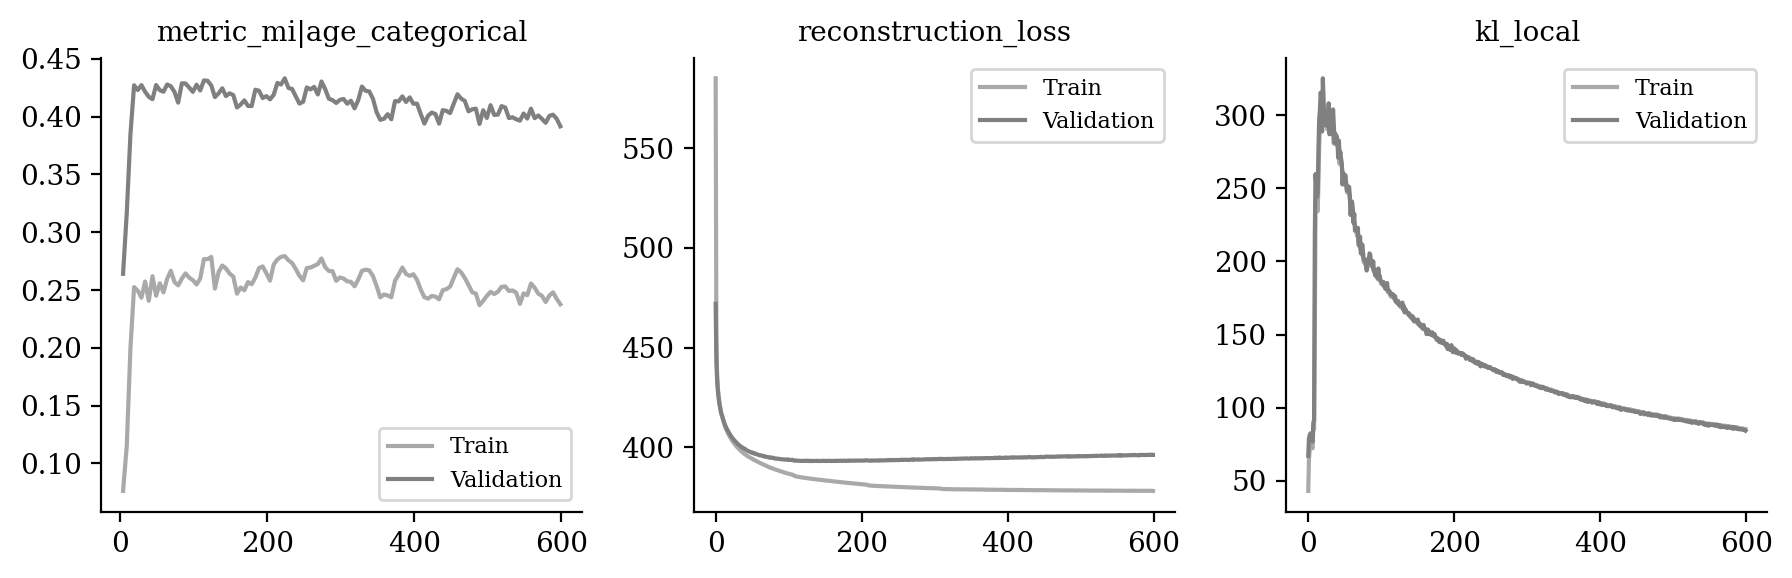

In [11]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|age_categorical", "reconstruction_loss", "kl_local"]
)

In [12]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [13]:
sublatent = DM.configurations.get_by_obs_key("age_categorical").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )

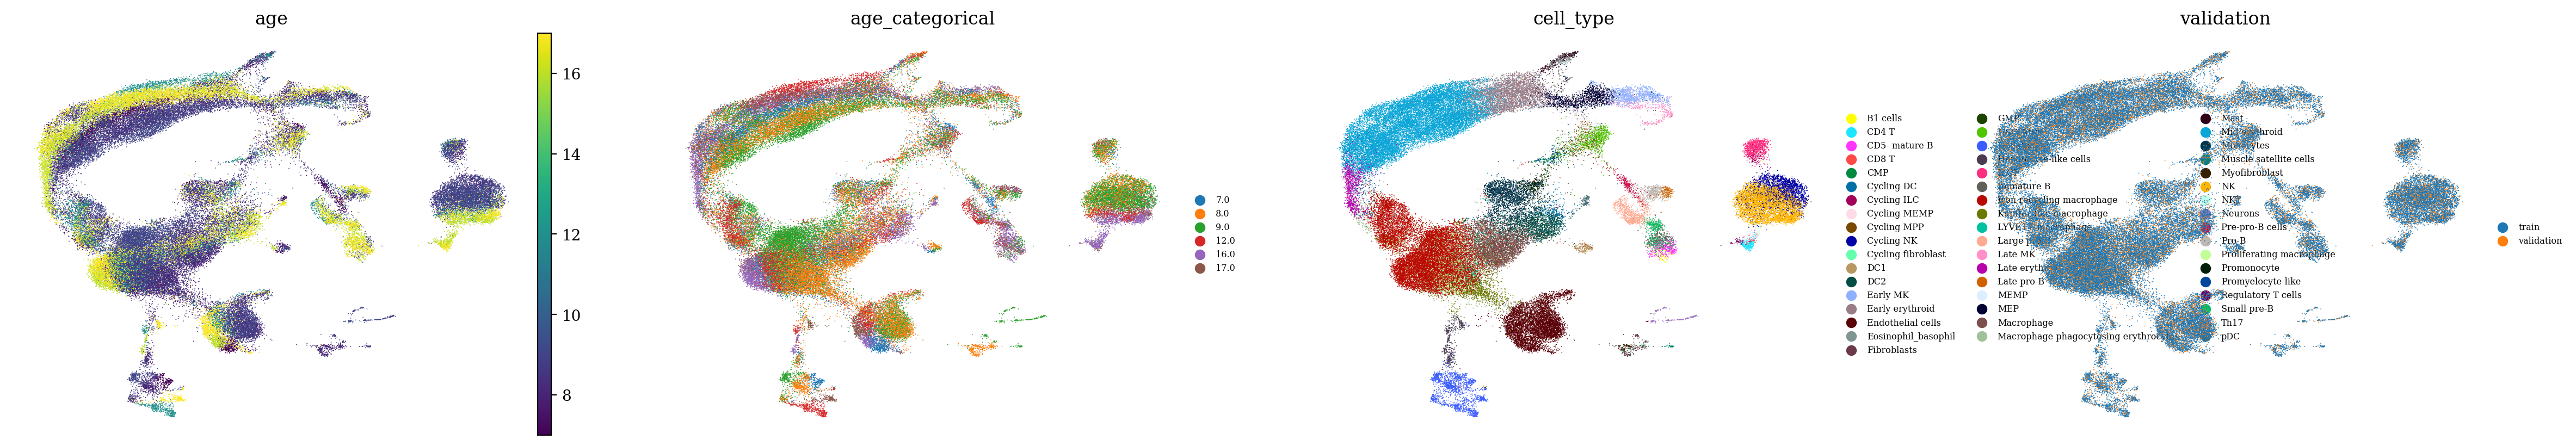

In [15]:
sublatent = DM.configurations.unreserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )

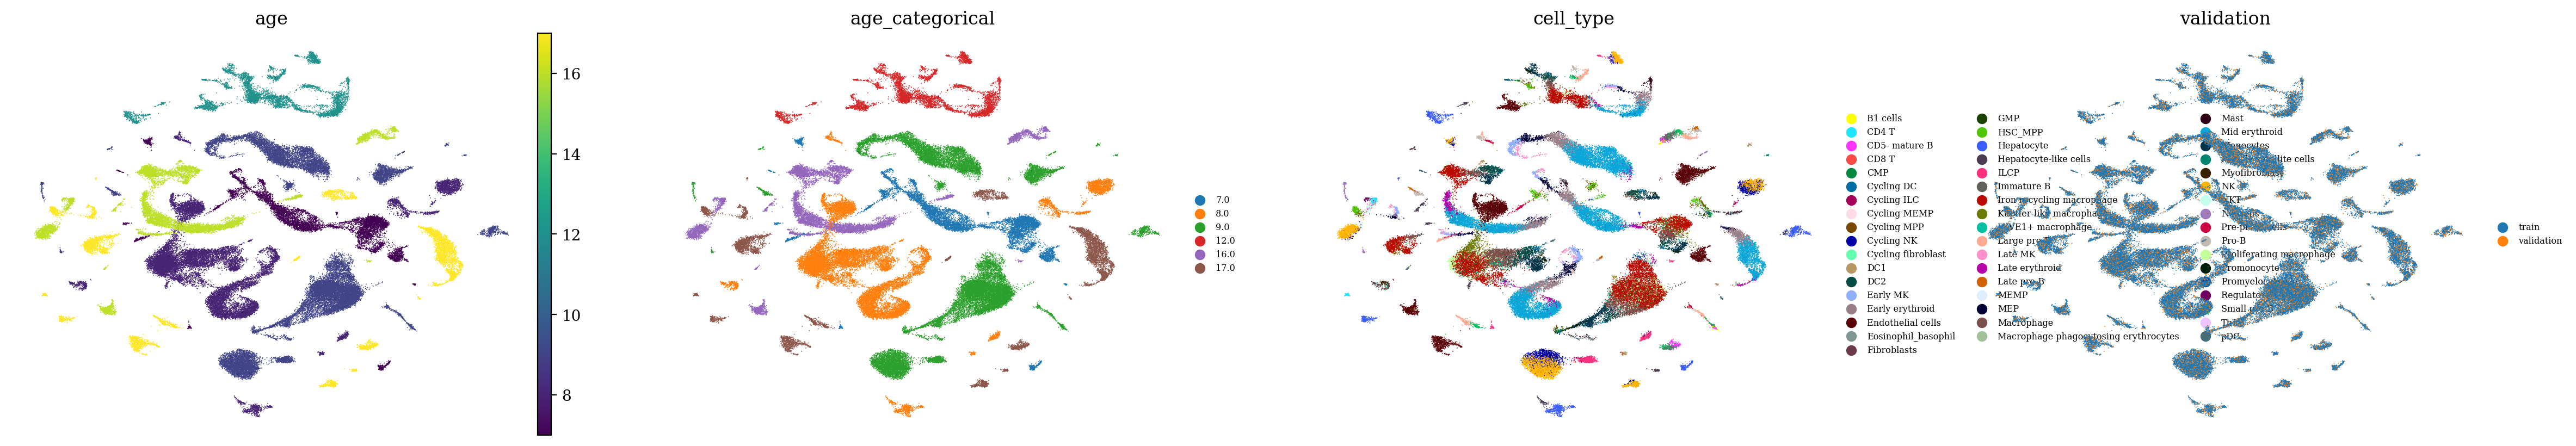

In [16]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )